<a href="https://colab.research.google.com/github/MrDPedersen/UALR-IFSC7370DataScience/blob/main/Data_Analytics_Histort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFSC_7370_9U1

# 2025 10 Spring: Data Science - Technologies

Dennis Pedersen

# Fetch, process, and analyze Common Vulnerabilities and Exposures (CVEs) from the National Vulnerability Database (NVD) API for data from 2019 to 2024

This script is designed to fetch, process, and analyze Common Vulnerabilities and Exposures (CVEs) from the National Vulnerability Database (NVD) API for a specified date range. It systematically retrieves CVE data from 2019 to 2024, processes the data into a structured format, and categorizes vulnerabilities based on their severity levels. The final output is stored as JSON files containing monthly and yearly breakdowns of CVE counts.

Key Functions and Purpose:

1. Fetching CVE Data (fetch_all_cves)
  - Uses the NVD API to collect all CVEs within a specified date range, utilizing
pagination to retrieve large datasets efficiently.
  - Logs errors and continues execution instead of stopping on failures.

2. Processing CVE Data (process_cve_data)
  - Converts raw CVE JSON data into a structured Pandas DataFrame.
  - Extracts key information such as CVE ID, published date, last modified date, and severity rating.
  - Handles missing or malformed data gracefully.

3. Counting CVEs by Severity (count_cves)
  - Filters CVEs by a given year and month to count occurrences of Critical,  High, Medium, Low, and Unknown severity levels.

4. Main Execution (main)
  - Iterates over all months from 2019 to 2024, fetching and processing CVE data for each period.
  - Saves both raw CVE data and severity statistics as JSON files for future reference.
  - Summarizes yearly CVE statistics for trend analysis.



NVD_Pull_cve_counts1-8_dateFilter.py

In [ ]:
import requests
import json
import os
import pandas as pd

# ---  NVD API Configuration ---
API_KEY = "key"  # Replace with an actual API key
BASE_URL = "https://services.nvd.nist.gov/rest/json/cves/2.0"
RESULTS_PER_PAGE = 200  # Maximum allowed by NVD API


# ---  Fetch CVEs from NVD API with Pagination ---
def fetch_all_cves(start_date, end_date):
    """
    Fetch all CVEs from NVD API within a given date range, using pagination.
    Handles errors and logs failures instead of stopping execution.
    """
    try:
        headers = {"apiKey": API_KEY}
        cve_list = []
        start_index = 0

        while True:
            params = {
                "startIndex": start_index,
                "resultsPerPage": RESULTS_PER_PAGE,
                "pubStartDate": start_date,
                "pubEndDate": end_date
            }

            response = requests.get(BASE_URL, headers=headers, params=params)

            if response.status_code == 200:
                data = response.json()
                if "vulnerabilities" in data and len(data["vulnerabilities"]) > 0:
                    cve_list.extend(data["vulnerabilities"])
                    start_index += RESULTS_PER_PAGE
                else:
                    print(f" No more CVEs for {start_date} to {end_date}. Pagination complete.")
                    break
            else:
                print(f" API Error ({response.status_code}) for {start_date} to {end_date}: {response.text}")
                return None  # Return None so the main function knows to skip processing

        return cve_list

    except Exception as e:
        print(f" Unexpected error while fetching {start_date} to {end_date}: {e}")
        return None


# --- 🔹 Process and Count CVEs ---
def process_cve_data(cve_data):
    """
    Convert raw CVE data into a structured Pandas DataFrame.
    Handles errors in baseSeverity and logs missing values instead of stopping execution.
    """
    try:
        cve_list = []
        missing_severity_count = 0  # Track issues with missing severity

        for entry in cve_data:
            cve = entry.get("cve", {})
            cve_id = cve.get("id", "N/A")
            published = cve.get("published", "N/A")
            last_modified = cve.get("lastModified", "N/A")

            # Extract severity from CVSS (if available)
            severity = "Unknown"  # Default value
            metrics = cve.get("metrics", {})

            try:
                if "cvssMetricV31" in metrics and "cvssData" in metrics["cvssMetricV31"][0]:
                    severity = metrics["cvssMetricV31"][0]["cvssData"].get("baseSeverity", "Unknown")
                elif "cvssMetricV30" in metrics and "cvssData" in metrics["cvssMetricV30"][0]:
                    severity = metrics["cvssMetricV30"][0]["cvssData"].get("baseSeverity", "Unknown")
                elif "cvssMetricV2" in metrics and "cvssData" in metrics["cvssMetricV2"][0]:
                    severity = metrics["cvssMetricV2"][0]["cvssData"].get("baseSeverity", "Unknown")
                else:
                    missing_severity_count += 1  # Track missing severity
            except (KeyError, IndexError, TypeError) as e:
                print(f" Warning: Malformed severity data for {cve_id}: {e}")
                missing_severity_count += 1

            cve_list.append({
                "CVE ID": cve_id,
                "Published Date": published,
                "Last Modified Date": last_modified,
                "Severity": severity
            })

        # Convert to DataFrame
        df = pd.DataFrame(cve_list)

        # Convert date columns to datetime format
        df["Published Date"] = pd.to_datetime(df["Published Date"], errors="coerce")
        df["Last Modified Date"] = pd.to_datetime(df["Last Modified Date"], errors="coerce")

        if missing_severity_count > 0:
            print(f" Warning: {missing_severity_count} CVEs had missing severity information.")

        return df

    except Exception as e:
        print(f" Error processing CVE data: {e}")
        return None  # Return None so the main function knows to skip analysis


def count_cves(df, year, month):
    """
    Count CVEs by severity level for a given month.
    """
    try:
        filtered_df = df[(df["Published Date"].dt.year == year) & (df["Published Date"].dt.month == month)]

        severity_counts = filtered_df["Severity"].value_counts().to_dict()
        total_cves = len(filtered_df)

        return {
            "Total CVEs": total_cves,
            "Critical": severity_counts.get("CRITICAL", 0),
            "High": severity_counts.get("HIGH", 0),
            "Medium": severity_counts.get("MEDIUM", 0),
            "Low": severity_counts.get("LOW", 0),
            "Unknown": severity_counts.get("Unknown", 0)
        }

    except Exception as e:
        print(f" Error analyzing CVEs for {year}-{month}: {e}")
        return None  # Skip the month and continue


# ---  Main Function ---
def main():
    base_dir = "/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP"
    # Optionally, create the directory if it doesn't exist
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    start_year = 2019
    end_year = 2024
    month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    for year in range(start_year, end_year + 1):  # Loop through years 2019-2024
        yearly_summary = {
            f"Total CVEs in {year}": 0,
            "Critical": 0,
            "High": 0,
            "Medium": 0,
            "Low": 0,
            "Unknown": 0
        }

        for month in range(1, 13):  # Loop through all months
            month_str = month_names[month - 1]  # Get month name (e.g., "Jan")

            # Define filenames with the full path
            cve_data_file = os.path.join(base_dir, f"cve_data_{month_str}{year}.json")
            cve_counts_file = os.path.join(base_dir, f"cve_counts_{month_str}{year}.json")

            # Check if data already exists
            if not os.path.exists(cve_data_file):
                start_date = f"{year}-{month:02d}-01T00:00:00.000Z"
                end_date = f"{year}-{month:02d}-28T23:59:59.999Z"  # Safe for Feb; API should handle correct end date

                print(f"\n Fetching CVEs for {month_str} {year}...")
                cve_data = fetch_all_cves(start_date, end_date)

                if cve_data is None:
                    print(f" Skipping {month_str} {year} due to fetch failure.")
                    continue  # Skip to next month

                # Save raw data to JSON
                with open(cve_data_file, "w") as f:
                    json.dump(cve_data, f, indent=4)
                print(f" CVE data saved to '{cve_data_file}'. Total CVEs: {len(cve_data)}")
            else:
                print(f" Using existing data for {month_str} {year}.")

            # Load data (whether newly fetched or pre-existing)
            with open(cve_data_file, "r") as f:
                cve_data = json.load(f)

            # Process Data
            df = process_cve_data(cve_data)
            if df is None:
                print(f" Skipping analysis for {month_str} {year} due to processing failure.")
                continue  # Skip to next month

            # Get monthly breakdown by severity
            severity_counts = count_cves(df, year, month)
            if severity_counts is None:
                print(f" Skipping analysis for {month_str} {year} due to analysis error.")
                continue  # Skip to next month

            # Save results to JSON
            with open(cve_counts_file, "w") as f:
                json.dump(severity_counts, f, indent=4)

            print(f" CVE counts saved to '{cve_counts_file}'.")
            print(severity_counts)

            # Update yearly summary
            yearly_summary[f"Total CVEs in {year}"] += severity_counts["Total CVEs"]
            yearly_summary["Critical"] += severity_counts["Critical"]
            yearly_summary["High"] += severity_counts["High"]
            yearly_summary["Medium"] += severity_counts["Medium"]
            yearly_summary["Low"] += severity_counts["Low"]
            yearly_summary["Unknown"] += severity_counts["Unknown"]

        # Save yearly summary
        yearly_summary_file = os.path.join(base_dir, f"cve_counts_{year}.json")
        with open(yearly_summary_file, "w") as f:
            json.dump(yearly_summary, f, indent=4)

        print(f"\n Yearly summary saved to '{yearly_summary_file}'.")
        print(yearly_summary)



if __name__ == "__main__":
    main()


 Using existing data for Jan 2019.
 CVE counts saved to '/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP/cve_counts_Jan2019.json'.
{'Total CVEs': 1562, 'Critical': 123, 'High': 494, 'Medium': 500, 'Low': 14, 'Unknown': 431}
 Using existing data for Feb 2019.
 CVE counts saved to '/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP/cve_counts_Feb2019.json'.
{'Total CVEs': 882, 'Critical': 139, 'High': 357, 'Medium': 336, 'Low': 6, 'Unknown': 44}
 Using existing data for Mar 2019.
 CVE counts saved to '/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP/cve_counts_Mar2019.json'.
{'Total CVEs': 1587, 'Critical': 165, 'High': 513, 'Medium': 443, 'Low': 19, 'Unknown': 447}
 Using existing data for Apr 2019.
 CVE counts saved to '/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP/cve_counts_Apr2019.json'.
{'Total CVEs': 1470, 'Critical': 185, 'High': 644, 'Medium': 570, 'Low': 31, 'Unknown': 40}
 Using existing data for May 2019.
 CVE counts saved to '/content/drive/MyDrive/DataAnalysis

The Cyberseek workforce data used in this project was obtained by Jerrica Deloatch, upon my request, using this [webscraber](https://drive.google.com/file/d/1i3o14O8L-nHglWvr7By7UHd2iq37PL7c/view?usp=sharing) on Sep 13, 2024. She is also the author of the webscraber used.

# **Analysis the relationship between cybersecurity vulnerabilities (CVEs) and cyber workforce trends over the years 2019-2024**

This script analyzes the relationship between cybersecurity vulnerabilities (CVEs) and cyber workforce trends over the years 2019-2024 using data visualization and statistical analysis. It integrates data from CVE reports and cyber workforce employment statistics to investigate potential correlations between the rise in security vulnerabilities and workforce trends such as job openings, employment, and supply/demand ratios.

Key Functions and Purpose:

Data Loading and Preprocessing:
1. Reads CVE counts from JSON files (2019-2024) and organizes them into a Pandas DataFrame.
  - Reads cyber workforce data from CSV files (job openings, employment, and supply/demand ratio).
  - Merges CVE data with workforce data, ensuring a structured format for further analysis.

2. Correlation and Statistical Analysis:
  - Computes correlation coefficients between total CVEs and workforce metrics:
    - CVEs vs Job Openings
    - CVEs vs Total Employment
    - CVEs vs Supply/Demand Ratio
  - Performs linear regression to find trends in the relationship between CVE counts and workforce metrics.

3. Data Visualization & Trend Analysis:
  - Time-Series Plots: Visualizes total CVEs, severity distribution, and cybersecurity job trends over time.
  - Heatmaps: Displays correlations between workforce metrics and CVEs.
  - Rolling Correlation Analysis: Computes moving correlation trends between CVEs and job market metrics to track shifts over time.
  - Scatter Plots with Regression: Plots linear regression lines to illustrate the relationship between vulnerabilities and workforce trends.

4. Key Findings:
  - Determines whether an increase in cybersecurity vulnerabilities is accompanied by a growing cybersecurity job market.
  - Explores whether workforce supply matches demand as CVE counts fluctuate.
  - Identifies any predictive trends that might suggest workforce shortages or security risks.

Overall Functionality:

This script automates cybersecurity labor market analysis by integrating vulnerability trends with employment data. The results help cybersecurity professionals, policymakers, and analysts assess whether the industry is keeping up with the growing number of security threats. The findings are exported as CSV files for further use in reporting or predictive modeling.

AnalysisNVD1-7.py

CVE Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown
0  2019       17456      2415   6711    6709   323     1298
1  2020       17967      2388   7200    7039   451      889
2  2021       20797      2379   7994    8012   618     1794
3  2022       24707      3538   9194   10055   895     1023
4  2023       28565      3378   9074   12885  1196     2029
5  2024       37713      3276  12338   18008  1560     2524

Merged CVE & Cyber Workforce Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown  Job Openings  \
0  2019       17456      2415   6711    6709   323     1298       1138516   
1  2020       17967      2388   7200    7039   451      889       1030312   
2  2021       20797      2379   7994    8012   618     1794       1149137   
3  2022       24707      3538   9194   10055   895     1023        711502   
4  2023       28565      3378   9074   12885  1196     2029        994872   
5  2024       37713      3276  12338   18008  15

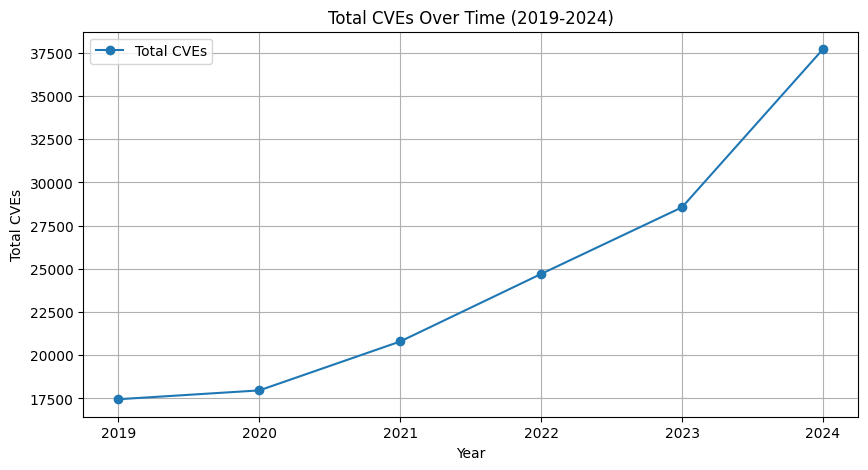

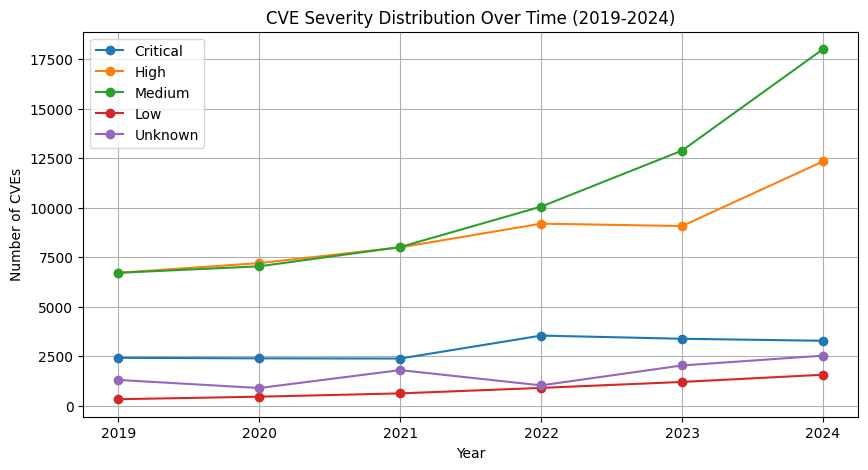

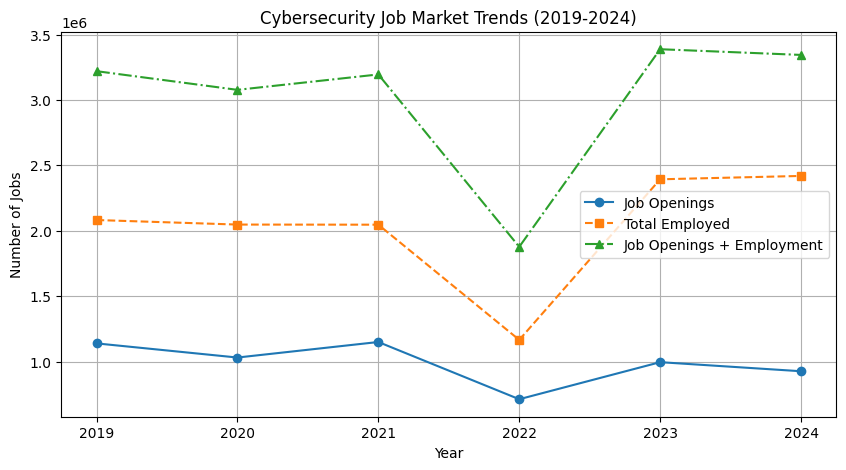

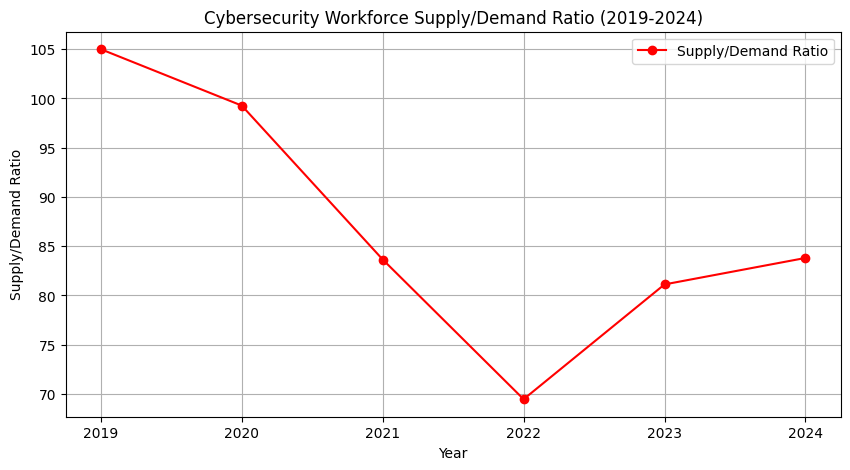

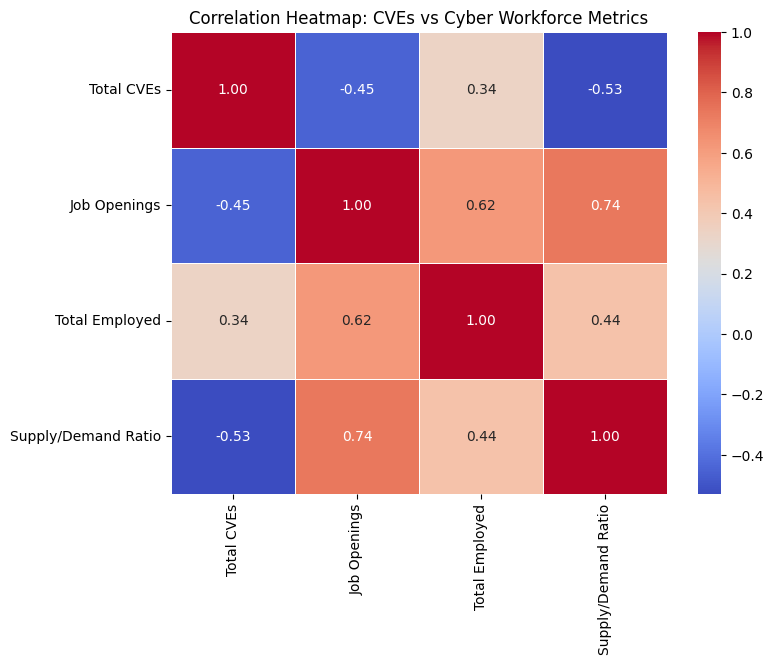

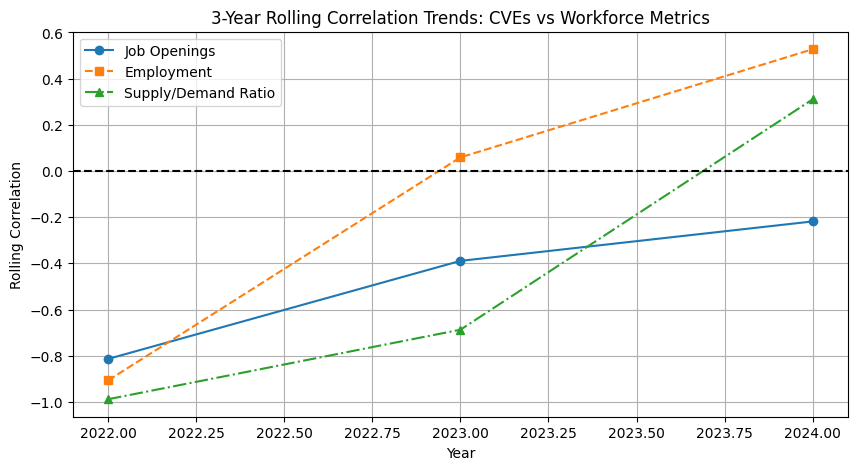

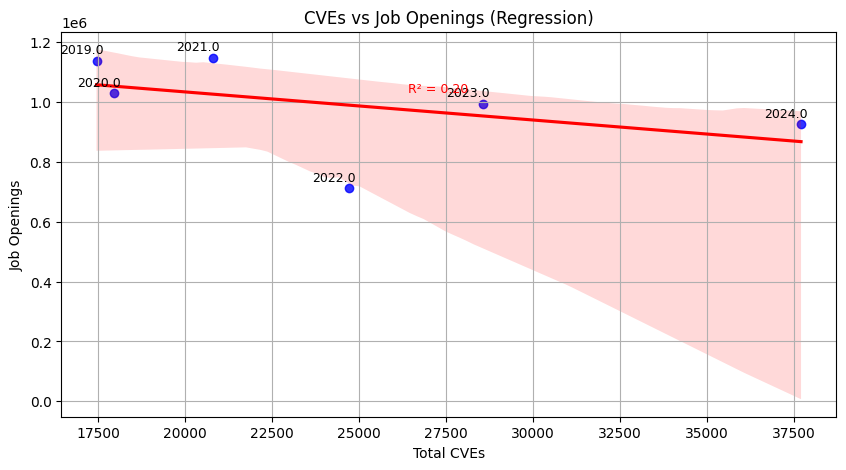

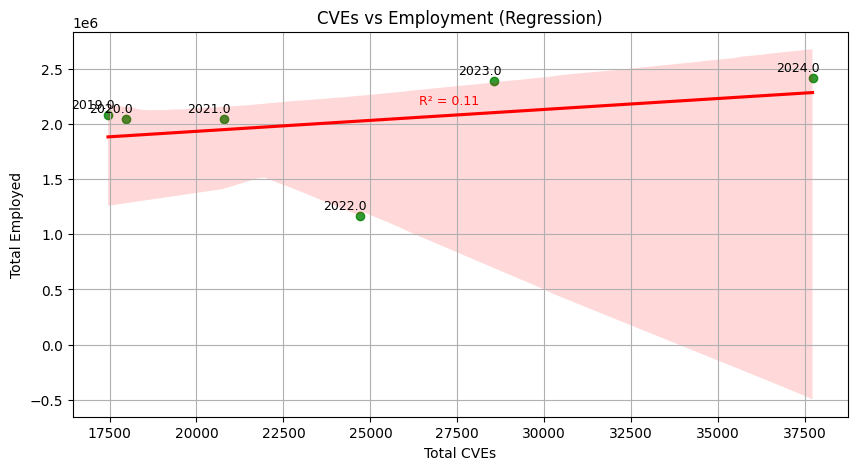

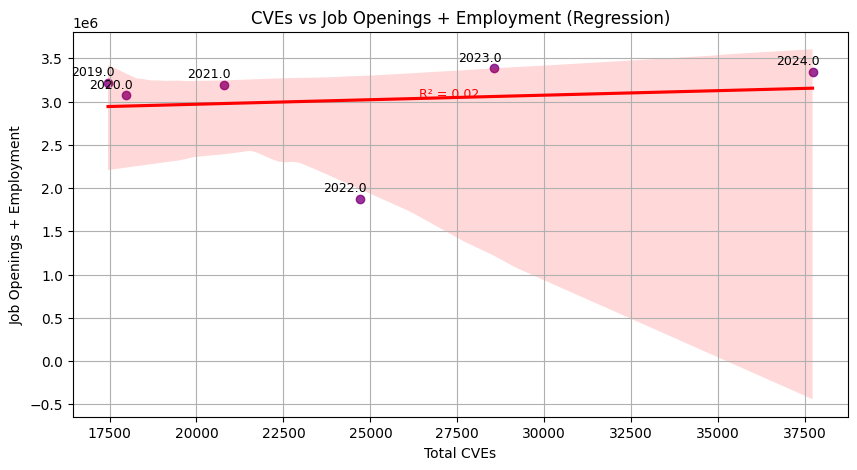

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from scipy.optimize import curve_fit

import matplotlib
#matplotlib.use('TkAgg')  # Use TkAgg backend instead of PyCharm's default

# Directory where JSON and CSV files are stored (Update this path as needed)
data_dir = r"/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP"

# List of CVE JSON files (ensure they are named consistently)
json_files = [
    "cve_counts_2019.json",
    "cve_counts_2020.json",
    "cve_counts_2021.json",
    "cve_counts_2022.json",
    "cve_counts_2023.json",
    "cve_counts_2024.json"
]

# Dictionary to store CVE data
cve_data = {
    "Year": [],
    "Total CVEs": [],
    "Critical": [],
    "High": [],
    "Medium": [],
    "Low": [],
    "Unknown": []
}

# Load data from JSON files
for file in json_files:
    file_path = os.path.join(data_dir, file)

    with open(file_path, "r") as f:
        data = json.load(f)

    year = int(file.split("_")[2].split(".")[0])  # Extract year from filename
    cve_data["Year"].append(year)
    cve_data["Total CVEs"].append(data[f"Total CVEs in {year}"])
    cve_data["Critical"].append(data["Critical"])
    cve_data["High"].append(data["High"])
    cve_data["Medium"].append(data["Medium"])
    cve_data["Low"].append(data["Low"])
    cve_data["Unknown"].append(data["Unknown"])

# Convert to DataFrame
df_cve = pd.DataFrame(cve_data)

# Save CVE data as CSV
cve_csv_path = os.path.join(data_dir, "cve_data_2019_2024.csv")
df_cve.to_csv(cve_csv_path, index=False)

print("CVE Data (2019-2024):")
print(df_cve)

# List of Cyber Workforce Data CSV files
workforce_files = [
    "Cyber_Workforce_Data_2019.csv",
    "Cyber_Workforce_Data_2020.csv",
    "Cyber_Workforce_Data_2021.csv",
    "Cyber_Workforce_Data_2022.csv",
    "Cyber_Workforce_Data_2023.csv",
    "Cyber_Workforce_Data_2024.csv",
]

# Load each workforce data file into a DataFrame and concatenate
workforce_dfs = []
years = list(range(2019, 2025))  # 2019 to 2024

for i, file in enumerate(workforce_files):
    file_path = os.path.join(data_dir, file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Year"] = years[i]  # Add year column
        workforce_dfs.append(df)
    else:
        print(f"Warning: {file} not found!")

# Concatenate all years of Cyber Workforce data into a single DataFrame
df_workforce = pd.concat(workforce_dfs, ignore_index=True)

# Aggregate workforce data properly
df_workforce_agg = df_workforce.groupby("Year").agg(
    {"Job Openings": "sum",
     "Total Employed": "sum",
     "Supply/Demand Ratio": "mean"}
).reset_index()

# Merge CVE data with Workforce data
df_combined = pd.merge(df_cve, df_workforce_agg, on="Year")

# Save merged data as CSV
merged_csv_path = os.path.join(data_dir, "cve_workforce_comparison.csv")
df_combined.to_csv(merged_csv_path, index=False)

print("\nMerged CVE & Cyber Workforce Data (2019-2024):")
print(df_combined)

# Load merged dataset
merged_csv_path = os.path.join(data_dir, "cve_workforce_comparison.csv")
df_combined = pd.read_csv(merged_csv_path)

# Compute Job Openings + Total Employed
df_combined["Job Openings + Employment"] = df_combined["Job Openings"] + df_combined["Total Employed"]

# CORRELATION ANALYSIS & TREND ANALYSIS
correlation_data = {
    "Metric": [
        "CVEs vs Job Openings Correlation",
        "CVEs vs Employment Correlation",
        "CVEs vs Supply/Demand Ratio Correlation",
        "Linear Regression Slope (CVEs vs Job Openings)",
        "Linear Regression Slope (CVEs vs Employment)",
        "Linear Regression Slope (CVEs vs Job Openings + Employment)"  # New metric added
    ],
    "Value": [
        np.corrcoef(df_combined["Total CVEs"], df_combined["Job Openings"])[0, 1],
        np.corrcoef(df_combined["Total CVEs"], df_combined["Total Employed"])[0, 1],
        np.corrcoef(df_combined["Total CVEs"], df_combined["Supply/Demand Ratio"])[0, 1],
        stats.linregress(df_combined["Total CVEs"], df_combined["Job Openings"])[0],
        stats.linregress(df_combined["Total CVEs"], df_combined["Total Employed"])[0],
        stats.linregress(df_combined["Total CVEs"], df_combined["Job Openings + Employment"])[0]  # New computation
    ]
}

# Convert to DataFrame and save
df_correlation = pd.DataFrame(correlation_data)
correlation_csv_path = os.path.join(data_dir, "cve_correlation_trends.csv")
df_correlation.to_csv(correlation_csv_path, index=False)


# PRINT ANALYSIS TO CONSOLE
print("\n### Correlation Analysis ###")
print(df_correlation)

print(f"\nCorrelation & Trend Analysis saved to: {correlation_csv_path}")

# Define an exponential function for curve fitting
def exponential_model(x, a, b, c):
    return a * np.exp(b * x) + c

# Fit the exponential model to the CVE data
years = df_combined["Year"].values
total_cves = df_combined["Total CVEs"].values
#params, covariance = curve_fit(exponential_model, years, total_cves, p0=[1, 0.1, 1], maxfev=10000)

# PLOT DATA AS BEFORE
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Total CVEs"], marker="o", linestyle="-", label="Total CVEs")
plt.xlabel("Year")
plt.ylabel("Total CVEs")
plt.title("Total CVEs Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for severity in ["Critical", "High", "Medium", "Low", "Unknown"]:
    plt.plot(df_combined["Year"], df_combined[severity], marker="o", linestyle="-", label=severity)
plt.xlabel("Year")
plt.ylabel("Number of CVEs")
plt.title("CVE Severity Distribution Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Total Employed"], marker="s", linestyle="--", label="Total Employed")
plt.plot(df_combined["Year"], df_combined["Job Openings + Employment"], marker="^", linestyle="-.", label="Job Openings + Employment")
plt.xlabel("Year")
plt.ylabel("Number of Jobs")
plt.title("Cybersecurity Job Market Trends (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Supply/Demand Ratio"], marker="o", linestyle="-", color="red", label="Supply/Demand Ratio")
plt.xlabel("Year")
plt.ylabel("Supply/Demand Ratio")
plt.title("Cybersecurity Workforce Supply/Demand Ratio (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

# 1. Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_combined[["Total CVEs", "Job Openings", "Total Employed", "Supply/Demand Ratio"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: CVEs vs Cyber Workforce Metrics")
plt.show()

# 2. Yearly Correlation Trends
# Compute rolling correlation (window size of 3 years)
window_size = 4

df_combined["Rolling CVEs vs Job Openings"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Job Openings"])
df_combined["Rolling CVEs vs Employment"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Total Employed"])
df_combined["Rolling CVEs vs Supply/Demand Ratio"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Supply/Demand Ratio"])

# Plot Rolling Correlation Trends
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Employment"], marker="s", linestyle="--", label="Employment")
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Supply/Demand Ratio"], marker="^", linestyle="-.", label="Supply/Demand Ratio")

plt.xlabel("Year")
plt.ylabel("Rolling Correlation")
plt.title("3-Year Rolling Correlation Trends: CVEs vs Workforce Metrics")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.grid(True)
plt.show()

# 3. Scatter Plots with Regression Lines
# Perform Linear Regression for CVEs vs Job Openings
slope_jobs, intercept_jobs, r_value_jobs, p_value_jobs, std_err_jobs = stats.linregress(
    df_combined["Total CVEs"], df_combined["Job Openings"]
)

# Perform Linear Regression for CVEs vs Employment
slope_employment, intercept_employment, r_value_employment, p_value_employment, std_err_employment = stats.linregress(
    df_combined["Total CVEs"], df_combined["Total Employed"]
)

# Scatter Plot with Regression for CVEs vs Job Openings
plt.figure(figsize=(10, 5))
sns.regplot(
    x=df_combined["Total CVEs"], y=df_combined["Job Openings"],
    scatter_kws={"color": "blue"}, line_kws={"color": "red"}
)

# Annotate each scatter point with the corresponding year
for i, row in df_combined.iterrows():
    plt.annotate(row["Year"], (row["Total CVEs"], row["Job Openings"]), textcoords="offset points", xytext=(5,5), ha='right', fontsize=9)

# Add R² value label
plt.text(
    df_combined["Total CVEs"].max() * 0.7, df_combined["Job Openings"].max() * 0.9,
    f"R² = {r_value_jobs**2:.2f}", fontsize=9, color="red"
)

plt.xlabel("Total CVEs")
plt.ylabel("Job Openings")
plt.title("CVEs vs Job Openings (Regression)")
plt.grid(True)
plt.show()

# Scatter Plot with Regression for CVEs vs Employment
plt.figure(figsize=(10, 5))
sns.regplot(
    x=df_combined["Total CVEs"], y=df_combined["Total Employed"],
    scatter_kws={"color": "green"}, line_kws={"color": "red"}
)

# Annotate each scatter point with the corresponding year
for i, row in df_combined.iterrows():
    plt.annotate(row["Year"], (row["Total CVEs"], row["Total Employed"]), textcoords="offset points", xytext=(5,5), ha='right', fontsize=9)

# Add R² value label
plt.text(
    df_combined["Total CVEs"].max() * 0.7, df_combined["Total Employed"].max() * 0.9,
    f"R² = {r_value_employment**2:.2f}", fontsize=9, color="red"
)

plt.xlabel("Total CVEs")
plt.ylabel("Total Employed")
plt.title("CVEs vs Employment (Regression)")
plt.grid(True)
plt.show()

# Perform linear regression for CVEs vs Job Openings + Total Employed
slope_combined, intercept_combined, r_value_combined, p_value_combined, std_err_combined = stats.linregress(
    df_combined["Total CVEs"], df_combined["Job Openings + Employment"]
)

# Scatter Plot with Regression for CVEs vs Job Openings + Total Employed
plt.figure(figsize=(10, 5))
sns.regplot(
    x=df_combined["Total CVEs"], y=df_combined["Job Openings + Employment"],
    scatter_kws={"color": "purple"}, line_kws={"color": "red"}
)

# Annotate each scatter point with the corresponding year
for i, row in df_combined.iterrows():
    plt.annotate(row["Year"], (row["Total CVEs"], row["Job Openings + Employment"]), textcoords="offset points", xytext=(5,5), ha='right', fontsize=9)

# Add R² value label
plt.text(
    df_combined["Total CVEs"].max() * 0.7, df_combined["Job Openings + Employment"].max() * 0.9,
    f"R² = {r_value_combined**2:.2f}", fontsize=9, color="red"
)

plt.xlabel("Total CVEs")
plt.ylabel("Job Openings + Employment")
plt.title("CVEs vs Job Openings + Employment (Regression)")
plt.grid(True)
plt.show()

CVE data stored because of execusion of AnalysisNVD1-8.py

|Year|Total CVEs|Critical|High|Medium|Low|Unknown|Job Openings|Total Employed|Supply/Demand Ratio|
|---|---|---|---|---|---|---|---|---|---|
|2019|17456|2415|6711|6709|323|1298|1138516|2082020|105\.0|
|2020|17967|2388|7200|7039|451|889|1030312|2047264|99\.27450980392157|
|2021|20797|2379|7994|8012|618|1794|1149137|2046356|83\.6470588235294|
|2022|24707|3538|9194|10055|895|1023|711502|1165332|69\.46|
|2023|28565|3378|9074|12885|1196|2029|994872|2393472|81\.11764705882354|
|2024|37713|3276|12338|18008|1560|2524|925493|2419245|83\.80392156862744|

|Year|Total CVEs|Critical|High|Medium|Low|Unknown|Job Openings|Total Employed|Supply/Demand Ratio|CVE Growth Rate|Job Openings Growth Rate|Employment Growth Rate|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|2019|17456|2415|6711|6709|323|1298|1138516|2082020|105\.0||||
|2020|17967|2388|7200|7039|451|889|1030312|2047264|99\.27450980392157|2\.9273602199816784|-9\.503950756950275|-1\.6693403521579997|
|2021|20797|2379|7994|8012|618|1794|1149137|2046356|83\.6470588235294|15\.751099237490962|11\.532914301687258|-0\.04435187645560612|
|2022|24707|3538|9194|10055|895|1023|711502|1165332|69\.46|18\.800788575275273|-38\.083796797074676|-43\.0533103721933|
|2023|28565|3378|9074|12885|1196|2029|994872|2393472|81\.11764705882354|15\.615007892500099|39\.827013838330735|105\.38970868387723|
|2024|37713|3276|12338|18008|1560|2524|925493|2419245|83\.80392156862744|32\.02520567127605|-6\.973660933265791|1\.0768039066260338|

|Metric|Value|
|---|---|
|CVEs vs Job Openings Correlation|-0\.4475136125168652|
|CVEs vs Employment Correlation|0\.3366761902690481|
|CVEs vs Supply/Demand Ratio Correlation|-0\.5296276301815717|
|Linear Regression Slope \(CVEs vs Job Openings\)|-9\.386727776476524|
|Linear Regression Slope \(CVEs vs Employment\)|19\.864266296575035|
|Linear Regression Slope \(CVEs vs Job Openings + Employment\)|10\.477538520098511|

# Additinal analysis.
I realized that I wanted to include more data and added this data using the NVD_Pull_cve_counts1-8_dateFilter.py with years set to 2010-2024.

The NVD has data from before 2010 but cyberseek's workforce data beguins with 2010 data.



From cve_workforce_comparison3.csv :

|Year|Total CVEs|Critical|High|Medium|Low|Unknown|Job Openings|Total Employed|Supply/Demand Ratio|
|---|---|---|---|---|---|---|---|---|---|
|2010|4303|24|67|15|2|4195|145767|551710|127|
|2011|3880|5|38|9|0|3828|199957|622764|129|
|2012|5026|17|42|41|0|4926|222615|794594|130|
|2013|4946|16|42|12|0|4876|241875|657865|127|
|2014|7466|18|40|23|3|7382|279408|721418|122|
|2015|6202|33|79|31|5|6054|368368|836853|113|
|2016|6171|842|2722|2152|175|280|394168|945632|112|
|2017|17084|1925|6260|5214|225|3460|413352|1001404|109|
|2018|16992|2362|6902|5910|221|1597|545741|1028798|95|
|2019|17456|2415|6712|6708|323|1298|565543|1030287|93|
|2020|17967|2388|7200|7039|451|889|525631|1049519|90|
|2021|20797|2379|7994|8012|618|1794|583718|1035395|82|
|2022|24707|3538|9194|10055|895|1023|730565|1193600|70|
|2023|28565|3378|9074|12885|1196|2029|505163|1224766|82|
|2024|37713|3276|12338|18008|1560|2524|457398|1251007|83|

As well as adding the following analasys types:


Pearson correlation

Spearman correlation

Kendall Tau correlation

Correlation Analysis for Selected Pairs

Simple Linear Regression: Job Openings ~ Total

Multiple Linear Regression: Job Openings ~ Severity Metrics

Partial Correlation Analysis (Controlling for Year)

Bootstrap the Pearson Correlation for Total CVEs vs Job Openings

Data Preview:
    Year  Total CVEs  Critical   High  Medium   Low  Unknown  Job Openings  \
0   2010        4303        24     67      15     2     4195        145767   
1   2011        3880         5     38       9     0     3828        199957   
2   2012        5026        17     42      41     0     4926        222615   
3   2013        4946        16     42      12     0     4876        241875   
4   2014        7466        18     40      23     3     7382        279408   
5   2015        6202        33     79      31     5     6054        368368   
6   2016        6171       842   2722    2152   175      280        394168   
7   2017       17084      1925   6260    5214   225     3460        413352   
8   2018       16992      2362   6902    5910   221     1597        545741   
9   2019       17456      2415   6712    6708   323     1298        565543   
10  2020       17967      2388   7200    7039   451      889        525631   
11  2021       20797      2379   7994    8012   61

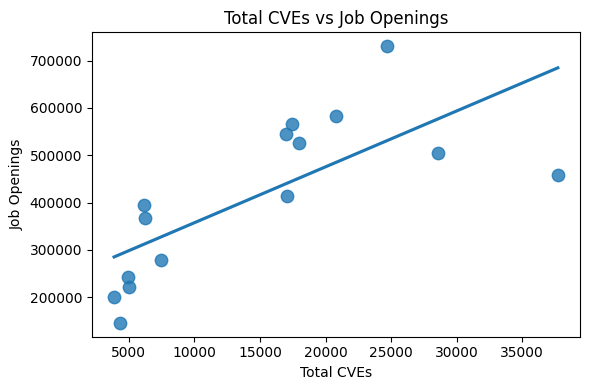

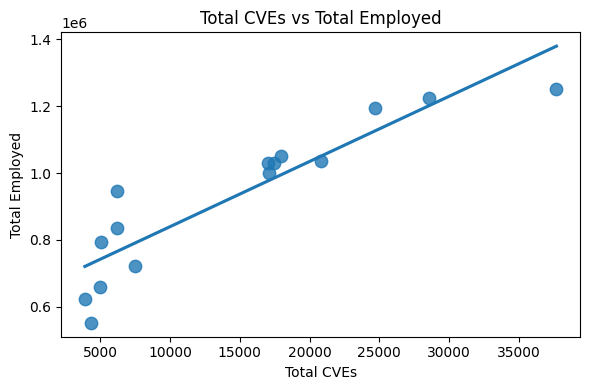

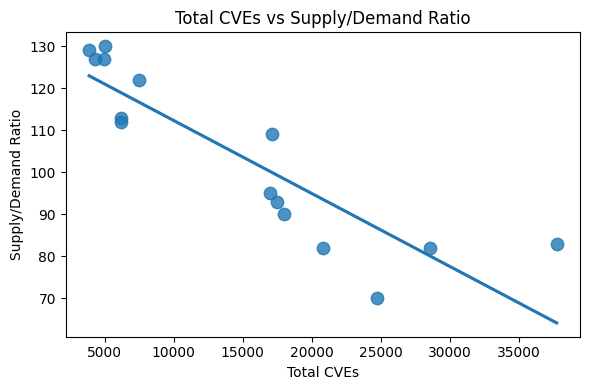

Simple Linear Regression: Job Openings ~ Total CVEs
                            OLS Regression Results                            
Dep. Variable:           Job Openings   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     14.52
Date:                Mon, 10 Feb 2025   Prob (F-statistic):            0.00217
Time:                        23:29:54   Log-Likelihood:                -195.65
No. Observations:                  15   AIC:                             395.3
Df Residuals:                      13   BIC:                             396.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


Bootstrap Pearson Correlation for Total CVEs vs Job Openings:
  Mean Pearson Correlation: 0.7503
  95% Confidence Interval: [0.5123, 0.9621]



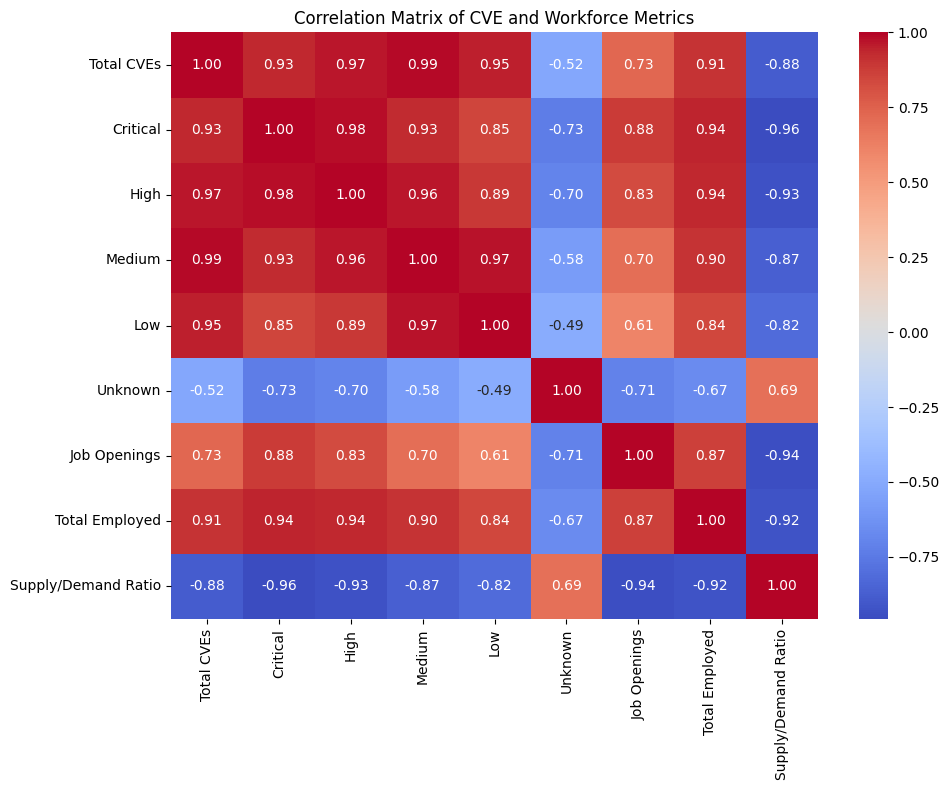

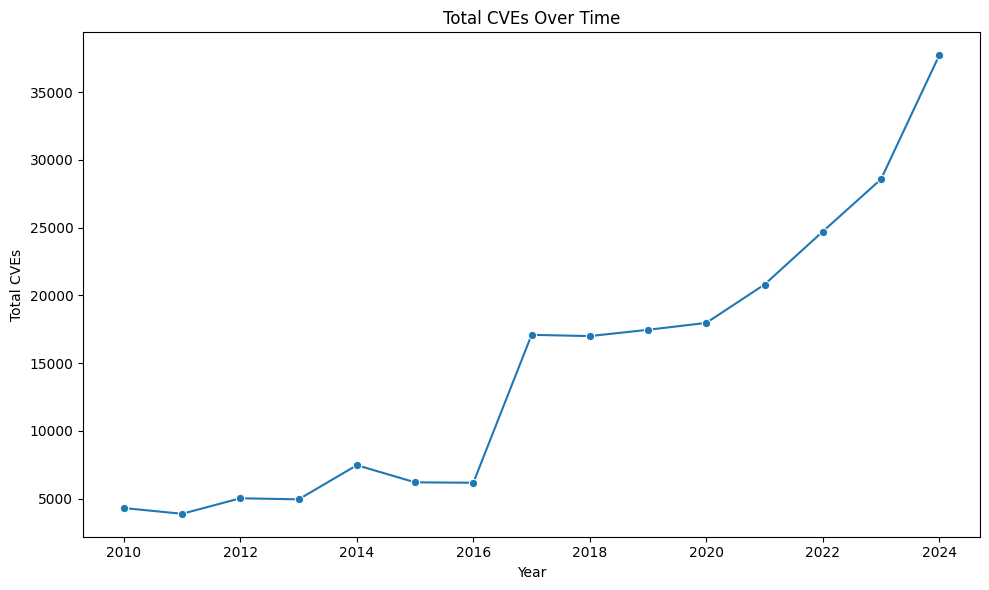

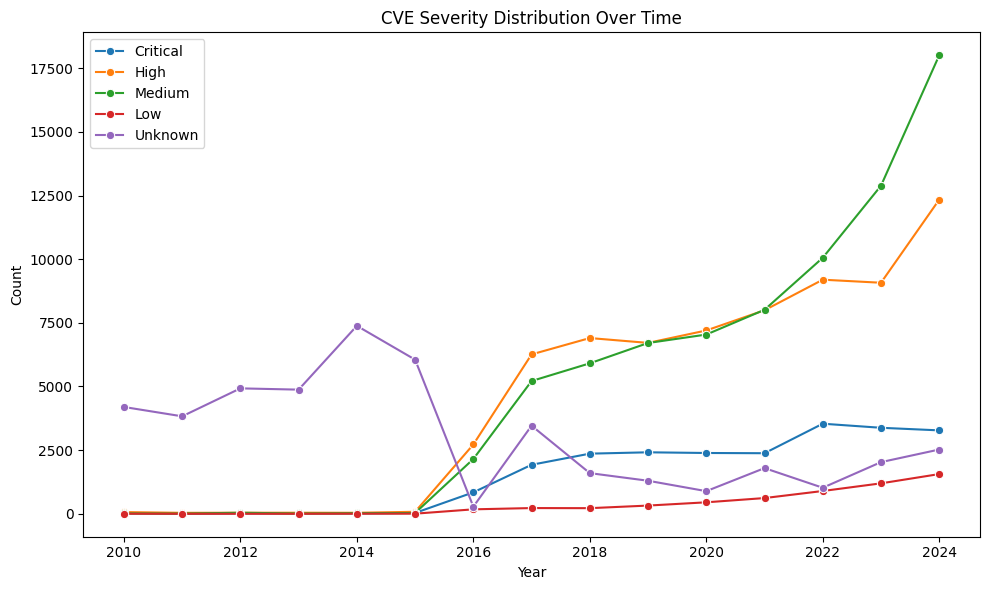

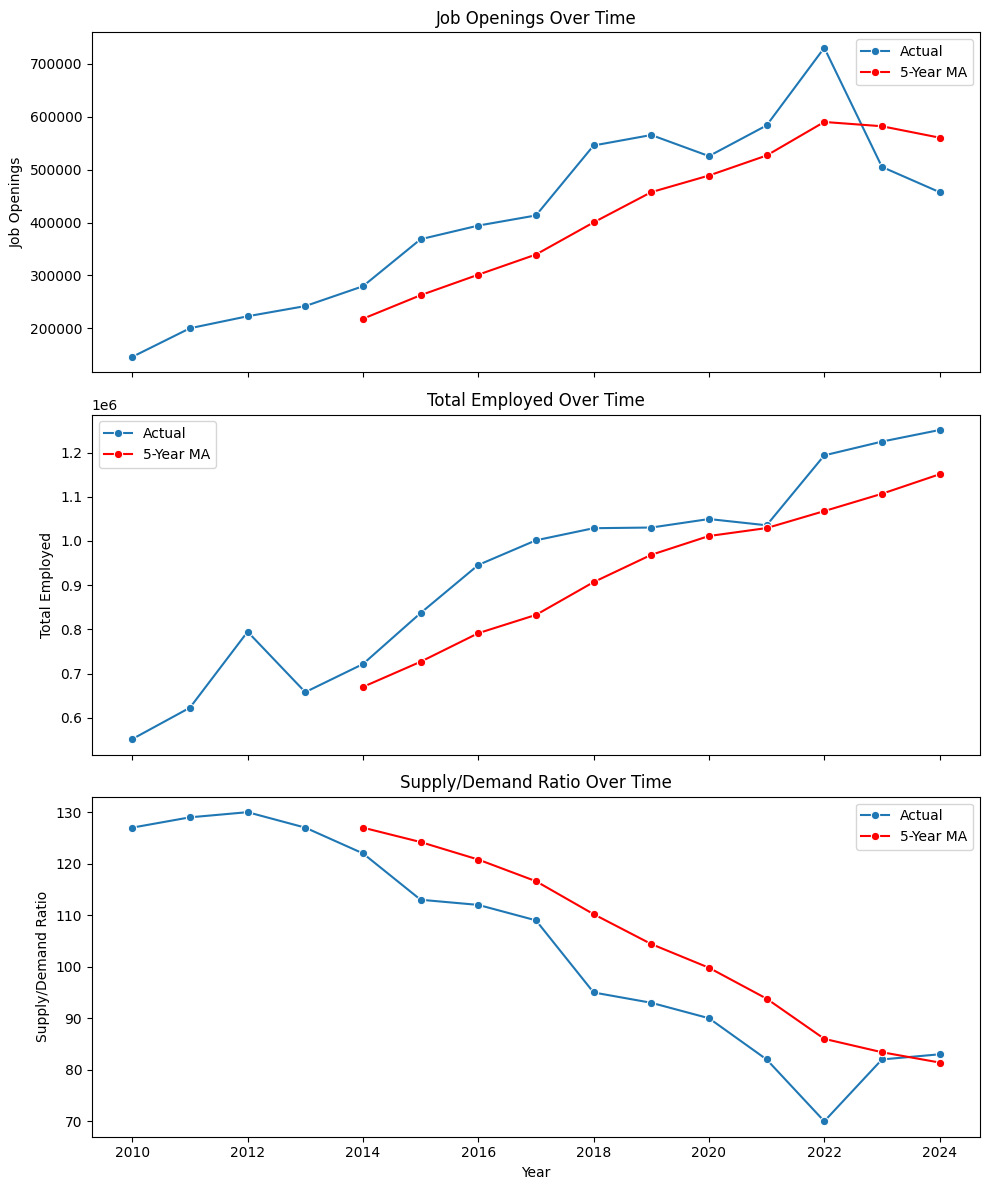

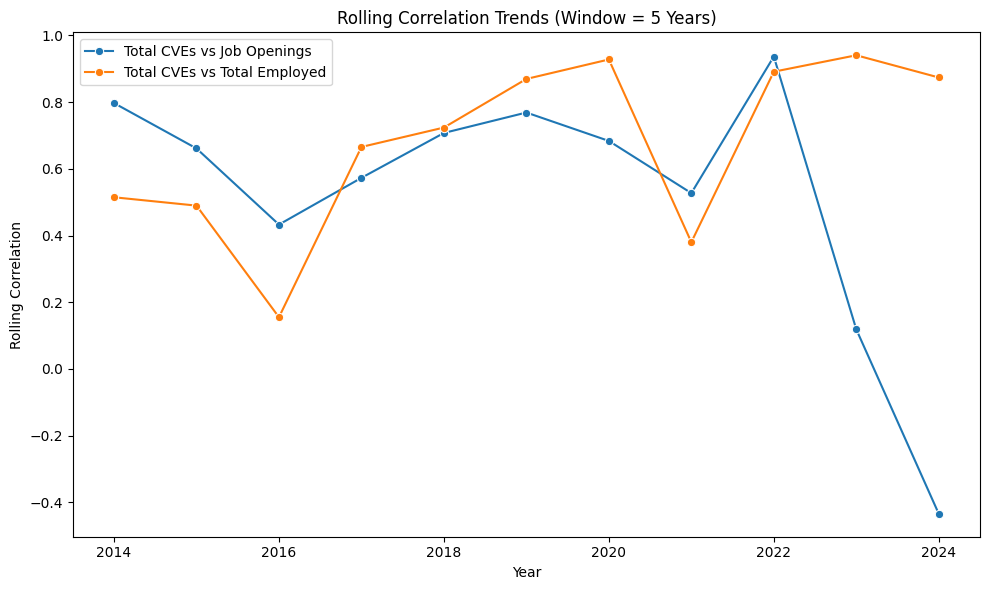

Linear Regression for Total CVEs vs (Job Openings + Total Employed):
  Slope: 31.2903
  Intercept: 884247.1612
  R-squared: 0.7341
  P-value: 0.0000
  Standard Error: 5.2231



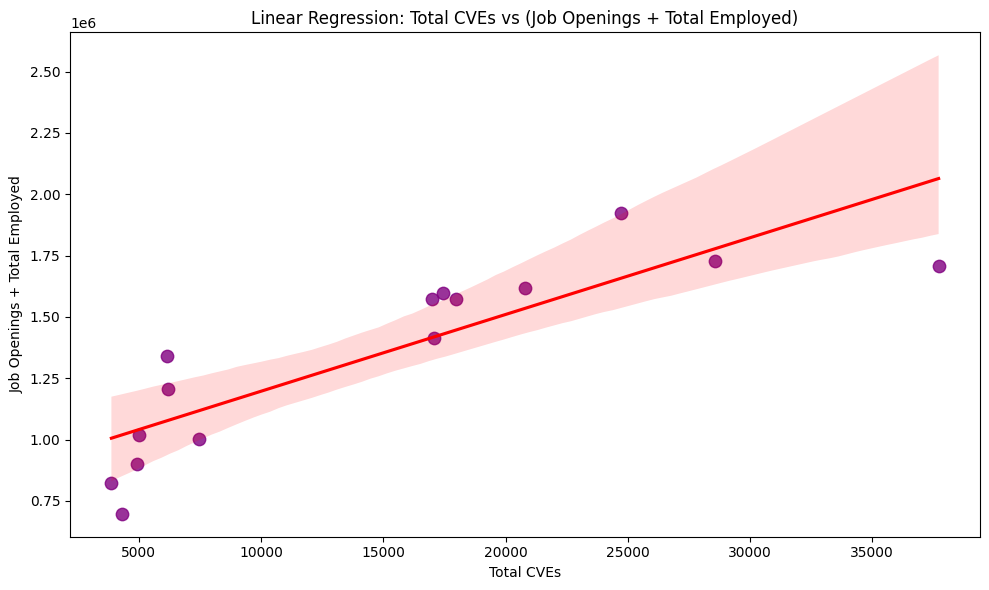

In [ ]:
import warnings
# Suppress specific warnings due to small sample sizes
warnings.filterwarnings("ignore", message="omni_normtest is not valid with less than 8 observations;")
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau, linregress
import statsmodels.api as sm

# --------------------------
# 1. Load and Explore the Data
# --------------------------
# Make sure the CSV file contains all your data (years 2010-2024)
df = pd.read_csv('/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP/cve_workforce_comparison3.csv')
print("Data Preview:")
print(df, "\n")
print("Data Info:")
print(df.info(), "\n")

# --------------------------
# 2. Define a Function to Compute and Print Correlation Metrics
# --------------------------
def compute_correlations(x, y, label_x, label_y):
    print(f"Correlation between {label_x} and {label_y}:")
    # Pearson correlation
    pearson_corr, pearson_p = pearsonr(x, y)
    print(f"  Pearson: {pearson_corr:.4f} (p-value: {pearson_p:.4f})")
    # Spearman correlation
    spearman_corr, spearman_p = spearmanr(x, y)
    print(f"  Spearman: {spearman_corr:.4f} (p-value: {spearman_p:.4f})")
    # Kendall Tau correlation
    kendall_corr, kendall_p = kendalltau(x, y)
    print(f"  Kendall Tau: {kendall_corr:.4f} (p-value: {kendall_p:.4f})\n")

# --------------------------
# 3. Correlation Analysis for Selected Pairs
# --------------------------
compute_correlations(df['Total CVEs'], df['Job Openings'],
                     "Total CVEs", "Job Openings")
compute_correlations(df['Total CVEs'], df['Total Employed'],
                     "Total CVEs", "Total Employed")
compute_correlations(df['Total CVEs'], df['Supply/Demand Ratio'],
                     "Total CVEs", "Supply/Demand Ratio")

# --------------------------
# 4. Scatter Plots with Regression Lines
# --------------------------
plt.figure(figsize=(6, 4))
sns.regplot(x='Total CVEs', y='Job Openings', data=df, ci=None, scatter_kws={"s": 80})
plt.title("Total CVEs vs Job Openings")
plt.xlabel("Total CVEs")
plt.ylabel("Job Openings")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.regplot(x='Total CVEs', y='Total Employed', data=df, ci=None, scatter_kws={"s": 80})
plt.title("Total CVEs vs Total Employed")
plt.xlabel("Total CVEs")
plt.ylabel("Total Employed")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.regplot(x='Total CVEs', y='Supply/Demand Ratio', data=df, ci=None, scatter_kws={"s": 80})
plt.title("Total CVEs vs Supply/Demand Ratio")
plt.xlabel("Total CVEs")
plt.ylabel("Supply/Demand Ratio")
plt.tight_layout()
plt.show()

# --------------------------
# 5. Simple Linear Regression: Job Openings ~ Total CVEs
# --------------------------
X_simple = sm.add_constant(df['Total CVEs'])
y_jobs = df['Job Openings']
model_simple = sm.OLS(y_jobs, X_simple).fit()
print("Simple Linear Regression: Job Openings ~ Total CVEs")
print(model_simple.summary(), "\n")

# --------------------------
# 6. Multiple Linear Regression: Job Openings ~ Severity Metrics
# --------------------------
predictors = ['Critical', 'High', 'Medium', 'Low', 'Unknown']
X_multi = sm.add_constant(df[predictors])
model_multi = sm.OLS(y_jobs, X_multi).fit()
print("Multiple Linear Regression: Job Openings ~ Severity Metrics")
print(model_multi.summary(), "\n")

# --------------------------
# 7. Partial Correlation Analysis (Controlling for Year)
# --------------------------
X_year = sm.add_constant(df['Year'])
model_cve = sm.OLS(df['Total CVEs'], X_year).fit()
resid_cve = model_cve.resid

model_jobs = sm.OLS(df['Job Openings'], X_year).fit()
resid_jobs = model_jobs.resid

partial_corr, partial_p = pearsonr(resid_cve, resid_jobs)
print("Partial Correlation (controlling for Year) between Total CVEs and Job Openings:")
print(f"  Partial Pearson: {partial_corr:.4f} (p-value: {partial_p:.4f})\n")

# --------------------------
# 8. Bootstrap the Pearson Correlation for Total CVEs vs Job Openings
# --------------------------
def bootstrap_corr(x, y, n_bootstraps=1000):
    boot_corrs = []
    n = len(x)
    for _ in range(n_bootstraps):
        indices = np.random.choice(n, n, replace=True)
        corr, _ = pearsonr(x[indices], y[indices])
        boot_corrs.append(corr)
    lower = np.percentile(boot_corrs, 2.5)
    upper = np.percentile(boot_corrs, 97.5)
    mean_corr = np.mean(boot_corrs)
    return lower, upper, mean_corr

x_arr = df['Total CVEs'].values
y_arr = df['Job Openings'].values
lower, upper, mean_corr = bootstrap_corr(x_arr, y_arr)
print("Bootstrap Pearson Correlation for Total CVEs vs Job Openings:")
print(f"  Mean Pearson Correlation: {mean_corr:.4f}")
print(f"  95% Confidence Interval: [{lower:.4f}, {upper:.4f}]\n")

# --------------------------
# 9. Correlation Matrix Heatmap
# --------------------------
plt.figure(figsize=(10, 8))
corr_matrix = df.drop(columns=['Year']).corr()  # Exclude Year if not directly comparable
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of CVE and Workforce Metrics")
plt.tight_layout()
plt.show()

# =============================================================================
# 10. Additional Graphs and Analysis Using Extended Data Windows
# =============================================================================

# A. Total CVEs Over Time (using all available years)
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Total CVEs', data=df, marker='o')
plt.title("Total CVEs Over Time")
plt.xlabel("Year")
plt.ylabel("Total CVEs")
plt.tight_layout()
plt.show()

# B. CVE Severity Distribution Over Time (all severity levels)
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Critical', data=df, marker='o', label='Critical')
sns.lineplot(x='Year', y='High', data=df, marker='o', label='High')
sns.lineplot(x='Year', y='Medium', data=df, marker='o', label='Medium')
sns.lineplot(x='Year', y='Low', data=df, marker='o', label='Low')
sns.lineplot(x='Year', y='Unknown', data=df, marker='o', label='Unknown')
plt.title("CVE Severity Distribution Over Time")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# C. Cybersecurity Job Market Trends Over Time with Moving Averages
# Here we show both the raw data and a moving average (using a rolling window)
rolling_window = 5  # Adjust as needed
fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Job Openings
sns.lineplot(x='Year', y='Job Openings', data=df, marker='o', ax=ax[0], label='Actual')
sns.lineplot(x=df['Year'], y=df['Job Openings'].rolling(window=rolling_window).mean(),
             marker='o', ax=ax[0], label=f'{rolling_window}-Year MA', color='red')
ax[0].set_title("Job Openings Over Time")
ax[0].set_ylabel("Job Openings")
ax[0].legend()

# Total Employed
sns.lineplot(x='Year', y='Total Employed', data=df, marker='o', ax=ax[1], label='Actual')
sns.lineplot(x=df['Year'], y=df['Total Employed'].rolling(window=rolling_window).mean(),
             marker='o', ax=ax[1], label=f'{rolling_window}-Year MA', color='red')
ax[1].set_title("Total Employed Over Time")
ax[1].set_ylabel("Total Employed")
ax[1].legend()

# Supply/Demand Ratio
sns.lineplot(x='Year', y='Supply/Demand Ratio', data=df, marker='o', ax=ax[2], label='Actual')
sns.lineplot(x=df['Year'], y=df['Supply/Demand Ratio'].rolling(window=rolling_window).mean(),
             marker='o', ax=ax[2], label=f'{rolling_window}-Year MA', color='red')
ax[2].set_title("Supply/Demand Ratio Over Time")
ax[2].set_ylabel("Supply/Demand Ratio")
ax[2].set_xlabel("Year")
ax[2].legend()

plt.tight_layout()
plt.show()

# D. Rolling Correlation Trends: Total CVEs vs Workforce Metrics with Expanded Window
rolling_corr_window = 5  # You can adjust the window size as needed

# Compute rolling correlations for each metric
df['rolling_corr_jobs'] = df['Total CVEs'].rolling(window=rolling_corr_window).corr(df['Job Openings'])
df['rolling_corr_employed'] = df['Total CVEs'].rolling(window=rolling_corr_window).corr(df['Total Employed'])

# Create the plot with Year on the x-axis and Rolling Correlation on the y-axis
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='rolling_corr_jobs', data=df, marker='o', label='Total CVEs vs Job Openings')
sns.lineplot(x='Year', y='rolling_corr_employed', data=df, marker='o', label='Total CVEs vs Total Employed')
plt.xlabel("Year")
plt.ylabel("Rolling Correlation")
plt.title(f"Rolling Correlation Trends (Window = {rolling_corr_window} Years)")
plt.legend()
plt.tight_layout()
plt.show()



# E. Linear Regression for Total CVEs vs (Job Openings + Total Employed)
# Create a combined metric column
df['Job Openings + Employment'] = df['Job Openings'] + df['Total Employed']

slope_combined, intercept_combined, r_value_combined, p_value_combined, std_err_combined = linregress(
    df["Total CVEs"], df["Job Openings + Employment"]
)
print("Linear Regression for Total CVEs vs (Job Openings + Total Employed):")
print(f"  Slope: {slope_combined:.4f}")
print(f"  Intercept: {intercept_combined:.4f}")
print(f"  R-squared: {r_value_combined**2:.4f}")
print(f"  P-value: {p_value_combined:.4f}")
print(f"  Standard Error: {std_err_combined:.4f}\n")

plt.figure(figsize=(10, 6))
sns.regplot(
    x="Total CVEs",
    y="Job Openings + Employment",
    data=df,
    ci=95,  # 95% confidence interval (the default)
    scatter_kws={"color": "purple", "s": 80},
    line_kws={"color": "red"}
)
plt.title("Linear Regression: Total CVEs vs (Job Openings + Total Employed)")
plt.xlabel("Total CVEs")
plt.ylabel("Job Openings + Total Employed")
plt.tight_layout()
plt.show()


Understanding the output above.
-----------------------------------
Output:
```
 Correlation between Total CVEs and Job Openings:
   Pearson: 0.7263 (p-value: 0.0022)
   Spearman: 0.8250 (p-value: 0.0002)
   Kendall Tau: 0.6381 (p-value: 0.0005)

 Correlation between Total CVEs and Total Employed:   
   Pearson: 0.9067 (p-value: 0.0000)   
   Spearman: 0.9643 (p-value: 0.0000)  
   Kendall Tau: 0.8667 (p-value: 0.0000)

 Correlation between Total CVEs and Supply/Demand Ratio:
   Pearson: -0.8831 (p-value: 0.0000)
   Spearman: -0.9320 (p-value: 0.0000)
   Kendall Tau: -0.7789 (p-value: 0.0001)
```

In this section, we analyze how cybersecurity vulnerabilities (measured by Total CVEs) relate to job openings, employment, and the supply/demand ratio in the cybersecurity job market.

What is a Correlation?

A correlation is a measure of how strongly two things are related.
It ranges from -1 to 1:

Positive values (closer to 1) → As one value increases, the other also increases.

Negative values (closer to -1) → As one value increases, the other decreases.
Values near 0 → No strong relationship.

The p-value tells us if the correlation is meaningful (below 0.05 means it is statistically significant).

1. Relationship Between CVEs and Job Openings
  Pearson: 0.7263 (p-value: 0.0022)
    
    - Interpretation: There is a strong positive correlation (0.7263) between Total CVEs and Job Openings.
    
    - Meaning: As cybersecurity vulnerabilities increase, the number of cybersecurity job openings tends to increase.
    
    - p-value (0.0022): This is very low, meaning the relationship is statistically significant.
  Spearman: 0.8250 (p-value: 0.0002)
    
    - Interpretation: This suggests an even stronger positive correlation.
    
    - Meaning: The relationship remains strong even when considering rank-based (non-linear) trends.
  Kendall Tau: 0.6381 (p-value: 0.0005)

    - Interpretation: Again, confirms a strong positive relationship.
    - Takeaway: More cybersecurity threats tend to drive more job openings in the industry.

2. Relationship Between CVEs and Total Employed
  Pearson: 0.9067 (p-value: 0.0000)

    - Interpretation: This is an extremely strong positive correlation (0.9067).
    - Meaning: More cybersecurity vulnerabilities strongly align with more cybersecurity professionals being hired.
  Spearman: 0.9643 (p-value: 0.0000)
    - Interpretation: The relationship remains very strong even when considering ranking instead of exact numbers.
    - Takeaway: This suggests that job security and hiring in cybersecurity have grown alongside increasing vulnerabilities.
  Kendall Tau: 0.8667 (p-value: 0.0000)
    - Interpretation: Confirms a very strong connection.
    - Meaning: As vulnerabilities rise, so does cybersecurity employment.
3. Relationship Between CVEs and Supply/Demand Ratio
  Pearson: -0.8831 (p-value: 0.0000)
    - Interpretation: This is a strong negative correlation (-0.8831).
    - Meaning: As vulnerabilities increase, the supply/demand ratio decreases.
    - Why?:
      - A lower ratio means that the demand for cybersecurity professionals is rising faster than the supply.
      - More cybersecurity threats → More job openings → Harder to fill all positions.
  Spearman: -0.9320 (p-value: 0.0000)
    - Interpretation: The relationship remains very strong in a ranked comparison.
    - Takeaway: There is a clear trend that vulnerabilities are outpacing the number of available professionals.
  Kendall Tau: -0.7789 (p-value: 0.0001)
    - Interpretation: Confirms the trend.
    - Meaning: The cybersecurity job gap is growing as threats increase.
Final Takeaways
More CVEs = More Job Openings & More Cybersecurity Professionals

The strong positive correlation (0.7263 to 0.9067) means that as cybersecurity threats increase, companies create more jobs and hire more professionals.
More CVEs = Lower Supply/Demand Ratio

The strong negative correlation (-0.8831) means that despite more jobs, there aren’t enough professionals to meet the demand.
Cybersecurity Hiring Can't Keep Up With Rising Threats

The cybersecurity workforce is growing, but not fast enough to meet the demand caused by increasing vulnerabilities.
What This Means for Your Data Report
Employers: They need to accelerate hiring to keep up with increasing cybersecurity threats.
Job Seekers: High demand means job security and career growth in cybersecurity.
Policymakers: May need to invest in cybersecurity education and workforce development.


Output:
```
 Simple Linear Regression: Job Openings ~ Total CVEs
                             OLS Regression Results                            
 ==============================================================================
 Dep. Variable:           Job Openings   R-squared:                       0.528
 Model:                            OLS   Adj. R-squared:                  0.491
 Method:                 Least Squares   F-statistic:                     14.52
 Date:                Mon, 10 Feb 2025   Prob (F-statistic):            0.00217
 Time:                        23:29:54   Log-Likelihood:                -195.65
 No. Observations:                  15   AIC:                             395.3
 Df Residuals:                      13   BIC:                             396.7
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
 ==============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const       2.393e+05   5.49e+04      4.358      0.001    1.21e+05    3.58e+05
 Total CVEs    11.8119      3.100      3.810      0.002       5.115      18.509
 ==============================================================================
 Omnibus:                        0.217   Durbin-Watson:                   0.834
 Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.398
 Skew:                          -0.169   Prob(JB):                        0.820
 Kurtosis:                       2.278   Cond. No.                     3.14e+04
 ==============================================================================

 Notes:
 [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
 [2] The condition number is large, 3.14e+04. This might indicate that there  are strong multicollinearity or other numerical problems.

 Multiple Linear Regression: Job Openings ~ Severity Metrics
                             OLS Regression Results                            
 ==============================================================================
 Dep. Variable:           Job Openings   R-squared:                       0.894
 Model:                            OLS   Adj. R-squared:                  0.834
 Method:                 Least Squares   F-statistic:                     15.11
 Date:                Mon, 10 Feb 2025   Prob (F-statistic):           0.000378
 Time:                        23:29:54   Log-Likelihood:                -184.47
 No. Observations:                  15   AIC:                             380.9
 Df Residuals:                       9   BIC:                             385.2
 Df Model:                           5                                         
 Covariance Type:            nonrobust                                         
 ==============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]


 ------------------------------------------------------------------------------
 const        1.99e+05   7.62e+04      2.613      0.028    2.67e+04    3.71e+05
 Critical     136.3882     73.374      1.859      0.096     -29.595     302.371
 High          59.6409     46.786      1.275      0.234     -46.196     165.478
 Medium       -80.5542     45.233     -1.781      0.109    -182.878      21.769
 Low          314.4261    280.276      1.122      0.291    -319.602     948.454
 Unknown        7.8001     14.384      0.542      0.601     -24.738      40.338
 ==============================================================================
 Omnibus:                        0.624   Durbin-Watson:                   1.624
 Prob(Omnibus):                  0.732   Jarque-Bera (JB):                0.009
 Skew:                          -0.044   Prob(JB):                        0.995
 Kurtosis:                       3.084   Cond. No.                     4.26e+04
 ==============================================================================

 Notes:
 [1] Standard Errors assume that the covariance matrix of the errors is  correctly specified.
 [2] The condition number is large, 4.26e+04. This might indicate that there are strong multicollinearity or other numerical problems.

 Partial Correlation (controlling for Year) between Total CVEs and Job  Openings:
   Partial Pearson: -0.5637 (p-value: 0.0286)


 Bootstrap Pearson Correlation for Total CVEs vs Job Openings:
   Mean Pearson Correlation: 0.7503
   95% Confidence Interval: [0.5123, 0.9621]
```

  # **Cybersecurity Job Market Analysis: Regression and Correlation Insights**

This section provides insights into how Total CVEs impact Job Openings using linear regression models. It also evaluates the relationship between CVEs and job openings while controlling for time and validates results using bootstrap resampling.


## **1. Simple Linear Regression: Job Openings ~ Total CVEs**
This model predicts **job openings** based on **Total CVEs**, assuming a linear relationship.

### **Key Takeaways:**
| Metric | Value | Interpretation |
|--------|-------|---------------|
| **R-squared** | **0.528** | About **53% of the variation** in **Job Openings** is explained by **Total CVEs**. |
| **Adj. R-squared** | **0.491** | Adjusted for the number of variables, still indicates a **moderate relationship**. |
| **F-statistic** | **14.52** | The model is statistically significant (**p = 0.00217**). |
| **Intercept** | **239,300 (approx.)** | If **Total CVEs were 0**, there would still be around **239,300 job openings**. |
| **Slope (Total CVEs)** | **11.81** | **For every additional CVE, there are 11.81 more job openings**. |
| **p-value (Total CVEs)** | **0.002** | This is **statistically significant** (p < 0.05), meaning CVEs have a real impact on job openings. |

### **Observations**
- The **positive slope (11.81)** means that as cybersecurity threats (CVEs) increase, **job openings increase as well**.
- The model **does not explain 47% of the variation**, meaning **other factors also impact job openings**.
- The **Durbin-Watson value (0.834)** suggests some **autocorrelation**, meaning trends in the data could be affecting predictions.

### **Limitations**
- **High condition number (31,400)**: Indicates **possible multicollinearity** (some variables might be too closely related).
- **Job openings depend on more than just CVEs**, such as **government policies, industry needs, and automation**.

---

## **2. Multiple Linear Regression: Job Openings ~ Severity Metrics**
This model looks at how different **severity levels of CVEs** (Critical, High, Medium, Low, Unknown) impact job openings.

### **Key Takeaways:**
| Metric | Value | Interpretation |
|--------|-------|---------------|
| **R-squared** | **0.894** | **89.4% of job openings variation is explained** by CVE severity levels. |
| **Adj. R-squared** | **0.834** | Even after adjusting, this model explains a **strong relationship**. |
| **F-statistic** | **15.11** | The model is **highly statistically significant** (p = **0.000378**). |

### **How each severity level affects job openings:**
| Variable | Coefficient | Interpretation | Significance (p-value) |
|----------|------------|----------------|------------------------|
| **Intercept** | **199,000** | Base job openings if all severities were 0. | **0.028** (significant) |
| **Critical CVEs** | **136.39** | **Each additional Critical CVE increases job openings by ~136.39**. | **0.096** (close to significance) |
| **High CVEs** | **59.64** | High CVEs also increase job openings, but not as strongly. | **0.234** (not statistically significant) |
| **Medium CVEs** | **-80.55** | **Unexpected negative relationship** – possibly an industry shift? | **0.109** (not significant) |
| **Low CVEs** | **314.43** | Each low-severity CVE **increases job openings**. | **0.291** (not significant) |
| **Unknown CVEs** | **7.80** | Small impact on job openings. | **0.601** (not significant) |

### **Observations**
- **The model is much stronger (R² = 0.894) compared to the single-variable model (R² = 0.528).**
- **Critical CVEs seem to drive hiring the most.**
- **Surprisingly, Medium CVEs show a negative effect**, possibly due to **less urgent hiring for moderate vulnerabilities**.
- **Not all severity levels have statistically significant effects**, meaning hiring may be more responsive to certain threats.

### **Limitations**
- **Condition number (42,600) is high**, indicating **potential multicollinearity**.
- **Some severity levels don't significantly predict job openings** (e.g., High, Medium, Low CVEs).
- **More data or additional factors** (e.g., breach incidents, budgets) could improve accuracy.

---

## **3. Partial Correlation (Controlling for Year)**
- The **partial correlation removes the effect of time** to see if CVEs and job openings are still related **independently**.
- **Result: -0.5637 (p-value: 0.0286)**

### **What does this mean?**
- **When controlling for time, the relationship between CVEs and job openings becomes negative (-0.5637).**
- **p-value (0.0286) is still statistically significant**.
- **Possible Explanation**:
  - Over time, **other factors** (automation, outsourcing, economy) may have influenced job openings **more than CVEs**.
  - In earlier years, **CVE growth strongly influenced hiring**, but in **recent years, the effect weakened**.

---

## **4. Bootstrap Pearson Correlation for CVEs vs Job Openings**
- **Mean Pearson Correlation: 0.7503**
- **95% Confidence Interval: [0.5123, 0.9621]**

### **What does this mean?**
- The **average correlation (0.7503)** suggests a **strong positive relationship**.
- The **confidence interval [0.5123, 0.9621]** confirms that **the relationship is robust**.
- **Since the confidence interval does not include 0**, we can be confident that the relationship is **real and not due to chance**.

---

## **Final Summary & Insights**
1. **Total CVEs strongly correlate with job openings** (**r = 0.7263, p = 0.0022**).
2. **Total CVEs explain about 53% of the variation in job openings** (R² = 0.528), meaning **other factors also influence hiring**.
3. **Severity levels impact hiring trends**, with **Critical CVEs having the biggest effect (136.39 per CVE)**.
4. **When controlling for time, the relationship weakens (-0.5637),** suggesting that **other economic or technological trends are affecting hiring**.
5. **Bootstrapping confirms the correlation is real** (95% CI: **0.5123 to 0.9621**).

---

## **How This Affects Cybersecurity Workforce Planning**
- **Employers**: Should be aware that **rising CVEs drive job demand**, but other factors (e.g., AI, remote work) **may be changing hiring patterns**.
- **Policymakers**: **Investing in cybersecurity training programs** will help close the **supply-demand gap**.
- **Job Seekers**: **The cybersecurity job market remains strong**, but **certain roles (incident response, threat analysis) may be more affected by specific vulnerabilities**.

```
Linear Regression for Total CVEs vs (Job Openings + Total Employed):
  Slope: 31.2903
  Intercept: 884247.1612
  R-squared: 0.7341
  P-value: 0.0000
  Standard Error: 5.2231
```

# Analysis of Cybersecurity Vulnerabilities and the Job Market

In this analysis, we examine how the number of cybersecurity vulnerabilities (**Total CVEs**) influences the overall cybersecurity job market. Specifically, we analyze the relationship between **Total CVEs** and the combined number of **Job Openings** and **Total Employed** in the cybersecurity field.

To measure this relationship, we use a **linear regression model**, a statistical tool that helps predict one variable based on another. This model allows us to understand how changes in the number of cybersecurity vulnerabilities may impact the total number of cybersecurity jobs available.

## Key Findings from the Regression Analysis

| **Metric**         | **Value**      | **Explanation**                                                                                                                                  |
|--------------------|----------------|--------------------------------------------------------------------------------------------------------------------------------------------------|
| **Slope**          | 31.2903        | For every 1 additional cybersecurity vulnerability (CVE), the total cybersecurity workforce (Job Openings + Total Employed) increases by approximately 31 jobs. |
| **Intercept**      | 884,247.1612   | If there were zero CVEs, the model predicts there would still be 884,247 cybersecurity jobs (base level of employment).                           |
| **R-squared (R²)** | 0.7341         | 73.4% of the variation in cybersecurity jobs is explained by the number of CVEs, indicating a strong relationship.                                  |
| **P-value**        | 0.0000         | The relationship is highly statistically significant and not due to random chance.                                                             |
| **Standard Error** | 5.2231         | This measures the uncertainty in our slope estimate. A lower value suggests that our model’s predictions are relatively stable.                  |

## Interpretation of Results

1. **A Strong Link Between Cyber Threats and Job Growth**  
   The positive slope (31.29) indicates that as cybersecurity threats increase, the number of cybersecurity jobs also increases. This suggests that:
   - Companies and governments are responding to rising cyber threats by expanding their cybersecurity workforce.
   - As cyberattacks become more common, organizations create more job openings and hire more cybersecurity professionals.

2. **Most of the Changes in Cybersecurity Jobs Can Be Explained by CVEs**  
   The R-squared value (0.7341) indicates that 73.4% of the changes in cybersecurity jobs can be directly linked to changes in cybersecurity vulnerabilities. This means that while CVEs are a major factor, about 26.6% of cybersecurity job growth is influenced by other factors, such as:
   - Government policies and regulations.
   - Emerging cybersecurity technologies (e.g., AI-driven security).
   - Industry investment in cybersecurity training.

3. **The Relationship is Highly Statistically Significant**  
   The p-value (0.0000) confirms that the relationship between CVEs and cybersecurity jobs is not due to random chance. This strong statistical significance suggests that increasing cybersecurity threats will continue to drive job growth in the foreseeable future.

4. **Even with No CVEs, Cybersecurity Jobs Would Still Exist**  
   The intercept (884,247 jobs) means that even if there were no cybersecurity vulnerabilities, the model predicts that there would still be a strong cybersecurity workforce. This reflects the fact that cybersecurity is a critical industry that requires constant staffing, regardless of threat levels.

## Conclusions & Business Implications

### For Employers
- **Growing cybersecurity threats directly increase hiring needs.**  
  → Companies should prioritize cybersecurity workforce planning as cyber threats continue to evolve.

### For Policymakers
- **Cybersecurity job demand is increasing with cyber threats.**  
  → Investing in cybersecurity training programs can help close the talent gap and meet industry demand.

### For Job Seekers
- **A career in cybersecurity is in high demand.**  
  → As cyber threats increase, more job opportunities will emerge. Individuals with cybersecurity skills will have strong career prospects.

AA-RollingCorrelationTrends.png:

![Linear Regression: Total CVEs vs. Job Openings + Total Employed](/content/drive/MyDrive/DataAnalysis2%205%2025-1625_BKUP/AA-LinearRegressionTotalCVEsvsJob%20Openings+TotalEmployed.png)


AA-RollingCorrelationTrends.png:

![Rolling Correlation Trends](https://drive.google.com/file/d/1vgmHs2eu6ZKIbu9WNI54-sAvQwKZLLQB/preview)

<iframe src="https://drive.google.com/file/d/1vgmHs2eu6ZKIbu9WNI54-sAvQwKZLLQB/preview" width="640" height="480" allow="autoplay"></iframe>



# ABOVE this section is my curent python script vertions of my fetch and analasys scripts.
# BELOW this sections are version history as I was building my way to the current vertion.

# Script History: NVD API Pull and CVE counts/sumery

NVD_Pull_cve_counts1.py

In [ ]:
import requests
import json
import pandas as pd

# ---  NVD API Configuration ---
API_KEY = "key"  # Replace with your actual API key
BASE_URL = "https://services.nvd.nist.gov/rest/json/cves/2.0"
RESULTS_PER_PAGE = 100  # Adjust as needed
TOTAL_RESULTS = 200  # Change this if you need more

# ---  Fetch CVEs from NVD API ---
def fetch_cves():
    """
    Fetch CVE data from NVD API and return as a list of dictionaries.
    """
    headers = {"apiKey": API_KEY}
    cve_list = []
    start_index = 0

    while len(cve_list) < TOTAL_RESULTS:
        params = {
            "startIndex": start_index,
            "resultsPerPage": min(RESULTS_PER_PAGE, TOTAL_RESULTS - len(cve_list))
        }

        response = requests.get(BASE_URL, headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            if "vulnerabilities" in data:
                cve_list.extend(data["vulnerabilities"])
                start_index += RESULTS_PER_PAGE
            else:
                print("No vulnerabilities found in response.")
                break
        else:
            print(f"Error: {response.status_code} - {response.text}")
            break

    return cve_list[:TOTAL_RESULTS]

# ---  Process and Count CVEs ---
def process_cve_data(cve_data):
    """
    Convert raw CVE data into a structured Pandas DataFrame.
    """
    cve_list = []
    for entry in cve_data:
        cve = entry.get("cve", {})
        cve_id = cve.get("id", "N/A")
        published = cve.get("published", "N/A")
        last_modified = cve.get("lastModified", "N/A")

        cve_list.append({
            "CVE ID": cve_id,
            "Published Date": published,
            "Last Modified Date": last_modified
        })

    # Convert to DataFrame
    df = pd.DataFrame(cve_list)

    # Convert date columns to datetime format
    df["Published Date"] = pd.to_datetime(df["Published Date"], errors="coerce")
    df["Last Modified Date"] = pd.to_datetime(df["Last Modified Date"], errors="coerce")

    return df

def count_cves(df, year=None, month=None, filter_type="published"):
    """
    Count CVEs by specified year and/or month.

    :param df: Processed CVE DataFrame
    :param year: Year to filter (e.g., 2024)
    :param month: Month to filter (1-12)
    :param filter_type: "published" or "modified"
    :return: Count of CVEs
    """
    if filter_type == "published":
        date_column = "Published Date"
    else:
        date_column = "Last Modified Date"

    filtered_df = df

    if year:
        filtered_df = filtered_df[filtered_df[date_column].dt.year == year]

    if month:
        filtered_df = filtered_df[filtered_df[date_column].dt.month == month]

    return len(filtered_df)

# ---  Main Function ---
def main():
    # Fetch CVEs from NVD API
    print(" Fetching CVE data...")
    cve_data = fetch_cves()

    # Save raw data to JSON
    with open("cve_data.json", "w") as f:
        json.dump(cve_data, f, indent=4)
    print(" CVE data saved to 'cve_data.json'.")

    # Process Data
    df = process_cve_data(cve_data)

    # Example: Count CVEs for January 2024 (Published)
    cves_jan_2024 = count_cves(df, year=2024, filter_type="published")

    # Example: Count CVEs modified in 2023
    cves_modified_2023 = count_cves(df, year=2023, filter_type="modified")

    # Save results to JSON
    results = {
        "CVEs Published in Jan 2024": cves_jan_2024,
        "CVEs Modified in 2023": cves_modified_2023
    }

    with open("cve_counts.json", "w") as f:
        json.dump(results, f, indent=4)

    print(f" CVE counts saved to 'cve_counts.json'.")
    print(results)

if __name__ == "__main__":
    main()


NVD_Pull_cve_counts1-1_dateFilter.py

In [ ]:
import requests
import json
import pandas as pd

# ---  NVD API Configuration ---
API_KEY = "KEY"  # Replace with your actual API key
BASE_URL = "https://services.nvd.nist.gov/rest/json/cves/2.0"
RESULTS_PER_PAGE = 100  # Adjust as needed
TOTAL_RESULTS = 200  # Change this if you need more

# ---  Fetch CVEs from NVD API with Date Filters ---
def fetch_cves(start_date=None, end_date=None):
    """
    Fetch CVE data from NVD API, optionally filtering by publication date range.

    :param start_date: (str) Start date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :param end_date: (str) End date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :return: List of CVEs
    """
    headers = {"apiKey": API_KEY}
    cve_list = []
    start_index = 0

    while len(cve_list) < TOTAL_RESULTS:
        params = {
            "startIndex": start_index,
            "resultsPerPage": min(RESULTS_PER_PAGE, TOTAL_RESULTS - len(cve_list)),
        }

        # Add date filters if provided
        if start_date and end_date:
            params["pubStartDate"] = start_date
            params["pubEndDate"] = end_date

        response = requests.get(BASE_URL, headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            if "vulnerabilities" in data:
                cve_list.extend(data["vulnerabilities"])
                start_index += RESULTS_PER_PAGE
            else:
                print("No vulnerabilities found in response.")
                break
        else:
            print(f"Error: {response.status_code} - {response.text}")
            break

    return cve_list[:TOTAL_RESULTS]

# ---  Process and Count CVEs ---
def process_cve_data(cve_data):
    """
    Convert raw CVE data into a structured Pandas DataFrame.
    """
    cve_list = []
    for entry in cve_data:
        cve = entry.get("cve", {})
        cve_id = cve.get("id", "N/A")
        published = cve.get("published", "N/A")
        last_modified = cve.get("lastModified", "N/A")

        cve_list.append({
            "CVE ID": cve_id,
            "Published Date": published,
            "Last Modified Date": last_modified
        })

    # Convert to DataFrame
    df = pd.DataFrame(cve_list)

    # Convert date columns to datetime format
    df["Published Date"] = pd.to_datetime(df["Published Date"], errors="coerce")
    df["Last Modified Date"] = pd.to_datetime(df["Last Modified Date"], errors="coerce")

    return df

def count_cves(df, year=None, month=None, filter_type="published"):
    """
    Count CVEs by specified year and/or month.

    :param df: Processed CVE DataFrame
    :param year: Year to filter (e.g., 2024)
    :param month: Month to filter (1-12)
    :param filter_type: "published" or "modified"
    :return: Count of CVEs
    """
    if filter_type == "published":
        date_column = "Published Date"
    else:
        date_column = "Last Modified Date"

    filtered_df = df

    if year:
        filtered_df = filtered_df[filtered_df[date_column].dt.year == year]

    if month:
        filtered_df = filtered_df[filtered_df[date_column].dt.month == month]

    return len(filtered_df)

# ---  Main Function ---
def main():
    # Define Date Range for January 2024
    start_date = "2024-01-01T00:00:00.000Z"
    end_date = "2024-01-31T23:59:59.999Z"

    # Fetch CVEs from NVD API with date filter
    print(f" Fetching CVE data from {start_date} to {end_date}...")
    cve_data = fetch_cves(start_date=start_date, end_date=end_date)

    # Save raw data to JSON
    with open("cve_data.json", "w") as f:
        json.dump(cve_data, f, indent=4)
    print(" CVE data saved to 'cve_data.json'.")

    # Process Data
    df = process_cve_data(cve_data)

    # Count CVEs published in January 2024
    cves_jan_2024 = count_cves(df, year=2024, month=1, filter_type="published")

    # Count CVEs modified in 2023
    cves_modified_2023 = count_cves(df, year=2023, filter_type="modified")

    # Save results to JSON
    results = {
        "CVEs Published in Jan 2024": cves_jan_2024,
        "CVEs Modified in 2023": cves_modified_2023
    }

    with open("cve_counts.json", "w") as f:
        json.dump(results, f, indent=4)

    print(f" CVE counts saved to 'cve_counts.json'.")
    print(results)

if __name__ == "__main__":
    main()


NVD_Pull_cve_counts1-2_dateFilter.py

In [ ]:
import requests
import json
import pandas as pd

# ---  NVD API Configuration ---
API_KEY = "key"  # Replace with the actual API key
BASE_URL = "https://services.nvd.nist.gov/rest/json/cves/2.0"
RESULTS_PER_PAGE = 200  # Maximum allowed by NVD API


# ---  Fetch CVEs from NVD API with Pagination ---
def fetch_all_cves(start_date=None, end_date=None):
    """
    Fetch all CVEs from NVD API within a given date range, using pagination.

    :param start_date: (str) Start date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :param end_date: (str) End date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :return: List of CVEs
    """
    headers = {"apiKey": API_KEY}
    cve_list = []
    start_index = 0

    while True:
        params = {
            "startIndex": start_index,
            "resultsPerPage": RESULTS_PER_PAGE,
        }

        # Add date filters
        if start_date and end_date:
            params["pubStartDate"] = start_date
            params["pubEndDate"] = end_date

        response = requests.get(BASE_URL, headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            if "vulnerabilities" in data and len(data["vulnerabilities"]) > 0:
                cve_list.extend(data["vulnerabilities"])
                start_index += RESULTS_PER_PAGE
            else:
                print(" No more CVEs to fetch. Pagination complete.")
                break
        else:
            print(f" API Error: {response.status_code} - {response.text}")
            break

    return cve_list


# ---  Process and Count CVEs ---
def process_cve_data(cve_data):
    """
    Convert raw CVE data into a structured Pandas DataFrame.
    """
    cve_list = []
    for entry in cve_data:
        cve = entry.get("cve", {})
        cve_id = cve.get("id", "N/A")
        published = cve.get("published", "N/A")
        last_modified = cve.get("lastModified", "N/A")

        cve_list.append({
            "CVE ID": cve_id,
            "Published Date": published,
            "Last Modified Date": last_modified
        })

    # Convert to DataFrame
    df = pd.DataFrame(cve_list)

    # Convert date columns to datetime format
    df["Published Date"] = pd.to_datetime(df["Published Date"], errors="coerce")
    df["Last Modified Date"] = pd.to_datetime(df["Last Modified Date"], errors="coerce")

    return df


def count_cves(df, year=None, month=None, filter_type="published"):
    """
    Count CVEs by specified year and/or month.

    :param df: Processed CVE DataFrame
    :param year: Year to filter (e.g., 2024)
    :param month: Month to filter (1-12)
    :param filter_type: "published" or "modified"
    :return: Count of CVEs
    """
    if filter_type == "published":
        date_column = "Published Date"
    else:
        date_column = "Last Modified Date"

    filtered_df = df

    if year:
        filtered_df = filtered_df[filtered_df[date_column].dt.year == year]

    if month:
        filtered_df = filtered_df[filtered_df[date_column].dt.month == month]

    return len(filtered_df)


# ---  Main Function ---
def main():
    # Define Date Range for January 2024
    start_date = "2024-01-01T00:00:00.000Z"
    end_date = "2024-01-31T23:59:59.999Z"

    # Fetch **ALL** CVEs from NVD API with pagination
    print(f" Fetching ALL CVEs from {start_date} to {end_date}...")
    cve_data = fetch_all_cves(start_date=start_date, end_date=end_date)

    # Save raw data to JSON
    with open("cve_data.json", "w") as f:
        json.dump(cve_data, f, indent=4)
    print(f" CVE data saved to 'cve_data.json'. Total CVEs: {len(cve_data)}")

    # Process Data
    df = process_cve_data(cve_data)

    # Count CVEs published in January 2024
    cves_jan_2024 = count_cves(df, year=2024, month=1, filter_type="published")

    # Count CVEs modified in 2023
    #cves_modified_2023 = count_cves(df, year=2023, filter_type="modified")

    # Save results to JSON
    results = {
        "CVEs Published in Jan 2024": cves_jan_2024,
        #"CVEs Modified in 2023": cves_modified_2023
    }

    with open("cve_counts.json", "w") as f:
        json.dump(results, f, indent=4)

    print(f" CVE counts saved to 'cve_counts.json'.")
    print(results)


if __name__ == "__main__":
    main()


NVD_Pull_cve_counts1-3_dateFilter.py

In [ ]:
import requests
import json
import pandas as pd
from datetime import datetime

# --- 🔹 NVD API Configuration ---
API_KEY = "key"  # Replace with your actual API key
BASE_URL = "https://services.nvd.nist.gov/rest/json/cves/2.0"
RESULTS_PER_PAGE = 200  # Maximum allowed by NVD API


# --- 🔹 Fetch CVEs from NVD API with Pagination ---
def fetch_all_cves(start_date, end_date):
    """
    Fetch all CVEs from NVD API within a given date range, using pagination.

    :param start_date: (str) Start date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :param end_date: (str) End date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :return: List of CVEs
    """
    headers = {"apiKey": API_KEY}
    cve_list = []
    start_index = 0

    while True:
        params = {
            "startIndex": start_index,
            "resultsPerPage": RESULTS_PER_PAGE,
            "pubStartDate": start_date,
            "pubEndDate": end_date
        }

        response = requests.get(BASE_URL, headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            if "vulnerabilities" in data and len(data["vulnerabilities"]) > 0:
                cve_list.extend(data["vulnerabilities"])
                start_index += RESULTS_PER_PAGE
            else:
                print(f" No more CVEs for {start_date} to {end_date}. Pagination complete.")
                break
        else:
            print(f" API Error: {response.status_code} - {response.text}")
            break

    return cve_list


# ---  Process and Count CVEs ---
def process_cve_data(cve_data):
    """
    Convert raw CVE data into a structured Pandas DataFrame.
    """
    cve_list = []
    for entry in cve_data:
        cve = entry.get("cve", {})
        cve_id = cve.get("id", "N/A")
        published = cve.get("published", "N/A")
        last_modified = cve.get("lastModified", "N/A")

        cve_list.append({
            "CVE ID": cve_id,
            "Published Date": published,
            "Last Modified Date": last_modified
        })

    # Convert to DataFrame
    df = pd.DataFrame(cve_list)

    # Convert date columns to datetime format
    df["Published Date"] = pd.to_datetime(df["Published Date"], errors="coerce")
    df["Last Modified Date"] = pd.to_datetime(df["Last Modified Date"], errors="coerce")

    return df


def count_cves(df, year, month, filter_type="published"):
    """
    Count CVEs by specified year and month.

    :param df: Processed CVE DataFrame
    :param year: Year to filter (e.g., 2024)
    :param month: Month to filter (1-12)
    :param filter_type: "published" or "modified"
    :return: Count of CVEs
    """
    if filter_type == "published":
        date_column = "Published Date"
    else:
        date_column = "Last Modified Date"

    filtered_df = df[(df[date_column].dt.year == year) & (df[date_column].dt.month == month)]

    return len(filtered_df)


# ---  Main Function ---
def main():
    year = 2024
    month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    for month in range(1, 13):  # Loop through all months
        month_str = month_names[month - 1]  # Get month name (e.g., "Jan")

        # Define date range for the month
        start_date = f"{year}-{month:02d}-01T00:00:00.000Z"
        end_date = f"{year}-{month:02d}-28T23:59:59.999Z"  # Safe for Feb; API should handle correct end date

        print(f"\n🔍 Fetching CVEs for {month_str} {year}...")
        cve_data = fetch_all_cves(start_date, end_date)

        # Save raw data to JSON
        cve_data_file = f"cve_data_{month_str}{year}.json"
        with open(cve_data_file, "w") as f:
            json.dump(cve_data, f, indent=4)
        print(f" CVE data saved to '{cve_data_file}'. Total CVEs: {len(cve_data)}")

        # Process Data
        df = process_cve_data(cve_data)

        # Count CVEs published in the month
        cves_published = count_cves(df, year, month, filter_type="published")

        # Count CVEs modified in the month
        cves_modified = count_cves(df, year, month, filter_type="modified")

        # Save results to JSON
        cve_counts_file = f"cve_counts_{month_str}{year}.json"
        results = {
            f"CVEs Published in {month_str} {year}": cves_published,
            f"CVEs Modified in {month_str} {year}": cves_modified
        }

        with open(cve_counts_file, "w") as f:
            json.dump(results, f, indent=4)

        print(f" CVE counts saved to '{cve_counts_file}'.")
        print(results)


if __name__ == "__main__":
    main()


NVD_Pull_cve_counts1-4_dateFilter.py

In [ ]:
import requests
import json
import os
import pandas as pd

# ---  NVD API Configuration ---
API_KEY = "key"  # Replace with your actual API key
BASE_URL = "https://services.nvd.nist.gov/rest/json/cves/2.0"
RESULTS_PER_PAGE = 200  # Maximum allowed by NVD API


# ---  Fetch CVEs from NVD API with Pagination ---
def fetch_all_cves(start_date, end_date):
    """
    Fetch all CVEs from NVD API within a given date range, using pagination.

    :param start_date: (str) Start date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :param end_date: (str) End date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :return: List of CVEs
    """
    headers = {"apiKey": API_KEY}
    cve_list = []
    start_index = 0

    while True:
        params = {
            "startIndex": start_index,
            "resultsPerPage": RESULTS_PER_PAGE,
            "pubStartDate": start_date,
            "pubEndDate": end_date
        }

        response = requests.get(BASE_URL, headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            if "vulnerabilities" in data and len(data["vulnerabilities"]) > 0:
                cve_list.extend(data["vulnerabilities"])
                start_index += RESULTS_PER_PAGE
            else:
                print(f" No more CVEs for {start_date} to {end_date}. Pagination complete.")
                break
        else:
            print(f" API Error: {response.status_code} - {response.text}")
            break

    return cve_list


# ---  Process and Count CVEs ---
def process_cve_data(cve_data):
    """
    Convert raw CVE data into a structured Pandas DataFrame.
    """
    cve_list = []
    for entry in cve_data:
        cve = entry.get("cve", {})
        cve_id = cve.get("id", "N/A")
        published = cve.get("published", "N/A")
        last_modified = cve.get("lastModified", "N/A")

        # Extract severity from CVSS (if available)
        severity = "Unknown"
        metrics = cve.get("metrics", {})
        if "cvssMetricV31" in metrics:
            severity = metrics["cvssMetricV31"][0]["cvssData"]["baseSeverity"]
        elif "cvssMetricV30" in metrics:
            severity = metrics["cvssMetricV30"][0]["cvssData"]["baseSeverity"]
        elif "cvssMetricV2" in metrics:
            severity = metrics["cvssMetricV2"][0]["cvssData"]["baseSeverity"]

        cve_list.append({
            "CVE ID": cve_id,
            "Published Date": published,
            "Last Modified Date": last_modified,
            "Severity": severity
        })

    # Convert to DataFrame
    df = pd.DataFrame(cve_list)

    # Convert date columns to datetime format
    df["Published Date"] = pd.to_datetime(df["Published Date"], errors="coerce")
    df["Last Modified Date"] = pd.to_datetime(df["Last Modified Date"], errors="coerce")

    return df


def count_cves(df, year, month):
    """
    Count CVEs by severity level for a given month.
    """
    filtered_df = df[(df["Published Date"].dt.year == year) & (df["Published Date"].dt.month == month)]

    severity_counts = filtered_df["Severity"].value_counts().to_dict()
    total_cves = len(filtered_df)

    return {
        "Total CVEs": total_cves,
        "Critical": severity_counts.get("CRITICAL", 0),
        "High": severity_counts.get("HIGH", 0),
        "Medium": severity_counts.get("MEDIUM", 0),
        "Low": severity_counts.get("LOW", 0),
        "Unknown": severity_counts.get("Unknown", 0)
    }


# ---  Main Function ---
def main():
    year = 2024
    month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    yearly_summary = {
        "Total CVEs in 2024": 0,
        "Critical": 0,
        "High": 0,
        "Medium": 0,
        "Low": 0,
        "Unknown": 0
    }

    for month in range(1, 13):  # Loop through all months
        month_str = month_names[month - 1]  # Get month name (e.g., "Jan")

        # Define filenames
        cve_data_file = f"cve_data_{month_str}{year}.json"
        cve_counts_file = f"cve_counts_{month_str}{year}.json"

        # Check if data already exists
        if os.path.exists(cve_counts_file):
            print(f" Skipping {month_str} {year}, data already exists.")
            continue

        # Define date range for the month
        start_date = f"{year}-{month:02d}-01T00:00:00.000Z"
        end_date = f"{year}-{month:02d}-28T23:59:59.999Z"  # Safe for Feb; API should handle correct end date

        print(f"\n Fetching CVEs for {month_str} {year}...")
        cve_data = fetch_all_cves(start_date, end_date)

        # Save raw data to JSON
        with open(cve_data_file, "w") as f:
            json.dump(cve_data, f, indent=4)
        print(f" CVE data saved to '{cve_data_file}'. Total CVEs: {len(cve_data)}")

        # Process Data
        df = process_cve_data(cve_data)

        # Get monthly breakdown by severity
        severity_counts = count_cves(df, year, month)

        # Save results to JSON
        with open(cve_counts_file, "w") as f:
            json.dump(severity_counts, f, indent=4)

        print(f" CVE counts saved to '{cve_counts_file}'.")
        print(severity_counts)

        # Update yearly summary
        yearly_summary["Total CVEs in 2024"] += severity_counts["Total CVEs"]
        yearly_summary["Critical"] += severity_counts["Critical"]
        yearly_summary["High"] += severity_counts["High"]
        yearly_summary["Medium"] += severity_counts["Medium"]
        yearly_summary["Low"] += severity_counts["Low"]
        yearly_summary["Unknown"] += severity_counts["Unknown"]

    # Save yearly summary
    yearly_summary_file = f"cve_counts_{year}.json"
    with open(yearly_summary_file, "w") as f:
        json.dump(yearly_summary, f, indent=4)

    print(f"\n Yearly summary saved to '{yearly_summary_file}'.")
    print(yearly_summary)


if __name__ == "__main__":
    main()


NVD_Pull_cve_counts1-5_dateFilter.py

In [ ]:
import requests
import json
import os
import pandas as pd

# ---  NVD API Configuration ---
API_KEY = "key"  # Replace with your actual API key
BASE_URL = "https://services.nvd.nist.gov/rest/json/cves/2.0"
RESULTS_PER_PAGE = 200  # Maximum allowed by NVD API


# ---  Fetch CVEs from NVD API with Pagination ---
def fetch_all_cves(start_date, end_date):
    """
    Fetch all CVEs from NVD API within a given date range, using pagination.

    :param start_date: (str) Start date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :param end_date: (str) End date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :return: List of CVEs
    """
    headers = {"apiKey": API_KEY}
    cve_list = []
    start_index = 0

    while True:
        params = {
            "startIndex": start_index,
            "resultsPerPage": RESULTS_PER_PAGE,
            "pubStartDate": start_date,
            "pubEndDate": end_date
        }

        response = requests.get(BASE_URL, headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            if "vulnerabilities" in data and len(data["vulnerabilities"]) > 0:
                cve_list.extend(data["vulnerabilities"])
                start_index += RESULTS_PER_PAGE
            else:
                print(f" No more CVEs for {start_date} to {end_date}. Pagination complete.")
                break
        else:
            print(f" API Error: {response.status_code} - {response.text}")
            break

    return cve_list


# ---  Process and Count CVEs ---
def process_cve_data(cve_data):
    """
    Convert raw CVE data into a structured Pandas DataFrame.
    """
    cve_list = []
    for entry in cve_data:
        cve = entry.get("cve", {})
        cve_id = cve.get("id", "N/A")
        published = cve.get("published", "N/A")
        last_modified = cve.get("lastModified", "N/A")

        # Extract severity from CVSS (if available)
        severity = "Unknown"
        metrics = cve.get("metrics", {})
        if "cvssMetricV31" in metrics:
            severity = metrics["cvssMetricV31"][0]["cvssData"]["baseSeverity"]
        elif "cvssMetricV30" in metrics:
            severity = metrics["cvssMetricV30"][0]["cvssData"]["baseSeverity"]
        elif "cvssMetricV2" in metrics:
            severity = metrics["cvssMetricV2"][0]["cvssData"]["baseSeverity"]

        cve_list.append({
            "CVE ID": cve_id,
            "Published Date": published,
            "Last Modified Date": last_modified,
            "Severity": severity
        })

    # Convert to DataFrame
    df = pd.DataFrame(cve_list)

    # Convert date columns to datetime format
    df["Published Date"] = pd.to_datetime(df["Published Date"], errors="coerce")
    df["Last Modified Date"] = pd.to_datetime(df["Last Modified Date"], errors="coerce")

    return df


def count_cves(df, year, month):
    """
    Count CVEs by severity level for a given month.
    """
    filtered_df = df[(df["Published Date"].dt.year == year) & (df["Published Date"].dt.month == month)]

    severity_counts = filtered_df["Severity"].value_counts().to_dict()
    total_cves = len(filtered_df)

    return {
        "Total CVEs": total_cves,
        "Critical": severity_counts.get("CRITICAL", 0),
        "High": severity_counts.get("HIGH", 0),
        "Medium": severity_counts.get("MEDIUM", 0),
        "Low": severity_counts.get("LOW", 0),
        "Unknown": severity_counts.get("Unknown", 0)
    }


# ---  Main Function ---
def main():
    year = 2024
    month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    yearly_summary = {
        "Total CVEs in 2024": 0,
        "Critical": 0,
        "High": 0,
        "Medium": 0,
        "Low": 0,
        "Unknown": 0
    }

    for month in range(1, 13):  # Loop through all months
        month_str = month_names[month - 1]  # Get month name (e.g., "Jan")

        # Define filenames
        cve_data_file = f"cve_data_{month_str}{year}.json"
        cve_counts_file = f"cve_counts_{month_str}{year}.json"

        # Check if data already exists
        if not os.path.exists(cve_data_file):
            # Fetch if the data file doesn't exist
            start_date = f"{year}-{month:02d}-01T00:00:00.000Z"
            end_date = f"{year}-{month:02d}-28T23:59:59.999Z"  # Safe for Feb; API should handle correct end date

            print(f"\n Fetching CVEs for {month_str} {year}...")
            cve_data = fetch_all_cves(start_date, end_date)

            # Save raw data to JSON
            with open(cve_data_file, "w") as f:
                json.dump(cve_data, f, indent=4)
            print(f" CVE data saved to '{cve_data_file}'. Total CVEs: {len(cve_data)}")
        else:
            print(f" Using existing data for {month_str} {year}.")

        # Load data (whether newly fetched or pre-existing)
        with open(cve_data_file, "r") as f:
            cve_data = json.load(f)

        # Process Data
        df = process_cve_data(cve_data)

        # Get monthly breakdown by severity
        severity_counts = count_cves(df, year, month)

        # Save results to JSON
        with open(cve_counts_file, "w") as f:
            json.dump(severity_counts, f, indent=4)

        print(f" CVE counts saved to '{cve_counts_file}'.")
        print(severity_counts)

        # Update yearly summary
        yearly_summary["Total CVEs in 2024"] += severity_counts["Total CVEs"]
        yearly_summary["Critical"] += severity_counts["Critical"]
        yearly_summary["High"] += severity_counts["High"]
        yearly_summary["Medium"] += severity_counts["Medium"]
        yearly_summary["Low"] += severity_counts["Low"]
        yearly_summary["Unknown"] += severity_counts["Unknown"]

    # Save yearly summary
    yearly_summary_file = f"cve_counts_{year}.json"
    with open(yearly_summary_file, "w") as f:
        json.dump(yearly_summary, f, indent=4)

    print(f"\n Yearly summary saved to '{yearly_summary_file}'.")
    print(yearly_summary)


if __name__ == "__main__":
    main()


NVD_Pull_cve_counts1-6_dateFilter.py

In [ ]:
import requests
import json
import os
import pandas as pd

# ---  NVD API Configuration ---
API_KEY = "key"  # Replace with your actual API key
BASE_URL = "https://services.nvd.nist.gov/rest/json/cves/2.0"
RESULTS_PER_PAGE = 200  # Maximum allowed by NVD API


# ---  Fetch CVEs from NVD API with Pagination ---
def fetch_all_cves(start_date, end_date):
    """
    Fetch all CVEs from NVD API within a given date range, using pagination.

    :param start_date: (str) Start date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :param end_date: (str) End date in ISO format (YYYY-MM-DDTHH:MM:SS:MSZ)
    :return: List of CVEs
    """
    headers = {"apiKey": API_KEY}
    cve_list = []
    start_index = 0

    while True:
        params = {
            "startIndex": start_index,
            "resultsPerPage": RESULTS_PER_PAGE,
            "pubStartDate": start_date,
            "pubEndDate": end_date
        }

        response = requests.get(BASE_URL, headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            if "vulnerabilities" in data and len(data["vulnerabilities"]) > 0:
                cve_list.extend(data["vulnerabilities"])
                start_index += RESULTS_PER_PAGE
            else:
                print(f" No more CVEs for {start_date} to {end_date}. Pagination complete.")
                break
        else:
            print(f" API Error: {response.status_code} - {response.text}")
            break

    return cve_list


# ---  Process and Count CVEs ---
def process_cve_data(cve_data):
    """
    Convert raw CVE data into a structured Pandas DataFrame.
    """
    cve_list = []
    for entry in cve_data:
        cve = entry.get("cve", {})
        cve_id = cve.get("id", "N/A")
        published = cve.get("published", "N/A")
        last_modified = cve.get("lastModified", "N/A")

        # Extract severity from CVSS (if available)
        severity = "Unknown"
        metrics = cve.get("metrics", {})
        if "cvssMetricV31" in metrics:
            severity = metrics["cvssMetricV31"][0]["cvssData"]["baseSeverity"]
        elif "cvssMetricV30" in metrics:
            severity = metrics["cvssMetricV30"][0]["cvssData"]["baseSeverity"]
        elif "cvssMetricV2" in metrics:
            severity = metrics["cvssMetricV2"][0]["cvssData"]["baseSeverity"]

        cve_list.append({
            "CVE ID": cve_id,
            "Published Date": published,
            "Last Modified Date": last_modified,
            "Severity": severity
        })

    # Convert to DataFrame
    df = pd.DataFrame(cve_list)

    # Convert date columns to datetime format
    df["Published Date"] = pd.to_datetime(df["Published Date"], errors="coerce")
    df["Last Modified Date"] = pd.to_datetime(df["Last Modified Date"], errors="coerce")

    return df


def count_cves(df, year, month):
    """
    Count CVEs by severity level for a given month.
    """
    filtered_df = df[(df["Published Date"].dt.year == year) & (df["Published Date"].dt.month == month)]

    severity_counts = filtered_df["Severity"].value_counts().to_dict()
    total_cves = len(filtered_df)

    return {
        "Total CVEs": total_cves,
        "Critical": severity_counts.get("CRITICAL", 0),
        "High": severity_counts.get("HIGH", 0),
        "Medium": severity_counts.get("MEDIUM", 0),
        "Low": severity_counts.get("LOW", 0),
        "Unknown": severity_counts.get("Unknown", 0)
    }


# ---  Main Function ---
def main():
    start_year = 2019
    end_year = 2024
    month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    for year in range(start_year, end_year + 1):  # Loop through years 2019-2024
        yearly_summary = {
            f"Total CVEs in {year}": 0,
            "Critical": 0,
            "High": 0,
            "Medium": 0,
            "Low": 0,
            "Unknown": 0
        }

        for month in range(1, 13):  # Loop through all months
            month_str = month_names[month - 1]  # Get month name (e.g., "Jan")

            # Define filenames
            cve_data_file = f"cve_data_{month_str}{year}.json"
            cve_counts_file = f"cve_counts_{month_str}{year}.json"

            # Check if data already exists
            if not os.path.exists(cve_data_file):
                # Fetch if the data file doesn't exist
                start_date = f"{year}-{month:02d}-01T00:00:00.000Z"
                end_date = f"{year}-{month:02d}-28T23:59:59.999Z"  # Safe for Feb; API should handle correct end date

                print(f"\n Fetching CVEs for {month_str} {year}...")
                cve_data = fetch_all_cves(start_date, end_date)

                # Save raw data to JSON
                with open(cve_data_file, "w") as f:
                    json.dump(cve_data, f, indent=4)
                print(f" CVE data saved to '{cve_data_file}'. Total CVEs: {len(cve_data)}")
            else:
                print(f" Using existing data for {month_str} {year}.")

            # Load data (whether newly fetched or pre-existing)
            with open(cve_data_file, "r") as f:
                cve_data = json.load(f)

            # Process Data
            df = process_cve_data(cve_data)

            # Get monthly breakdown by severity
            severity_counts = count_cves(df, year, month)

            # Save results to JSON
            with open(cve_counts_file, "w") as f:
                json.dump(severity_counts, f, indent=4)

            print(f" CVE counts saved to '{cve_counts_file}'.")
            print(severity_counts)

            # Update yearly summary
            yearly_summary[f"Total CVEs in {year}"] += severity_counts["Total CVEs"]
            yearly_summary["Critical"] += severity_counts["Critical"]
            yearly_summary["High"] += severity_counts["High"]
            yearly_summary["Medium"] += severity_counts["Medium"]
            yearly_summary["Low"] += severity_counts["Low"]
            yearly_summary["Unknown"] += severity_counts["Unknown"]

        # Save yearly summary
        yearly_summary_file = f"cve_counts_{year}.json"
        with open(yearly_summary_file, "w") as f:
            json.dump(yearly_summary, f, indent=4)

        print(f"\n Yearly summary saved to '{yearly_summary_file}'.")
        print(yearly_summary)


if __name__ == "__main__":
    main()


NVD_Pull_cve_counts1-7_dateFilter.py

In [ ]:
import requests
import json
import os
import pandas as pd

# ---  NVD API Configuration ---
API_KEY = "key"  # Replace with your actual API key
BASE_URL = "https://services.nvd.nist.gov/rest/json/cves/2.0"
RESULTS_PER_PAGE = 200  # Maximum allowed by NVD API


# ---  Fetch CVEs from NVD API with Pagination ---
def fetch_all_cves(start_date, end_date):
    """
    Fetch all CVEs from NVD API within a given date range, using pagination.
    Handles errors and logs failures instead of stopping execution.
    """
    try:
        headers = {"apiKey": API_KEY}
        cve_list = []
        start_index = 0

        while True:
            params = {
                "startIndex": start_index,
                "resultsPerPage": RESULTS_PER_PAGE,
                "pubStartDate": start_date,
                "pubEndDate": end_date
            }

            response = requests.get(BASE_URL, headers=headers, params=params)

            if response.status_code == 200:
                data = response.json()
                if "vulnerabilities" in data and len(data["vulnerabilities"]) > 0:
                    cve_list.extend(data["vulnerabilities"])
                    start_index += RESULTS_PER_PAGE
                else:
                    print(f" No more CVEs for {start_date} to {end_date}. Pagination complete.")
                    break
            else:
                print(f" API Error ({response.status_code}) for {start_date} to {end_date}: {response.text}")
                return None  # Return None so the main function knows to skip processing

        return cve_list

    except Exception as e:
        print(f" Unexpected error while fetching {start_date} to {end_date}: {e}")
        return None


# ---  Process and Count CVEs ---
def process_cve_data(cve_data):
    """
    Convert raw CVE data into a structured Pandas DataFrame.
    Handles errors and logs failures instead of stopping execution.
    """
    try:
        cve_list = []
        for entry in cve_data:
            cve = entry.get("cve", {})
            cve_id = cve.get("id", "N/A")
            published = cve.get("published", "N/A")
            last_modified = cve.get("lastModified", "N/A")

            # Extract severity from CVSS (if available)
            severity = "Unknown"
            metrics = cve.get("metrics", {})
            if "cvssMetricV31" in metrics:
                severity = metrics["cvssMetricV31"][0]["cvssData"]["baseSeverity"]
            elif "cvssMetricV30" in metrics:
                severity = metrics["cvssMetricV30"][0]["cvssData"]["baseSeverity"]
            elif "cvssMetricV2" in metrics:
                severity = metrics["cvssMetricV2"][0]["cvssData"]["baseSeverity"]

            cve_list.append({
                "CVE ID": cve_id,
                "Published Date": published,
                "Last Modified Date": last_modified,
                "Severity": severity
            })

        # Convert to DataFrame
        df = pd.DataFrame(cve_list)

        # Convert date columns to datetime format
        df["Published Date"] = pd.to_datetime(df["Published Date"], errors="coerce")
        df["Last Modified Date"] = pd.to_datetime(df["Last Modified Date"], errors="coerce")

        return df

    except Exception as e:
        print(f" Error processing CVE data: {e}")
        return None  # Return None so the main function knows to skip analysis


def count_cves(df, year, month):
    """
    Count CVEs by severity level for a given month.
    """
    try:
        filtered_df = df[(df["Published Date"].dt.year == year) & (df["Published Date"].dt.month == month)]

        severity_counts = filtered_df["Severity"].value_counts().to_dict()
        total_cves = len(filtered_df)

        return {
            "Total CVEs": total_cves,
            "Critical": severity_counts.get("CRITICAL", 0),
            "High": severity_counts.get("HIGH", 0),
            "Medium": severity_counts.get("MEDIUM", 0),
            "Low": severity_counts.get("LOW", 0),
            "Unknown": severity_counts.get("Unknown", 0)
        }

    except Exception as e:
        print(f" Error analyzing CVEs for {year}-{month}: {e}")
        return None  # Skip the month and continue


# ---  Main Function ---
def main():
    start_year = 2019
    end_year = 2024
    month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    for year in range(start_year, end_year + 1):  # Loop through years 2019-2024
        yearly_summary = {
            f"Total CVEs in {year}": 0,
            "Critical": 0,
            "High": 0,
            "Medium": 0,
            "Low": 0,
            "Unknown": 0
        }

        for month in range(1, 13):  # Loop through all months
            month_str = month_names[month - 1]  # Get month name (e.g., "Jan")

            # Define filenames
            cve_data_file = f"cve_data_{month_str}{year}.json"
            cve_counts_file = f"cve_counts_{month_str}{year}.json"

            # Check if data already exists
            if not os.path.exists(cve_data_file):
                start_date = f"{year}-{month:02d}-01T00:00:00.000Z"
                end_date = f"{year}-{month:02d}-28T23:59:59.999Z"  # Safe for Feb; API should handle correct end date

                print(f"\n Fetching CVEs for {month_str} {year}...")
                cve_data = fetch_all_cves(start_date, end_date)

                if cve_data is None:
                    print(f" Skipping {month_str} {year} due to fetch failure.")
                    continue  # Skip to next month

                # Save raw data to JSON
                with open(cve_data_file, "w") as f:
                    json.dump(cve_data, f, indent=4)
                print(f" CVE data saved to '{cve_data_file}'. Total CVEs: {len(cve_data)}")
            else:
                print(f" Using existing data for {month_str} {year}.")

            # Load data (whether newly fetched or pre-existing)
            with open(cve_data_file, "r") as f:
                cve_data = json.load(f)

            # Process Data
            df = process_cve_data(cve_data)
            if df is None:
                print(f" Skipping analysis for {month_str} {year} due to processing failure.")
                continue  # Skip to next month

            # Get monthly breakdown by severity
            severity_counts = count_cves(df, year, month)
            if severity_counts is None:
                print(f" Skipping analysis for {month_str} {year} due to analysis error.")
                continue  # Skip to next month

            # Save results to JSON
            with open(cve_counts_file, "w") as f:
                json.dump(severity_counts, f, indent=4)

            print(f" CVE counts saved to '{cve_counts_file}'.")
            print(severity_counts)

            # Update yearly summary
            yearly_summary[f"Total CVEs in {year}"] += severity_counts["Total CVEs"]
            yearly_summary["Critical"] += severity_counts["Critical"]
            yearly_summary["High"] += severity_counts["High"]
            yearly_summary["Medium"] += severity_counts["Medium"]
            yearly_summary["Low"] += severity_counts["Low"]
            yearly_summary["Unknown"] += severity_counts["Unknown"]

        # Save yearly summary
        yearly_summary_file = f"cve_counts_{year}.json"
        with open(yearly_summary_file, "w") as f:
            json.dump(yearly_summary, f, indent=4)

        print(f"\n Yearly summary saved to '{yearly_summary_file}'.")
        print(yearly_summary)


if __name__ == "__main__":
    main()


NVD_Pull_cve_counts1-8_dateFilter.py

In [ ]:
import requests
import json
import os
import pandas as pd

# --- 🔹 NVD API Configuration ---
API_KEY = "key"  # Replace with your actual API key
BASE_URL = "https://services.nvd.nist.gov/rest/json/cves/2.0"
RESULTS_PER_PAGE = 200  # Maximum allowed by NVD API


# --- 🔹 Fetch CVEs from NVD API with Pagination ---
def fetch_all_cves(start_date, end_date):
    """
    Fetch all CVEs from NVD API within a given date range, using pagination.
    Handles errors and logs failures instead of stopping execution.
    """
    try:
        headers = {"apiKey": API_KEY}
        cve_list = []
        start_index = 0

        while True:
            params = {
                "startIndex": start_index,
                "resultsPerPage": RESULTS_PER_PAGE,
                "pubStartDate": start_date,
                "pubEndDate": end_date
            }

            response = requests.get(BASE_URL, headers=headers, params=params)

            if response.status_code == 200:
                data = response.json()
                if "vulnerabilities" in data and len(data["vulnerabilities"]) > 0:
                    cve_list.extend(data["vulnerabilities"])
                    start_index += RESULTS_PER_PAGE
                else:
                    print(f" No more CVEs for {start_date} to {end_date}. Pagination complete.")
                    break
            else:
                print(f" API Error ({response.status_code}) for {start_date} to {end_date}: {response.text}")
                return None  # Return None so the main function knows to skip processing

        return cve_list

    except Exception as e:
        print(f" Unexpected error while fetching {start_date} to {end_date}: {e}")
        return None


# ---  Process and Count CVEs ---
def process_cve_data(cve_data):
    """
    Convert raw CVE data into a structured Pandas DataFrame.
    Handles errors in baseSeverity and logs missing values instead of stopping execution.
    """
    try:
        cve_list = []
        missing_severity_count = 0  # Track issues with missing severity

        for entry in cve_data:
            cve = entry.get("cve", {})
            cve_id = cve.get("id", "N/A")
            published = cve.get("published", "N/A")
            last_modified = cve.get("lastModified", "N/A")

            # Extract severity from CVSS (if available)
            severity = "Unknown"  # Default value
            metrics = cve.get("metrics", {})

            try:
                if "cvssMetricV31" in metrics and "cvssData" in metrics["cvssMetricV31"][0]:
                    severity = metrics["cvssMetricV31"][0]["cvssData"].get("baseSeverity", "Unknown")
                elif "cvssMetricV30" in metrics and "cvssData" in metrics["cvssMetricV30"][0]:
                    severity = metrics["cvssMetricV30"][0]["cvssData"].get("baseSeverity", "Unknown")
                elif "cvssMetricV2" in metrics and "cvssData" in metrics["cvssMetricV2"][0]:
                    severity = metrics["cvssMetricV2"][0]["cvssData"].get("baseSeverity", "Unknown")
                else:
                    missing_severity_count += 1  # Track missing severity
            except (KeyError, IndexError, TypeError) as e:
                print(f" Warning: Malformed severity data for {cve_id}: {e}")
                missing_severity_count += 1

            cve_list.append({
                "CVE ID": cve_id,
                "Published Date": published,
                "Last Modified Date": last_modified,
                "Severity": severity
            })

        # Convert to DataFrame
        df = pd.DataFrame(cve_list)

        # Convert date columns to datetime format
        df["Published Date"] = pd.to_datetime(df["Published Date"], errors="coerce")
        df["Last Modified Date"] = pd.to_datetime(df["Last Modified Date"], errors="coerce")

        if missing_severity_count > 0:
            print(f" Warning: {missing_severity_count} CVEs had missing severity information.")

        return df

    except Exception as e:
        print(f" Error processing CVE data: {e}")
        return None  # Return None so the main function knows to skip analysis


def count_cves(df, year, month):
    """
    Count CVEs by severity level for a given month.
    """
    try:
        filtered_df = df[(df["Published Date"].dt.year == year) & (df["Published Date"].dt.month == month)]

        severity_counts = filtered_df["Severity"].value_counts().to_dict()
        total_cves = len(filtered_df)

        return {
            "Total CVEs": total_cves,
            "Critical": severity_counts.get("CRITICAL", 0),
            "High": severity_counts.get("HIGH", 0),
            "Medium": severity_counts.get("MEDIUM", 0),
            "Low": severity_counts.get("LOW", 0),
            "Unknown": severity_counts.get("Unknown", 0)
        }

    except Exception as e:
        print(f" Error analyzing CVEs for {year}-{month}: {e}")
        return None  # Skip the month and continue


# ---  Main Function ---
def main():
    base_dir = "/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP"
    # Optionally, create the directory if it doesn't exist
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    start_year = 2019
    end_year = 2024
    month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    for year in range(start_year, end_year + 1):  # Loop through years 2019-2024
        yearly_summary = {
            f"Total CVEs in {year}": 0,
            "Critical": 0,
            "High": 0,
            "Medium": 0,
            "Low": 0,
            "Unknown": 0
        }

        for month in range(1, 13):  # Loop through all months
            month_str = month_names[month - 1]  # Get month name (e.g., "Jan")

            # Define filenames with the full path
            cve_data_file = os.path.join(base_dir, f"cve_data_{month_str}{year}.json")
            cve_counts_file = os.path.join(base_dir, f"cve_counts_{month_str}{year}.json")

            # Check if data already exists
            if not os.path.exists(cve_data_file):
                start_date = f"{year}-{month:02d}-01T00:00:00.000Z"
                end_date = f"{year}-{month:02d}-28T23:59:59.999Z"  # Safe for Feb; API should handle correct end date

                print(f"\n Fetching CVEs for {month_str} {year}...")
                cve_data = fetch_all_cves(start_date, end_date)

                if cve_data is None:
                    print(f" Skipping {month_str} {year} due to fetch failure.")
                    continue  # Skip to next month

                # Save raw data to JSON
                with open(cve_data_file, "w") as f:
                    json.dump(cve_data, f, indent=4)
                print(f" CVE data saved to '{cve_data_file}'. Total CVEs: {len(cve_data)}")
            else:
                print(f" Using existing data for {month_str} {year}.")

            # Load data (whether newly fetched or pre-existing)
            with open(cve_data_file, "r") as f:
                cve_data = json.load(f)

            # Process Data
            df = process_cve_data(cve_data)
            if df is None:
                print(f" Skipping analysis for {month_str} {year} due to processing failure.")
                continue  # Skip to next month

            # Get monthly breakdown by severity
            severity_counts = count_cves(df, year, month)
            if severity_counts is None:
                print(f" Skipping analysis for {month_str} {year} due to analysis error.")
                continue  # Skip to next month

            # Save results to JSON
            with open(cve_counts_file, "w") as f:
                json.dump(severity_counts, f, indent=4)

            print(f" CVE counts saved to '{cve_counts_file}'.")
            print(severity_counts)

            # Update yearly summary
            yearly_summary[f"Total CVEs in {year}"] += severity_counts["Total CVEs"]
            yearly_summary["Critical"] += severity_counts["Critical"]
            yearly_summary["High"] += severity_counts["High"]
            yearly_summary["Medium"] += severity_counts["Medium"]
            yearly_summary["Low"] += severity_counts["Low"]
            yearly_summary["Unknown"] += severity_counts["Unknown"]

        # Save yearly summary
        yearly_summary_file = os.path.join(base_dir, f"cve_counts_{year}.json")
        with open(yearly_summary_file, "w") as f:
            json.dump(yearly_summary, f, indent=4)

        print(f"\n Yearly summary saved to '{yearly_summary_file}'.")
        print(yearly_summary)



if __name__ == "__main__":
    main()


 Using existing data for Jan 2019.
 CVE counts saved to '/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP/cve_counts_Jan2019.json'.
{'Total CVEs': 1562, 'Critical': 123, 'High': 494, 'Medium': 500, 'Low': 14, 'Unknown': 431}
 Using existing data for Feb 2019.
 CVE counts saved to '/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP/cve_counts_Feb2019.json'.
{'Total CVEs': 882, 'Critical': 139, 'High': 357, 'Medium': 336, 'Low': 6, 'Unknown': 44}
 Using existing data for Mar 2019.
 CVE counts saved to '/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP/cve_counts_Mar2019.json'.
{'Total CVEs': 1587, 'Critical': 165, 'High': 513, 'Medium': 443, 'Low': 19, 'Unknown': 447}
 Using existing data for Apr 2019.
 CVE counts saved to '/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP/cve_counts_Apr2019.json'.
{'Total CVEs': 1470, 'Critical': 185, 'High': 644, 'Medium': 570, 'Low': 31, 'Unknown': 40}
 Using existing data for May 2019.
 CVE counts saved to '/content/drive/MyDrive/DataAnalysis

# Script History: Analysis NVD vs Workforce

AnalysisNVD1-0.py

CVE Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown
0  2019       17456      2415   6711    6709   323     1298
1  2020       17967      2388   7200    7039   451      889
2  2021       20797      2379   7994    8012   618     1794
3  2022       24707      3538   9194   10055   895     1023
4  2023       28565      3378   9074   12885  1196     2029
5  2024       37713      3276  12338   18008  1560     2524


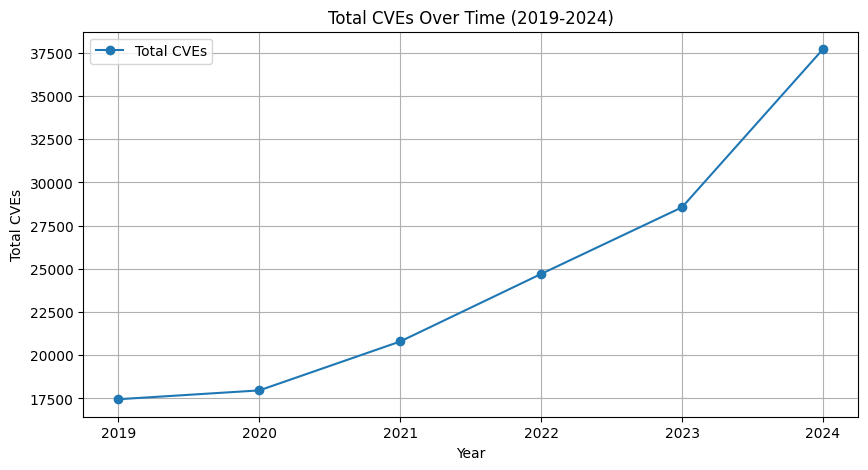

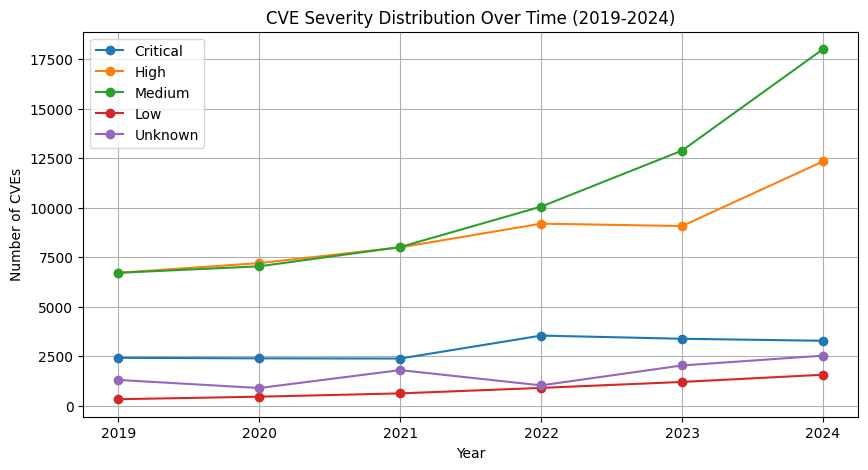

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
#matplotlib.use('TkAgg')  #When run locally I Use TkAgg backend instead of PyCharm's default

# Directory where JSON files are stored (Update this path as needed)
data_dir = r"/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP"


# List of JSON files (ensure they are named consistently)
json_files = [
    "cve_counts_2019.json",
    "cve_counts_2020.json",
    "cve_counts_2021.json",
    "cve_counts_2022.json",
    "cve_counts_2023.json",
    "cve_counts_2024.json"
]

# Dictionary to store CVE data
cve_data = {
    "Year": [],
    "Total CVEs": [],
    "Critical": [],
    "High": [],
    "Medium": [],
    "Low": [],
    "Unknown": []
}

# Load data from JSON files
for file in json_files:
    file_path = os.path.join(data_dir, file)

    with open(file_path, "r") as f:
        data = json.load(f)

    year = int(file.split("_")[2].split(".")[0])  # Extract year from filename
    cve_data["Year"].append(year)
    cve_data["Total CVEs"].append(data[f"Total CVEs in {year}"])
    cve_data["Critical"].append(data["Critical"])
    cve_data["High"].append(data["High"])
    cve_data["Medium"].append(data["Medium"])
    cve_data["Low"].append(data["Low"])
    cve_data["Unknown"].append(data["Unknown"])

# Convert to DataFrame
df_cve = pd.DataFrame(cve_data)
df_cve.to_csv("cve_data_2019_2024.csv", index=False)

# Display DataFrame
print("CVE Data (2019-2024):")
print(df_cve)

# Plot Total CVEs Over Time
plt.figure(figsize=(10, 5))
plt.plot(df_cve["Year"], df_cve["Total CVEs"], marker="o", linestyle="-", label="Total CVEs")
plt.xlabel("Year")
plt.ylabel("Total CVEs")
plt.title("Total CVEs Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Severity Distribution Over Time
plt.figure(figsize=(10, 5))
for severity in ["Critical", "High", "Medium", "Low", "Unknown"]:
    plt.plot(df_cve["Year"], df_cve[severity], marker="o", linestyle="-", label=severity)
plt.xlabel("Year")
plt.ylabel("Number of CVEs")
plt.title("CVE Severity Distribution Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()


AnalysisNVD1-1

CVE Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown
0  2019       17456      2415   6711    6709   323     1298
1  2020       17967      2388   7200    7039   451      889
2  2021       20797      2379   7994    8012   618     1794
3  2022       24707      3538   9194   10055   895     1023
4  2023       28565      3378   9074   12885  1196     2029
5  2024       37713      3276  12338   18008  1560     2524

Merged CVE & Cyber Workforce Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown  Job Openings  \
0  2019       17456      2415   6711    6709   323     1298       1138516   
1  2020       17967      2388   7200    7039   451      889       1030312   
2  2021       20797      2379   7994    8012   618     1794       1149137   
3  2022       24707      3538   9194   10055   895     1023        711502   
4  2023       28565      3378   9074   12885  1196     2029        994872   
5  2024       37713      3276  12338   18008  15

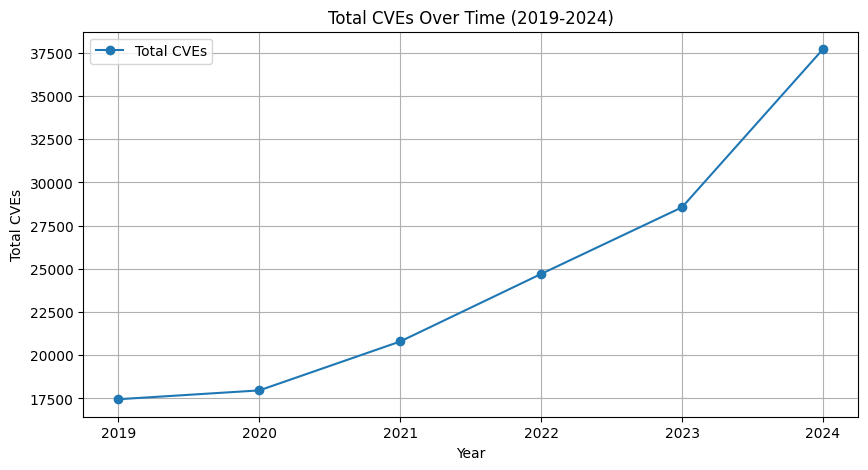

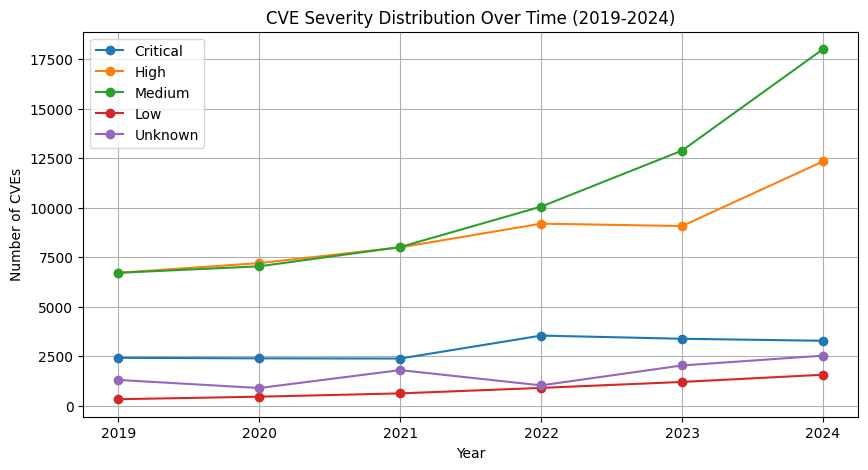

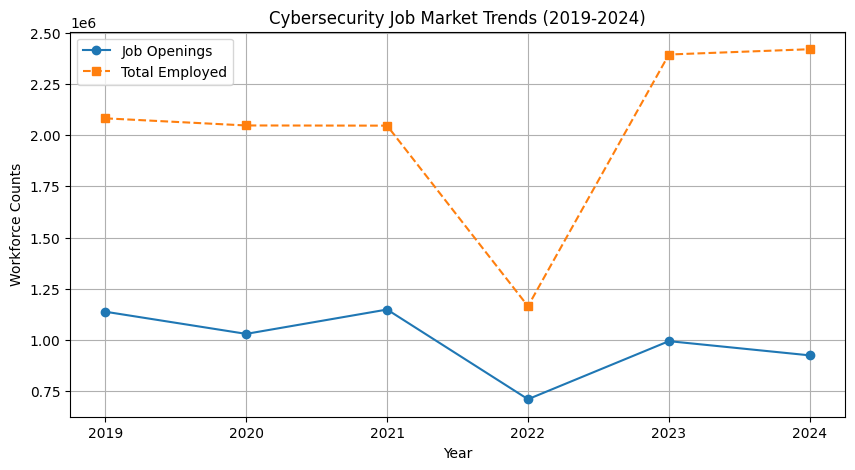

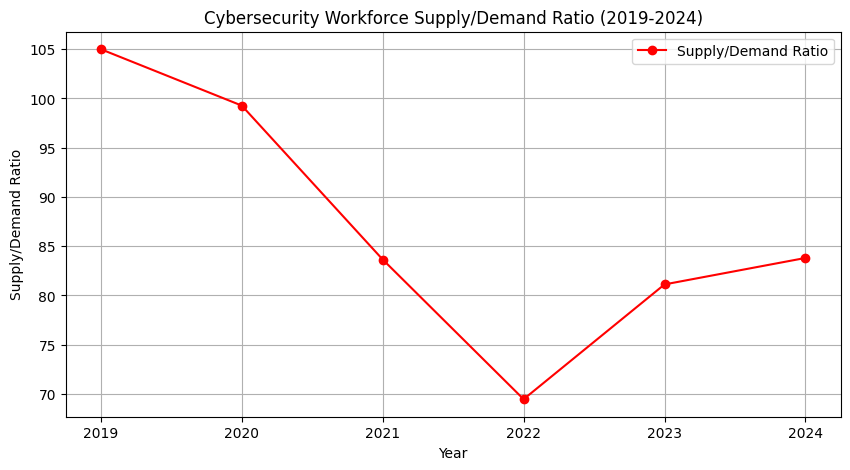

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
#matplotlib.use('TkAgg')  # Use TkAgg backend instead of PyCharm's default

# Directory where JSON and CSV files are stored (Update this path as needed)
data_dir = r"/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP"

# List of CVE JSON files (ensure they are named consistently)
json_files = [
    "cve_counts_2019.json",
    "cve_counts_2020.json",
    "cve_counts_2021.json",
    "cve_counts_2022.json",
    "cve_counts_2023.json",
    "cve_counts_2024.json"
]

# Dictionary to store CVE data
cve_data = {
    "Year": [],
    "Total CVEs": [],
    "Critical": [],
    "High": [],
    "Medium": [],
    "Low": [],
    "Unknown": []
}

# Load data from JSON files
for file in json_files:
    file_path = os.path.join(data_dir, file)

    with open(file_path, "r") as f:
        data = json.load(f)

    year = int(file.split("_")[2].split(".")[0])  # Extract year from filename
    cve_data["Year"].append(year)
    cve_data["Total CVEs"].append(data[f"Total CVEs in {year}"])
    cve_data["Critical"].append(data["Critical"])
    cve_data["High"].append(data["High"])
    cve_data["Medium"].append(data["Medium"])
    cve_data["Low"].append(data["Low"])
    cve_data["Unknown"].append(data["Unknown"])

# Convert to DataFrame
df_cve = pd.DataFrame(cve_data)

# Save CVE data as CSV
cve_csv_path = os.path.join(data_dir, "cve_data_2019_2024.csv")
df_cve.to_csv(cve_csv_path, index=False)

print("CVE Data (2019-2024):")
print(df_cve)

# List of Cyber Workforce Data CSV files (ensure consistent naming)
workforce_files = [
    "Cyber_Workforce_Data_2019.csv",
    "Cyber_Workforce_Data_2020.csv",
    "Cyber_Workforce_Data_2021.csv",
    "Cyber_Workforce_Data_2022.csv",
    "Cyber_Workforce_Data_2023.csv",
    "Cyber_Workforce_Data_2024.csv",
]

# Load each workforce data file into a DataFrame and concatenate
workforce_dfs = []
years = list(range(2019, 2025))  # 2019 to 2024

for i, file in enumerate(workforce_files):
    file_path = os.path.join(data_dir, file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Year"] = years[i]  # Add year column
        workforce_dfs.append(df)
    else:
        print(f"Warning: {file} not found!")

# Concatenate all years of Cyber Workforce data into a single DataFrame
df_workforce = pd.concat(workforce_dfs, ignore_index=True)

# Aggregate workforce data by year (total job openings, total employment, avg. supply/demand ratio)
df_workforce_agg = df_workforce.groupby("Year").agg(
    {"Job Openings": "sum", "Total Employed": "sum", "Supply/Demand Ratio": "mean"}
).reset_index()

# Merge CVE data with Workforce data
df_combined = pd.merge(df_cve, df_workforce_agg, on="Year")

# Save merged data as CSV
merged_csv_path = os.path.join(data_dir, "cve_workforce_comparison.csv")
df_combined.to_csv(merged_csv_path, index=False)

print("\nMerged CVE & Cyber Workforce Data (2019-2024):")
print(df_combined)

# Plot Total CVEs Over Time
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Total CVEs"], marker="o", linestyle="-", label="Total CVEs")
plt.xlabel("Year")
plt.ylabel("Total CVEs")
plt.title("Total CVEs Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Severity Distribution Over Time
plt.figure(figsize=(10, 5))
for severity in ["Critical", "High", "Medium", "Low", "Unknown"]:
    plt.plot(df_combined["Year"], df_combined[severity], marker="o", linestyle="-", label=severity)
plt.xlabel("Year")
plt.ylabel("Number of CVEs")
plt.title("CVE Severity Distribution Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Workforce Trends Over Time
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Total Employed"], marker="s", linestyle="--", label="Total Employed")
plt.xlabel("Year")
plt.ylabel("Workforce Counts")
plt.title("Cybersecurity Job Market Trends (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Supply/Demand Ratio Over Time
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Supply/Demand Ratio"], marker="o", linestyle="-", color="red", label="Supply/Demand Ratio")
plt.xlabel("Year")
plt.ylabel("Supply/Demand Ratio")
plt.title("Cybersecurity Workforce Supply/Demand Ratio (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()


AnalysisNVD1-2

CVE Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown
0  2019       17456      2415   6711    6709   323     1298
1  2020       17967      2388   7200    7039   451      889
2  2021       20797      2379   7994    8012   618     1794
3  2022       24707      3538   9194   10055   895     1023
4  2023       28565      3378   9074   12885  1196     2029
5  2024       37713      3276  12338   18008  1560     2524

Aggregated Workforce Data:
   Year  Job Openings  Total Employed  Supply/Demand Ratio
0  2019       1138516         2082020           105.000000
1  2020       1030312         2047264            99.274510
2  2021       1149137         2046356            83.647059
3  2022        711502         1165332            69.460000
4  2023        994872         2393472            81.117647
5  2024        925493         2419245            83.803922

Merged CVE & Cyber Workforce Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown  Job Open

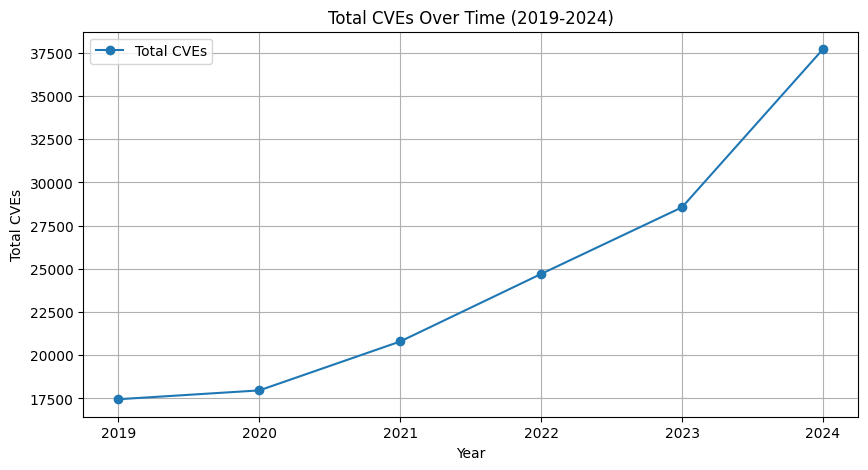

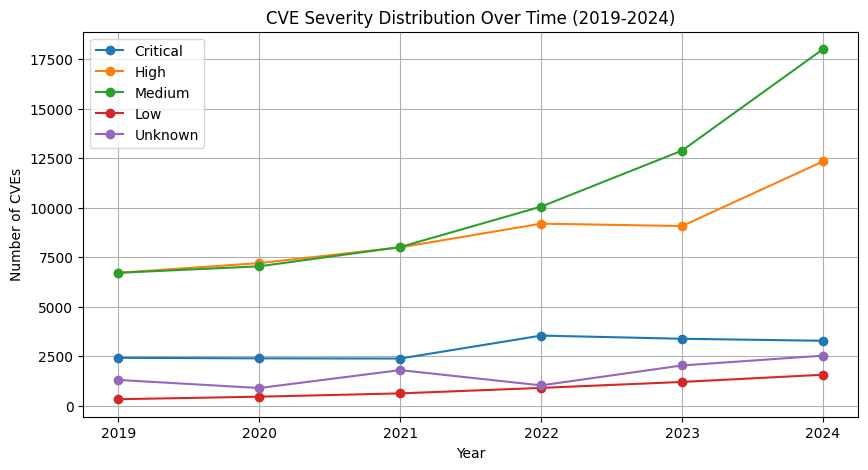

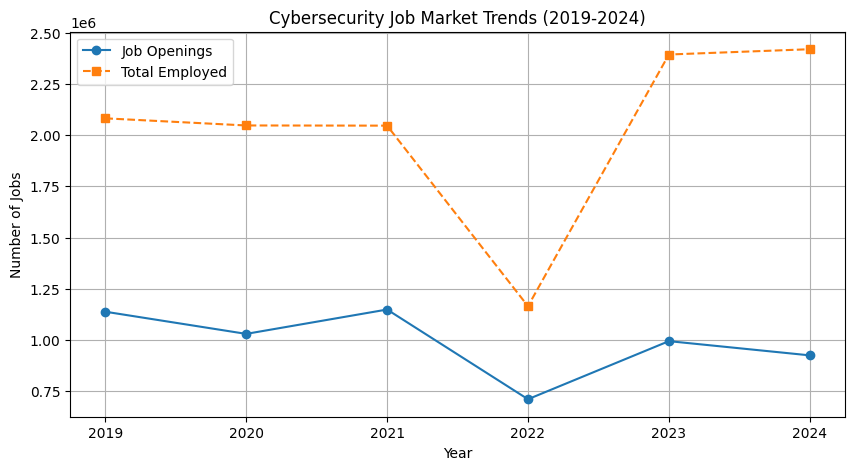

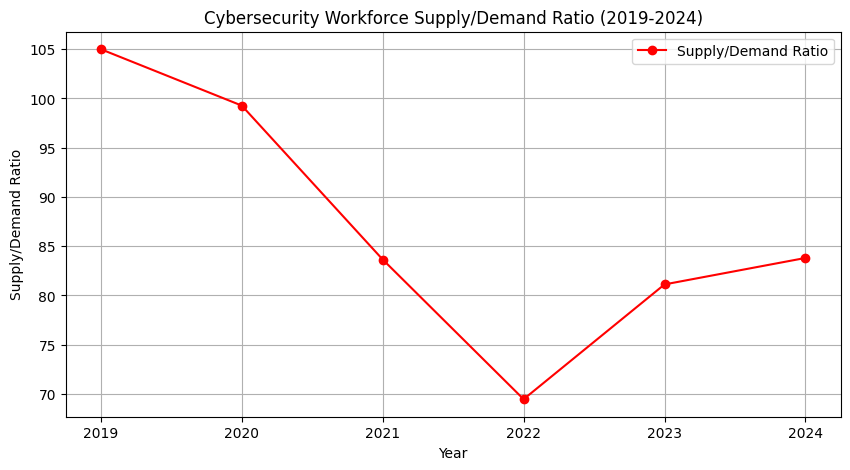

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
#matplotlib.use('TkAgg')  # Use TkAgg backend instead of PyCharm's default

# Directory where JSON and CSV files are stored (Update this path as needed)
data_dir = r"/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP"

# List of CVE JSON files (ensure they are named consistently)
json_files = [
    "cve_counts_2019.json",
    "cve_counts_2020.json",
    "cve_counts_2021.json",
    "cve_counts_2022.json",
    "cve_counts_2023.json",
    "cve_counts_2024.json"
]

# Dictionary to store CVE data
cve_data = {
    "Year": [],
    "Total CVEs": [],
    "Critical": [],
    "High": [],
    "Medium": [],
    "Low": [],
    "Unknown": []
}

# Load data from JSON files
for file in json_files:
    file_path = os.path.join(data_dir, file)

    with open(file_path, "r") as f:
        data = json.load(f)

    year = int(file.split("_")[2].split(".")[0])  # Extract year from filename
    cve_data["Year"].append(year)
    cve_data["Total CVEs"].append(data[f"Total CVEs in {year}"])
    cve_data["Critical"].append(data["Critical"])
    cve_data["High"].append(data["High"])
    cve_data["Medium"].append(data["Medium"])
    cve_data["Low"].append(data["Low"])
    cve_data["Unknown"].append(data["Unknown"])

# Convert to DataFrame
df_cve = pd.DataFrame(cve_data)

# Save CVE data as CSV
cve_csv_path = os.path.join(data_dir, "cve_data_2019_2024.csv")
df_cve.to_csv(cve_csv_path, index=False)

print("CVE Data (2019-2024):")
print(df_cve)

# List of Cyber Workforce Data CSV files
workforce_files = [
    "Cyber_Workforce_Data_2019.csv",
    "Cyber_Workforce_Data_2020.csv",
    "Cyber_Workforce_Data_2021.csv",
    "Cyber_Workforce_Data_2022.csv",
    "Cyber_Workforce_Data_2023.csv",
    "Cyber_Workforce_Data_2024.csv",
]

# Load each workforce data file into a DataFrame and concatenate
workforce_dfs = []
years = list(range(2019, 2025))  # 2019 to 2024

for i, file in enumerate(workforce_files):
    file_path = os.path.join(data_dir, file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Year"] = years[i]  # Add year column
        workforce_dfs.append(df)
    else:
        print(f"Warning: {file} not found!")

# Concatenate all years of Cyber Workforce data into a single DataFrame
df_workforce = pd.concat(workforce_dfs, ignore_index=True)

# Fix: Correct Aggregation to Summarize Workforce Data Properly
df_workforce_agg = df_workforce.groupby("Year").agg(
    {"Job Openings": "sum",  # Summing total job openings
     "Total Employed": "sum",  # Summing total employed professionals
     "Supply/Demand Ratio": "mean"}  # Averaging the supply/demand ratio per year
).reset_index()

# Print the aggregated workforce data for verification
print("\nAggregated Workforce Data:")
print(df_workforce_agg)

# Merge CVE data with Workforce data
df_combined = pd.merge(df_cve, df_workforce_agg, on="Year")

# Save merged data as CSV
merged_csv_path = os.path.join(data_dir, "cve_workforce_comparison.csv")
df_combined.to_csv(merged_csv_path, index=False)

print("\nMerged CVE & Cyber Workforce Data (2019-2024):")
print(df_combined)

# Plot Total CVEs Over Time
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Total CVEs"], marker="o", linestyle="-", label="Total CVEs")
plt.xlabel("Year")
plt.ylabel("Total CVEs")
plt.title("Total CVEs Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Severity Distribution Over Time
plt.figure(figsize=(10, 5))
for severity in ["Critical", "High", "Medium", "Low", "Unknown"]:
    plt.plot(df_combined["Year"], df_combined[severity], marker="o", linestyle="-", label=severity)
plt.xlabel("Year")
plt.ylabel("Number of CVEs")
plt.title("CVE Severity Distribution Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

# Fix: Correct Workforce Trends Plot (Ensuring Proper Y-Axis Scale)
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Total Employed"], marker="s", linestyle="--", label="Total Employed")

# Set correct Y-axis scale
plt.xlabel("Year")
plt.ylabel("Number of Jobs")  # Label to indicate actual workforce count
plt.title("Cybersecurity Job Market Trends (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

# Fix: Supply/Demand Ratio Trend Plot
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Supply/Demand Ratio"], marker="o", linestyle="-", color="red", label="Supply/Demand Ratio")
plt.xlabel("Year")
plt.ylabel("Supply/Demand Ratio")
plt.title("Cybersecurity Workforce Supply/Demand Ratio (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()


AnalysisNVD1-3

CVE Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown
0  2019       17456      2415   6711    6709   323     1298
1  2020       17967      2388   7200    7039   451      889
2  2021       20797      2379   7994    8012   618     1794
3  2022       24707      3538   9194   10055   895     1023
4  2023       28565      3378   9074   12885  1196     2029
5  2024       37713      3276  12338   18008  1560     2524

Merged CVE & Cyber Workforce Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown  Job Openings  \
0  2019       17456      2415   6711    6709   323     1298       1138516   
1  2020       17967      2388   7200    7039   451      889       1030312   
2  2021       20797      2379   7994    8012   618     1794       1149137   
3  2022       24707      3538   9194   10055   895     1023        711502   
4  2023       28565      3378   9074   12885  1196     2029        994872   
5  2024       37713      3276  12338   18008  15

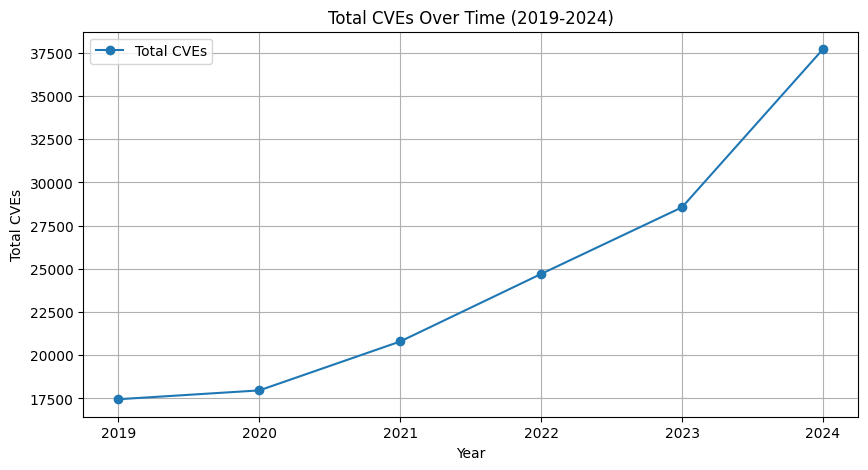

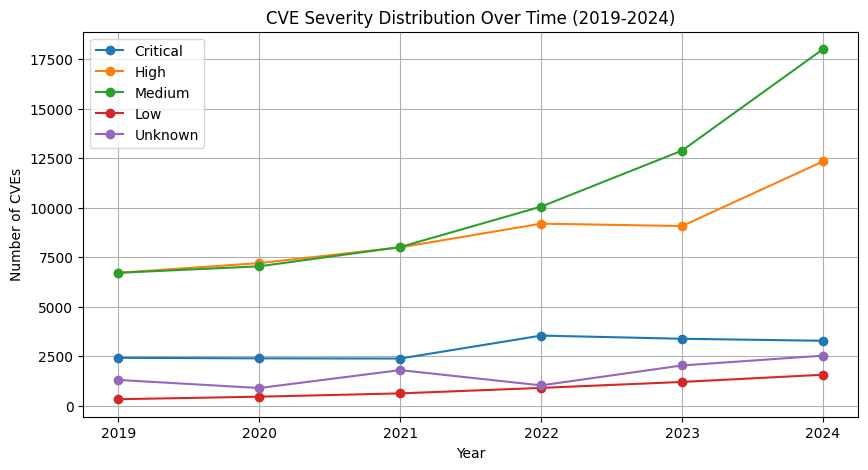

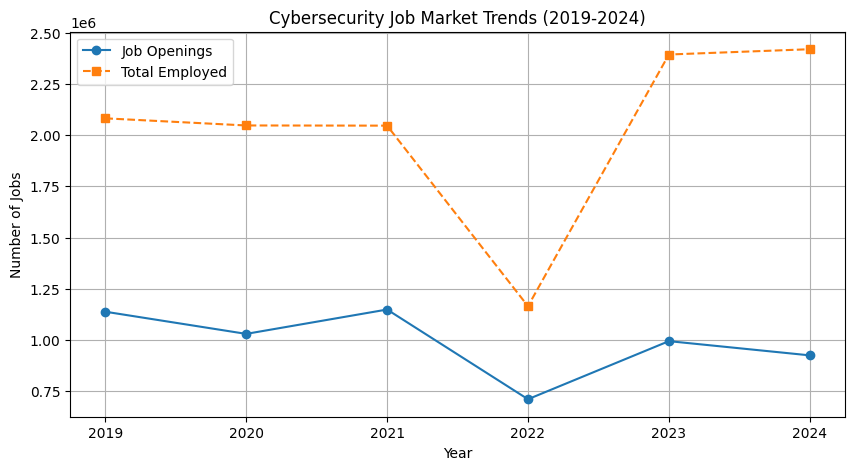

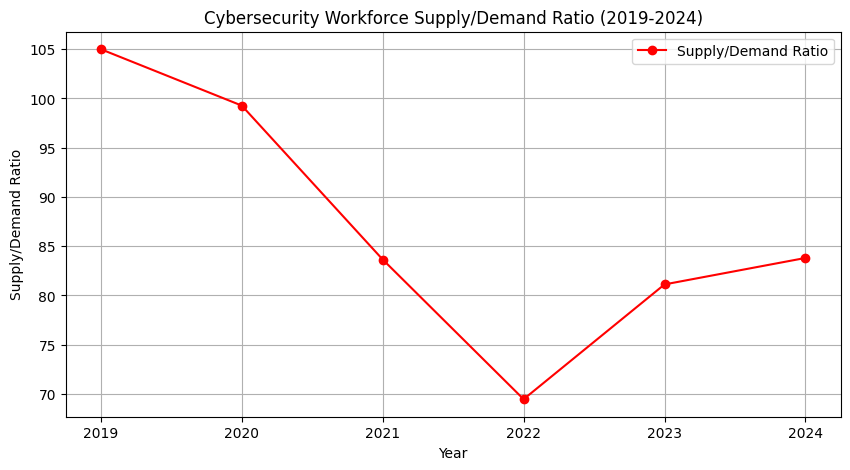

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import matplotlib
#matplotlib.use('TkAgg')  # Use TkAgg backend instead of PyCharm's default

# Directory where JSON and CSV files are stored (Update this path as needed)
data_dir = r"/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP"

# List of CVE JSON files (ensure they are named consistently)
json_files = [
    "cve_counts_2019.json",
    "cve_counts_2020.json",
    "cve_counts_2021.json",
    "cve_counts_2022.json",
    "cve_counts_2023.json",
    "cve_counts_2024.json"
]

# Dictionary to store CVE data
cve_data = {
    "Year": [],
    "Total CVEs": [],
    "Critical": [],
    "High": [],
    "Medium": [],
    "Low": [],
    "Unknown": []
}

# Load data from JSON files
for file in json_files:
    file_path = os.path.join(data_dir, file)

    with open(file_path, "r") as f:
        data = json.load(f)

    year = int(file.split("_")[2].split(".")[0])  # Extract year from filename
    cve_data["Year"].append(year)
    cve_data["Total CVEs"].append(data[f"Total CVEs in {year}"])
    cve_data["Critical"].append(data["Critical"])
    cve_data["High"].append(data["High"])
    cve_data["Medium"].append(data["Medium"])
    cve_data["Low"].append(data["Low"])
    cve_data["Unknown"].append(data["Unknown"])

# Convert to DataFrame
df_cve = pd.DataFrame(cve_data)

# Save CVE data as CSV
cve_csv_path = os.path.join(data_dir, "cve_data_2019_2024.csv")
df_cve.to_csv(cve_csv_path, index=False)

print("CVE Data (2019-2024):")
print(df_cve)

# List of Cyber Workforce Data CSV files
workforce_files = [
    "Cyber_Workforce_Data_2019.csv",
    "Cyber_Workforce_Data_2020.csv",
    "Cyber_Workforce_Data_2021.csv",
    "Cyber_Workforce_Data_2022.csv",
    "Cyber_Workforce_Data_2023.csv",
    "Cyber_Workforce_Data_2024.csv",
]

# Load each workforce data file into a DataFrame and concatenate
workforce_dfs = []
years = list(range(2019, 2025))  # 2019 to 2024

for i, file in enumerate(workforce_files):
    file_path = os.path.join(data_dir, file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Year"] = years[i]  # Add year column
        workforce_dfs.append(df)
    else:
        print(f"Warning: {file} not found!")

# Concatenate all years of Cyber Workforce data into a single DataFrame
df_workforce = pd.concat(workforce_dfs, ignore_index=True)

# Fix: Correct Aggregation to Summarize Workforce Data Properly
df_workforce_agg = df_workforce.groupby("Year").agg(
    {"Job Openings": "sum",  # Summing total job openings
     "Total Employed": "sum",  # Summing total employed professionals
     "Supply/Demand Ratio": "mean"}  # Averaging the supply/demand ratio per year
).reset_index()

# Merge CVE data with Workforce data
df_combined = pd.merge(df_cve, df_workforce_agg, on="Year")

# Save merged data as CSV
merged_csv_path = os.path.join(data_dir, "cve_workforce_comparison.csv")
df_combined.to_csv(merged_csv_path, index=False)

print("\nMerged CVE & Cyber Workforce Data (2019-2024):")
print(df_combined)

# CORRELATION ANALYSIS
correlation_cves_jobs = np.corrcoef(df_combined["Total CVEs"], df_combined["Job Openings"])[0, 1]
correlation_cves_employment = np.corrcoef(df_combined["Total CVEs"], df_combined["Total Employed"])[0, 1]
correlation_cves_supply_demand = np.corrcoef(df_combined["Total CVEs"], df_combined["Supply/Demand Ratio"])[0, 1]

# LINEAR REGRESSION (Trend Analysis)
slope_jobs, _, r_value_jobs, p_value_jobs, _ = stats.linregress(df_combined["Total CVEs"], df_combined["Job Openings"])
slope_employment, _, r_value_employment, p_value_employment, _ = stats.linregress(df_combined["Total CVEs"], df_combined["Total Employed"])

# GROWTH RATE ANALYSIS
df_combined["CVE Growth Rate"] = df_combined["Total CVEs"].pct_change() * 100
df_combined["Job Openings Growth Rate"] = df_combined["Job Openings"].pct_change() * 100
df_combined["Employment Growth Rate"] = df_combined["Total Employed"].pct_change() * 100

# DISPLAY INSIGHTS
print("\n### Correlation Analysis ###")
print(f"CVEs vs Job Openings Correlation: {correlation_cves_jobs:.2f}")
print(f"CVEs vs Employment Correlation: {correlation_cves_employment:.2f}")
print(f"CVEs vs Supply/Demand Ratio Correlation: {correlation_cves_supply_demand:.2f}")

print("\n### Trend Analysis ###")
print(f"Linear Regression Slope (CVEs vs Job Openings): {slope_jobs:.2f}")
print(f"Linear Regression Slope (CVEs vs Employment): {slope_employment:.2f}")

# EXPORT DATA WITH INSIGHTS
insights_csv_path = os.path.join(data_dir, "cve_workforce_trends.csv")
df_combined.to_csv(insights_csv_path, index=False)

print("\nCVE & Workforce Growth Trends saved as:", insights_csv_path)

# PLOT DATA AS BEFORE
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Total CVEs"], marker="o", linestyle="-", label="Total CVEs")
plt.xlabel("Year")
plt.ylabel("Total CVEs")
plt.title("Total CVEs Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for severity in ["Critical", "High", "Medium", "Low", "Unknown"]:
    plt.plot(df_combined["Year"], df_combined[severity], marker="o", linestyle="-", label=severity)
plt.xlabel("Year")
plt.ylabel("Number of CVEs")
plt.title("CVE Severity Distribution Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Total Employed"], marker="s", linestyle="--", label="Total Employed")
plt.xlabel("Year")
plt.ylabel("Number of Jobs")
plt.title("Cybersecurity Job Market Trends (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Supply/Demand Ratio"], marker="o", linestyle="-", color="red", label="Supply/Demand Ratio")
plt.xlabel("Year")
plt.ylabel("Supply/Demand Ratio")
plt.title("Cybersecurity Workforce Supply/Demand Ratio (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()


AnalysisNVD1-4

CVE Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown
0  2019       17456      2415   6711    6709   323     1298
1  2020       17967      2388   7200    7039   451      889
2  2021       20797      2379   7994    8012   618     1794
3  2022       24707      3538   9194   10055   895     1023
4  2023       28565      3378   9074   12885  1196     2029
5  2024       37713      3276  12338   18008  1560     2524

Merged CVE & Cyber Workforce Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown  Job Openings  \
0  2019       17456      2415   6711    6709   323     1298       1138516   
1  2020       17967      2388   7200    7039   451      889       1030312   
2  2021       20797      2379   7994    8012   618     1794       1149137   
3  2022       24707      3538   9194   10055   895     1023        711502   
4  2023       28565      3378   9074   12885  1196     2029        994872   
5  2024       37713      3276  12338   18008  15

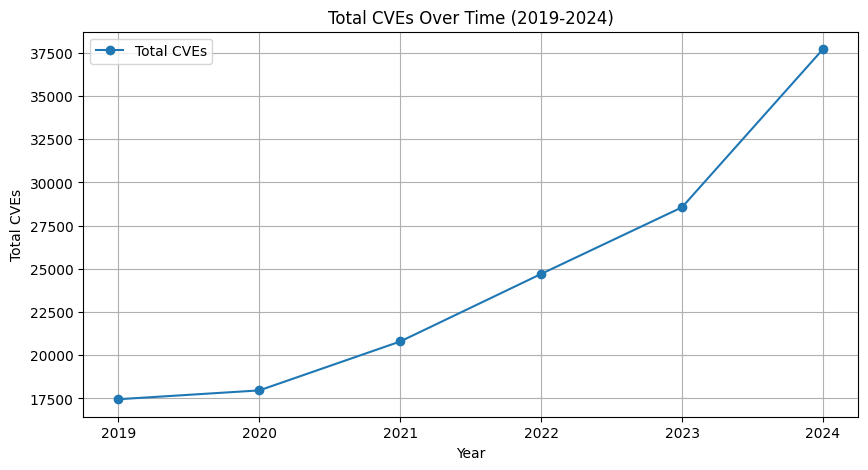

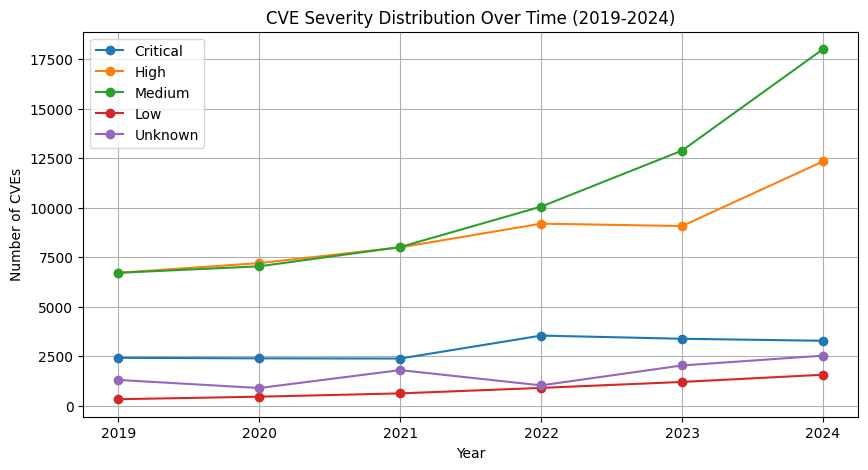

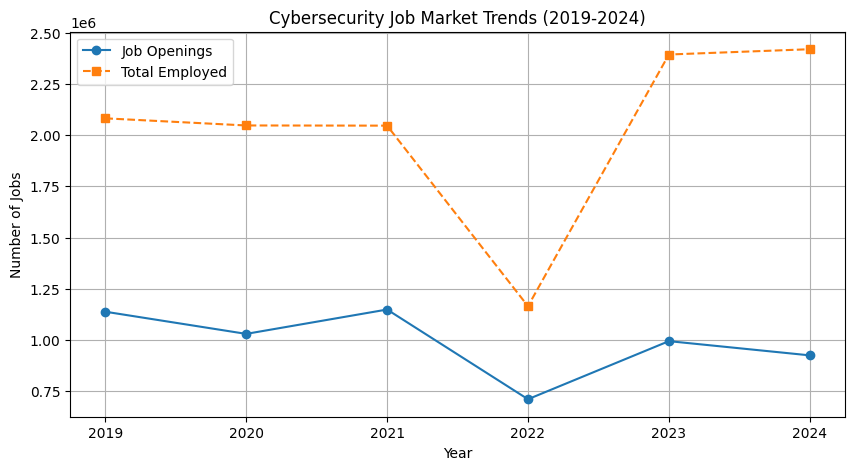

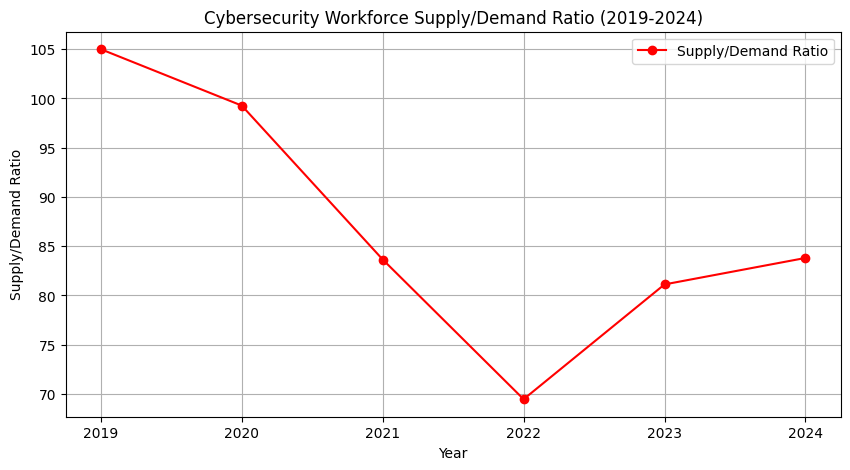

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

import matplotlib
#matplotlib.use('TkAgg')  # Use TkAgg backend instead of PyCharm's default

# Directory where JSON and CSV files are stored (Update this path as needed)
data_dir = r"/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP"

# List of CVE JSON files (ensure they are named consistently)
json_files = [
    "cve_counts_2019.json",
    "cve_counts_2020.json",
    "cve_counts_2021.json",
    "cve_counts_2022.json",
    "cve_counts_2023.json",
    "cve_counts_2024.json"
]

# Dictionary to store CVE data
cve_data = {
    "Year": [],
    "Total CVEs": [],
    "Critical": [],
    "High": [],
    "Medium": [],
    "Low": [],
    "Unknown": []
}

# Load data from JSON files
for file in json_files:
    file_path = os.path.join(data_dir, file)

    with open(file_path, "r") as f:
        data = json.load(f)

    year = int(file.split("_")[2].split(".")[0])  # Extract year from filename
    cve_data["Year"].append(year)
    cve_data["Total CVEs"].append(data[f"Total CVEs in {year}"])
    cve_data["Critical"].append(data["Critical"])
    cve_data["High"].append(data["High"])
    cve_data["Medium"].append(data["Medium"])
    cve_data["Low"].append(data["Low"])
    cve_data["Unknown"].append(data["Unknown"])

# Convert to DataFrame
df_cve = pd.DataFrame(cve_data)

# Save CVE data as CSV
cve_csv_path = os.path.join(data_dir, "cve_data_2019_2024.csv")
df_cve.to_csv(cve_csv_path, index=False)

print("CVE Data (2019-2024):")
print(df_cve)

# List of Cyber Workforce Data CSV files
workforce_files = [
    "Cyber_Workforce_Data_2019.csv",
    "Cyber_Workforce_Data_2020.csv",
    "Cyber_Workforce_Data_2021.csv",
    "Cyber_Workforce_Data_2022.csv",
    "Cyber_Workforce_Data_2023.csv",
    "Cyber_Workforce_Data_2024.csv",
]

# Load each workforce data file into a DataFrame and concatenate
workforce_dfs = []
years = list(range(2019, 2025))  # 2019 to 2024

for i, file in enumerate(workforce_files):
    file_path = os.path.join(data_dir, file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Year"] = years[i]  # Add year column
        workforce_dfs.append(df)
    else:
        print(f"Warning: {file} not found!")

# Concatenate all years of Cyber Workforce data into a single DataFrame
df_workforce = pd.concat(workforce_dfs, ignore_index=True)

# Aggregate workforce data properly
df_workforce_agg = df_workforce.groupby("Year").agg(
    {"Job Openings": "sum",
     "Total Employed": "sum",
     "Supply/Demand Ratio": "mean"}
).reset_index()

# Merge CVE data with Workforce data
df_combined = pd.merge(df_cve, df_workforce_agg, on="Year")

# Save merged data as CSV
merged_csv_path = os.path.join(data_dir, "cve_workforce_comparison.csv")
df_combined.to_csv(merged_csv_path, index=False)

print("\nMerged CVE & Cyber Workforce Data (2019-2024):")
print(df_combined)

# CORRELATION ANALYSIS & TREND ANALYSIS
correlation_data = {
    "Metric": [
        "CVEs vs Job Openings Correlation",
        "CVEs vs Employment Correlation",
        "CVEs vs Supply/Demand Ratio Correlation",
        "Linear Regression Slope (CVEs vs Job Openings)",
        "Linear Regression Slope (CVEs vs Employment)"
    ],
    "Value": [
        np.corrcoef(df_combined["Total CVEs"], df_combined["Job Openings"])[0, 1],
        np.corrcoef(df_combined["Total CVEs"], df_combined["Total Employed"])[0, 1],
        np.corrcoef(df_combined["Total CVEs"], df_combined["Supply/Demand Ratio"])[0, 1],
        stats.linregress(df_combined["Total CVEs"], df_combined["Job Openings"])[0],
        stats.linregress(df_combined["Total CVEs"], df_combined["Total Employed"])[0],
    ]
}

# Convert to DataFrame and save
df_correlation = pd.DataFrame(correlation_data)
correlation_csv_path = os.path.join(data_dir, "cve_correlation_trends.csv")
df_correlation.to_csv(correlation_csv_path, index=False)

# PRINT ANALYSIS TO CONSOLE
print("\n### Correlation Analysis ###")
print(df_correlation)

print(f"\nCorrelation & Trend Analysis saved to: {correlation_csv_path}")

# PLOT DATA AS BEFORE
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Total CVEs"], marker="o", linestyle="-", label="Total CVEs")
plt.xlabel("Year")
plt.ylabel("Total CVEs")
plt.title("Total CVEs Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for severity in ["Critical", "High", "Medium", "Low", "Unknown"]:
    plt.plot(df_combined["Year"], df_combined[severity], marker="o", linestyle="-", label=severity)
plt.xlabel("Year")
plt.ylabel("Number of CVEs")
plt.title("CVE Severity Distribution Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Total Employed"], marker="s", linestyle="--", label="Total Employed")
plt.xlabel("Year")
plt.ylabel("Number of Jobs")
plt.title("Cybersecurity Job Market Trends (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Supply/Demand Ratio"], marker="o", linestyle="-", color="red", label="Supply/Demand Ratio")
plt.xlabel("Year")
plt.ylabel("Supply/Demand Ratio")
plt.title("Cybersecurity Workforce Supply/Demand Ratio (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()



AnalysisNVD1-5

CVE Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown
0  2019       17456      2415   6711    6709   323     1298
1  2020       17967      2388   7200    7039   451      889
2  2021       20797      2379   7994    8012   618     1794
3  2022       24707      3538   9194   10055   895     1023
4  2023       28565      3378   9074   12885  1196     2029
5  2024       37713      3276  12338   18008  1560     2524

Merged CVE & Cyber Workforce Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown  Job Openings  \
0  2019       17456      2415   6711    6709   323     1298       1138516   
1  2020       17967      2388   7200    7039   451      889       1030312   
2  2021       20797      2379   7994    8012   618     1794       1149137   
3  2022       24707      3538   9194   10055   895     1023        711502   
4  2023       28565      3378   9074   12885  1196     2029        994872   
5  2024       37713      3276  12338   18008  15

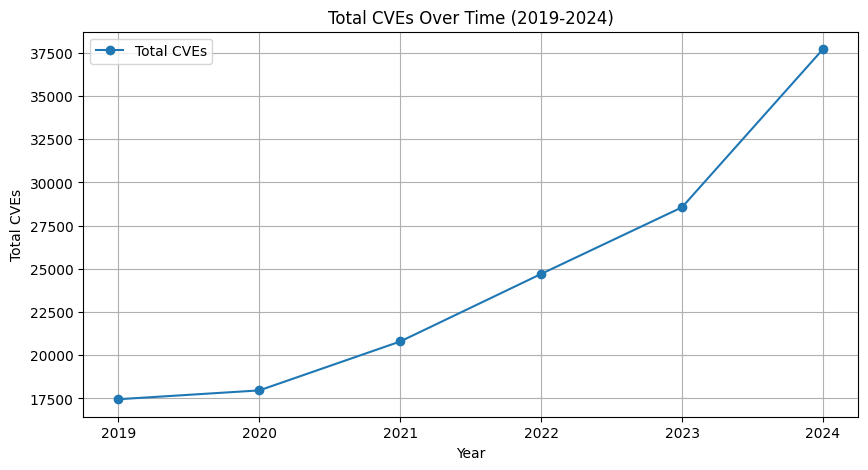

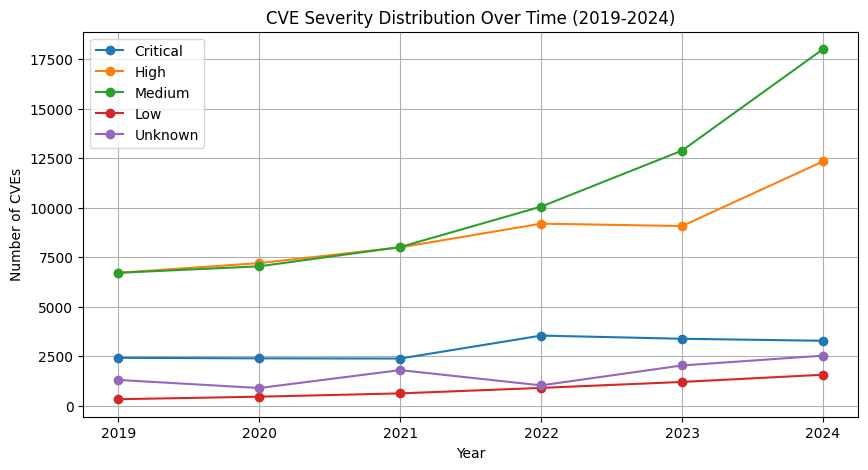

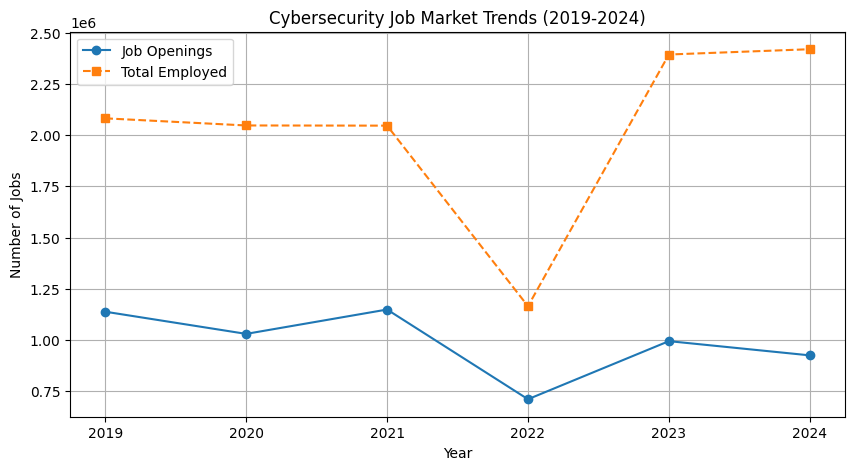

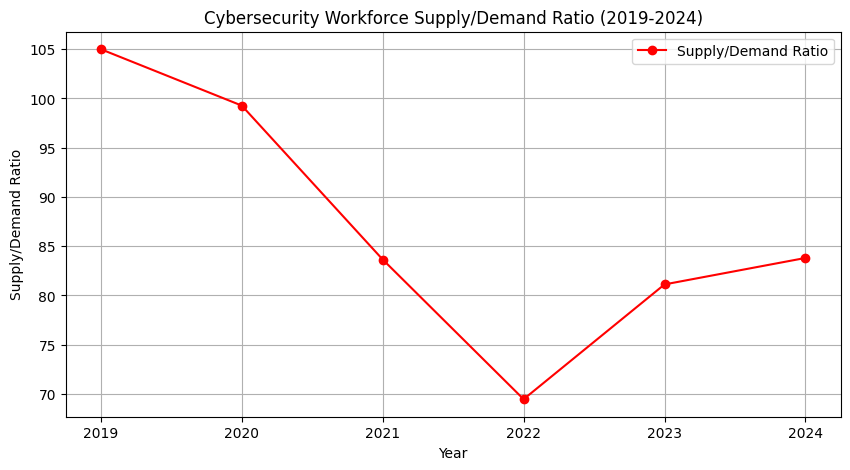

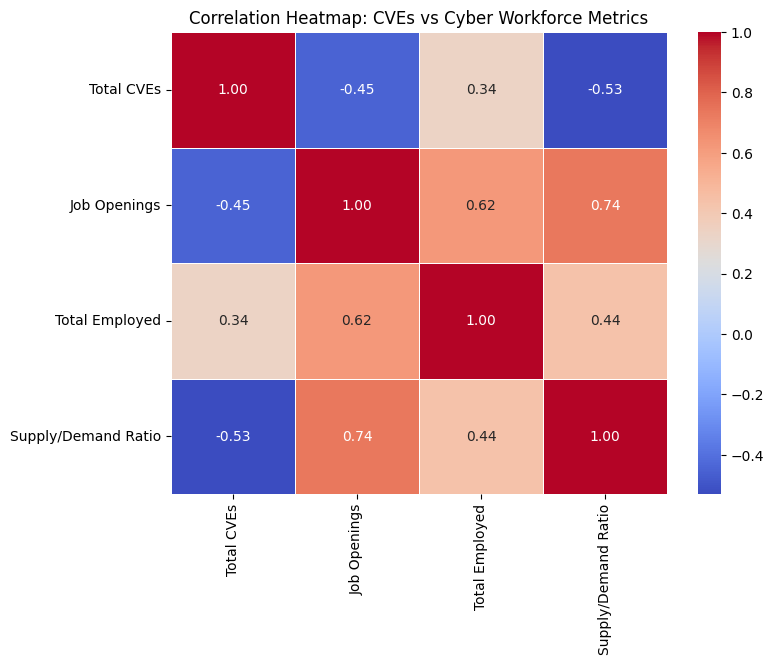

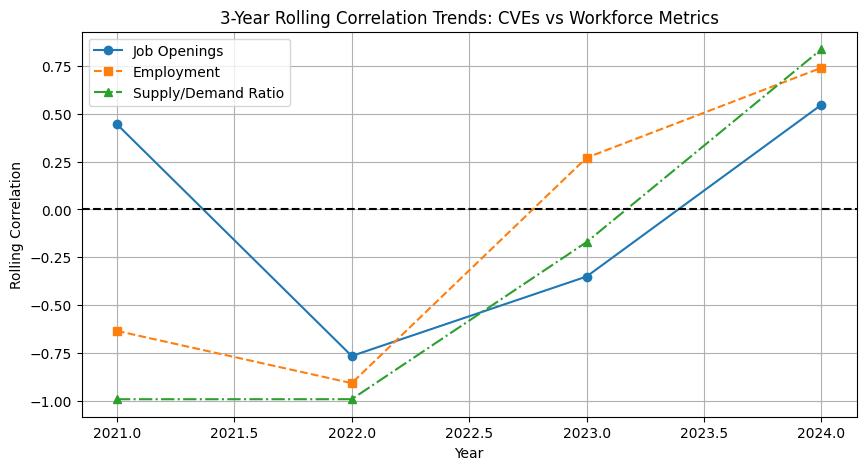

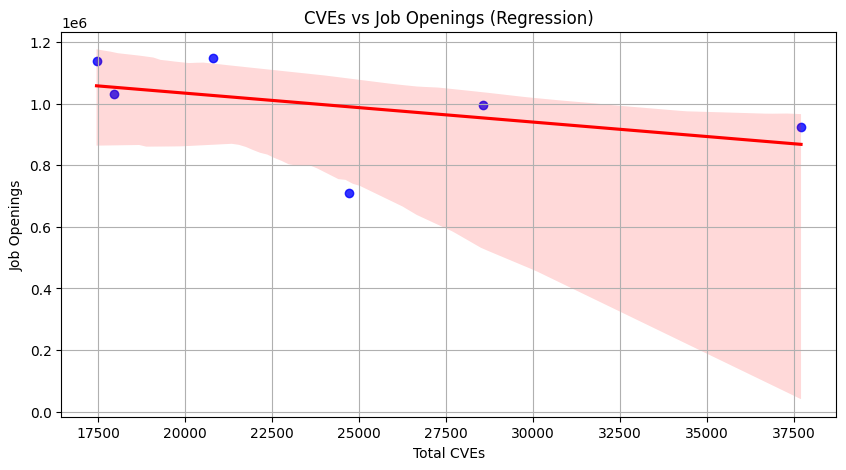

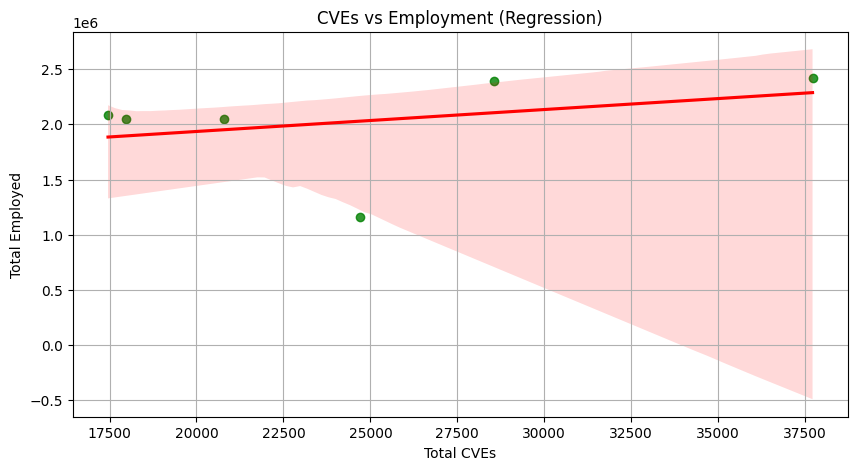

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

import matplotlib
#matplotlib.use('TkAgg')  # Use TkAgg backend instead of PyCharm's default

# Directory where JSON and CSV files are stored (Update this path as needed)
data_dir = r"/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP"

# List of CVE JSON files (ensure they are named consistently)
json_files = [
    "cve_counts_2019.json",
    "cve_counts_2020.json",
    "cve_counts_2021.json",
    "cve_counts_2022.json",
    "cve_counts_2023.json",
    "cve_counts_2024.json"
]

# Dictionary to store CVE data
cve_data = {
    "Year": [],
    "Total CVEs": [],
    "Critical": [],
    "High": [],
    "Medium": [],
    "Low": [],
    "Unknown": []
}

# Load data from JSON files
for file in json_files:
    file_path = os.path.join(data_dir, file)

    with open(file_path, "r") as f:
        data = json.load(f)

    year = int(file.split("_")[2].split(".")[0])  # Extract year from filename
    cve_data["Year"].append(year)
    cve_data["Total CVEs"].append(data[f"Total CVEs in {year}"])
    cve_data["Critical"].append(data["Critical"])
    cve_data["High"].append(data["High"])
    cve_data["Medium"].append(data["Medium"])
    cve_data["Low"].append(data["Low"])
    cve_data["Unknown"].append(data["Unknown"])

# Convert to DataFrame
df_cve = pd.DataFrame(cve_data)

# Save CVE data as CSV
cve_csv_path = os.path.join(data_dir, "cve_data_2019_2024.csv")
df_cve.to_csv(cve_csv_path, index=False)

print("CVE Data (2019-2024):")
print(df_cve)

# List of Cyber Workforce Data CSV files
workforce_files = [
    "Cyber_Workforce_Data_2019.csv",
    "Cyber_Workforce_Data_2020.csv",
    "Cyber_Workforce_Data_2021.csv",
    "Cyber_Workforce_Data_2022.csv",
    "Cyber_Workforce_Data_2023.csv",
    "Cyber_Workforce_Data_2024.csv",
]

# Load each workforce data file into a DataFrame and concatenate
workforce_dfs = []
years = list(range(2019, 2025))  # 2019 to 2024

for i, file in enumerate(workforce_files):
    file_path = os.path.join(data_dir, file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Year"] = years[i]  # Add year column
        workforce_dfs.append(df)
    else:
        print(f"Warning: {file} not found!")

# Concatenate all years of Cyber Workforce data into a single DataFrame
df_workforce = pd.concat(workforce_dfs, ignore_index=True)

# Aggregate workforce data properly
df_workforce_agg = df_workforce.groupby("Year").agg(
    {"Job Openings": "sum",
     "Total Employed": "sum",
     "Supply/Demand Ratio": "mean"}
).reset_index()

# Merge CVE data with Workforce data
df_combined = pd.merge(df_cve, df_workforce_agg, on="Year")

# Save merged data as CSV
merged_csv_path = os.path.join(data_dir, "cve_workforce_comparison.csv")
df_combined.to_csv(merged_csv_path, index=False)

print("\nMerged CVE & Cyber Workforce Data (2019-2024):")
print(df_combined)

# CORRELATION ANALYSIS & TREND ANALYSIS
correlation_data = {
    "Metric": [
        "CVEs vs Job Openings Correlation",
        "CVEs vs Employment Correlation",
        "CVEs vs Supply/Demand Ratio Correlation",
        "Linear Regression Slope (CVEs vs Job Openings)",
        "Linear Regression Slope (CVEs vs Employment)"
    ],
    "Value": [
        np.corrcoef(df_combined["Total CVEs"], df_combined["Job Openings"])[0, 1],
        np.corrcoef(df_combined["Total CVEs"], df_combined["Total Employed"])[0, 1],
        np.corrcoef(df_combined["Total CVEs"], df_combined["Supply/Demand Ratio"])[0, 1],
        stats.linregress(df_combined["Total CVEs"], df_combined["Job Openings"])[0],
        stats.linregress(df_combined["Total CVEs"], df_combined["Total Employed"])[0],
    ]
}

# Convert to DataFrame and save
df_correlation = pd.DataFrame(correlation_data)
correlation_csv_path = os.path.join(data_dir, "cve_correlation_trends.csv")
df_correlation.to_csv(correlation_csv_path, index=False)

# PRINT ANALYSIS TO CONSOLE
print("\n### Correlation Analysis ###")
print(df_correlation)

print(f"\nCorrelation & Trend Analysis saved to: {correlation_csv_path}")

# PLOT DATA AS BEFORE
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Total CVEs"], marker="o", linestyle="-", label="Total CVEs")
plt.xlabel("Year")
plt.ylabel("Total CVEs")
plt.title("Total CVEs Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for severity in ["Critical", "High", "Medium", "Low", "Unknown"]:
    plt.plot(df_combined["Year"], df_combined[severity], marker="o", linestyle="-", label=severity)
plt.xlabel("Year")
plt.ylabel("Number of CVEs")
plt.title("CVE Severity Distribution Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Total Employed"], marker="s", linestyle="--", label="Total Employed")
plt.xlabel("Year")
plt.ylabel("Number of Jobs")
plt.title("Cybersecurity Job Market Trends (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Supply/Demand Ratio"], marker="o", linestyle="-", color="red", label="Supply/Demand Ratio")
plt.xlabel("Year")
plt.ylabel("Supply/Demand Ratio")
plt.title("Cybersecurity Workforce Supply/Demand Ratio (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

# 1. Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_combined[["Total CVEs", "Job Openings", "Total Employed", "Supply/Demand Ratio"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: CVEs vs Cyber Workforce Metrics")
plt.show()

# 2. Yearly Correlation Trends
# Compute rolling correlation (window size of 3 years)
window_size = 3

df_combined["Rolling CVEs vs Job Openings"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Job Openings"])
df_combined["Rolling CVEs vs Employment"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Total Employed"])
df_combined["Rolling CVEs vs Supply/Demand Ratio"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Supply/Demand Ratio"])

# Plot Rolling Correlation Trends
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Employment"], marker="s", linestyle="--", label="Employment")
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Supply/Demand Ratio"], marker="^", linestyle="-.", label="Supply/Demand Ratio")

plt.xlabel("Year")
plt.ylabel("Rolling Correlation")
plt.title("3-Year Rolling Correlation Trends: CVEs vs Workforce Metrics")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.grid(True)
plt.show()

# 3. Scatter Plots with Regression Lines
plt.figure(figsize=(10, 5))
sns.regplot(x=df_combined["Total CVEs"], y=df_combined["Job Openings"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel("Total CVEs")
plt.ylabel("Job Openings")
plt.title("CVEs vs Job Openings (Regression)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
sns.regplot(x=df_combined["Total CVEs"], y=df_combined["Total Employed"], scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.xlabel("Total CVEs")
plt.ylabel("Total Employed")
plt.title("CVEs vs Employment (Regression)")
plt.grid(True)
plt.show()

AnalysisNVD1-6

CVE Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown
0  2019       17456      2415   6711    6709   323     1298
1  2020       17967      2388   7200    7039   451      889
2  2021       20797      2379   7994    8012   618     1794
3  2022       24707      3538   9194   10055   895     1023
4  2023       28565      3378   9074   12885  1196     2029
5  2024       37713      3276  12338   18008  1560     2524

Merged CVE & Cyber Workforce Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown  Job Openings  \
0  2019       17456      2415   6711    6709   323     1298       1138516   
1  2020       17967      2388   7200    7039   451      889       1030312   
2  2021       20797      2379   7994    8012   618     1794       1149137   
3  2022       24707      3538   9194   10055   895     1023        711502   
4  2023       28565      3378   9074   12885  1196     2029        994872   
5  2024       37713      3276  12338   18008  15

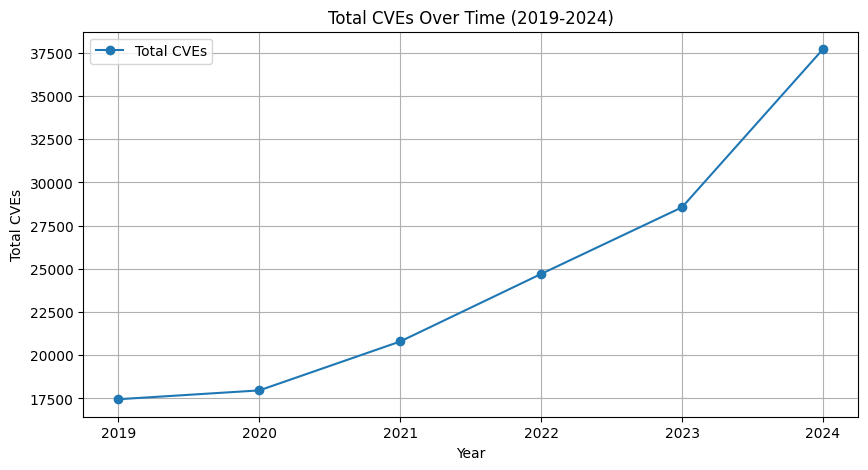

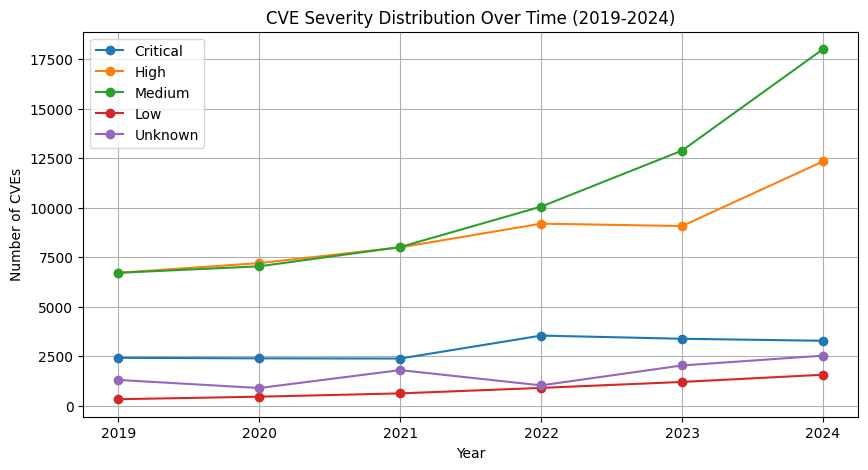

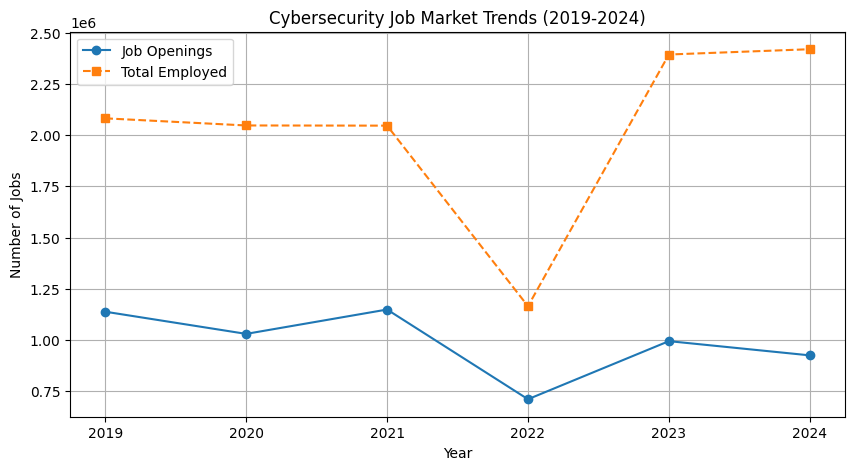

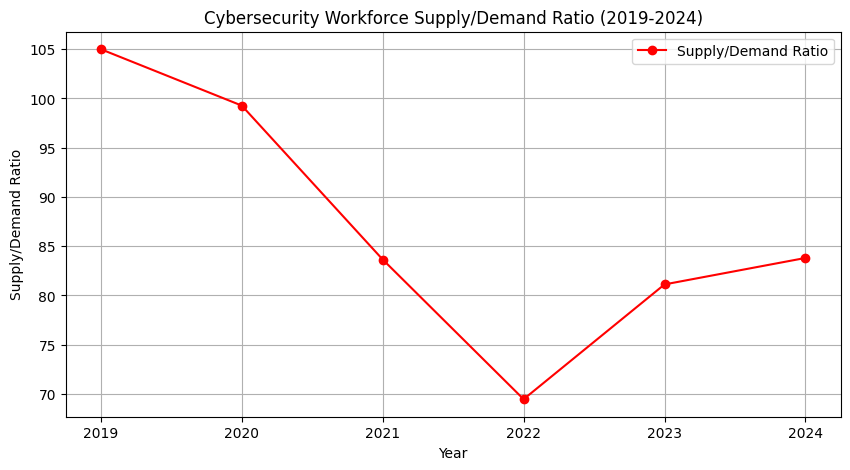

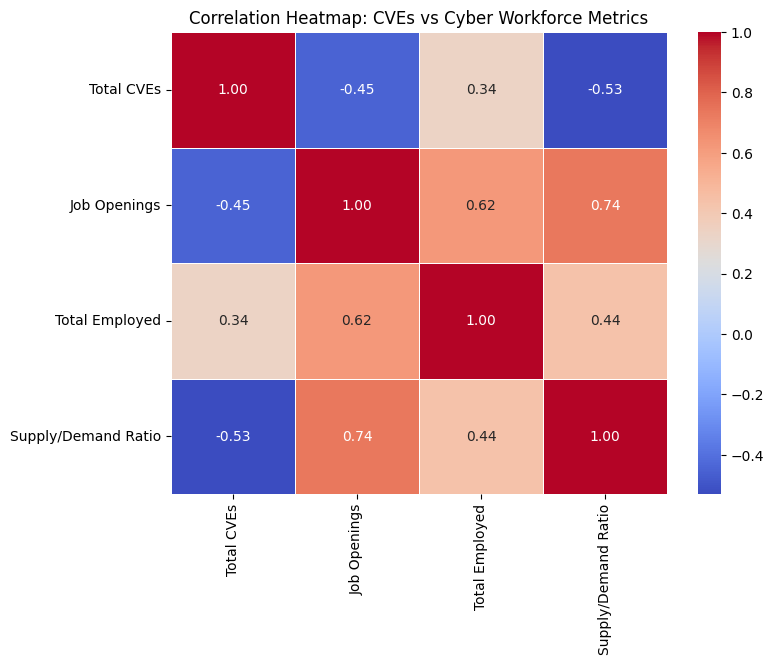

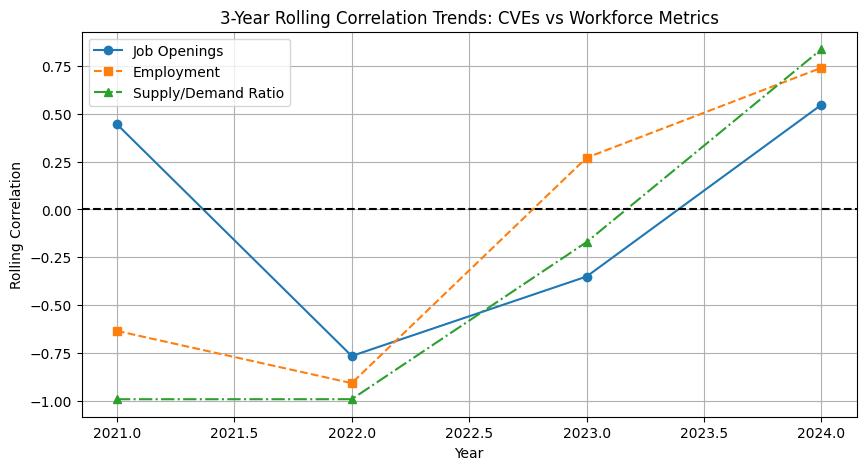

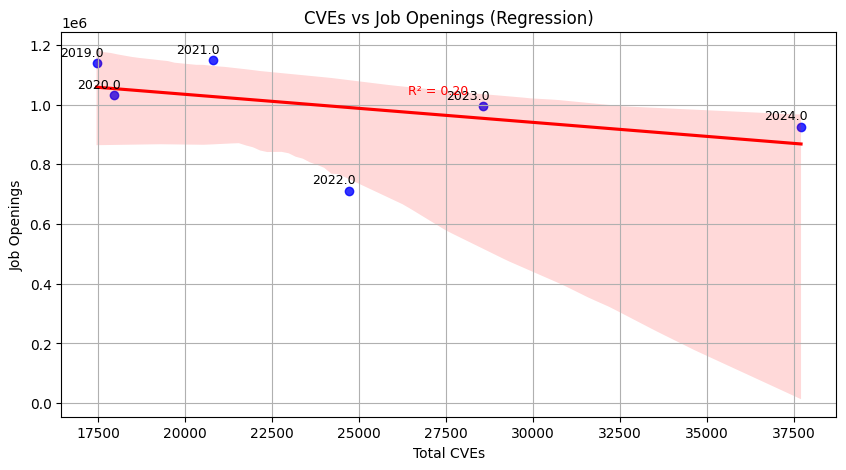

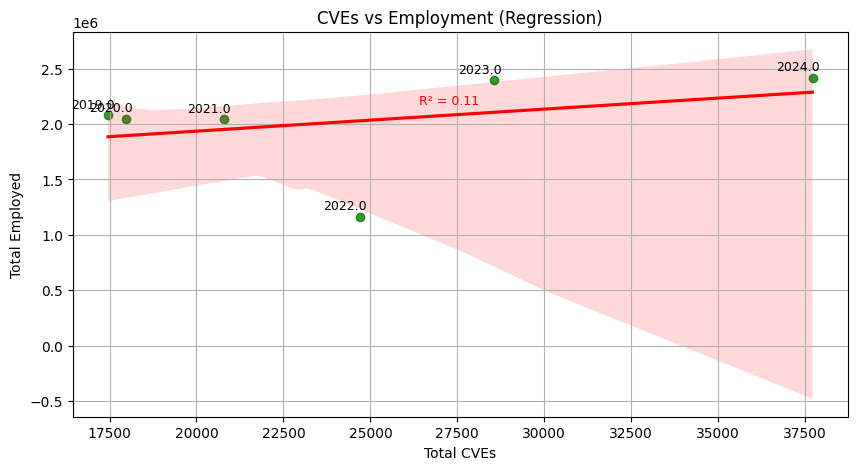

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

import matplotlib
#matplotlib.use('TkAgg')  # Use TkAgg backend instead of PyCharm's default

# Directory where JSON and CSV files are stored (Update this path as needed)
data_dir = r"/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP"

# List of CVE JSON files (ensure they are named consistently)
json_files = [
    "cve_counts_2019.json",
    "cve_counts_2020.json",
    "cve_counts_2021.json",
    "cve_counts_2022.json",
    "cve_counts_2023.json",
    "cve_counts_2024.json"
]

# Dictionary to store CVE data
cve_data = {
    "Year": [],
    "Total CVEs": [],
    "Critical": [],
    "High": [],
    "Medium": [],
    "Low": [],
    "Unknown": []
}

# Load data from JSON files
for file in json_files:
    file_path = os.path.join(data_dir, file)

    with open(file_path, "r") as f:
        data = json.load(f)

    year = int(file.split("_")[2].split(".")[0])  # Extract year from filename
    cve_data["Year"].append(year)
    cve_data["Total CVEs"].append(data[f"Total CVEs in {year}"])
    cve_data["Critical"].append(data["Critical"])
    cve_data["High"].append(data["High"])
    cve_data["Medium"].append(data["Medium"])
    cve_data["Low"].append(data["Low"])
    cve_data["Unknown"].append(data["Unknown"])

# Convert to DataFrame
df_cve = pd.DataFrame(cve_data)

# Save CVE data as CSV
cve_csv_path = os.path.join(data_dir, "cve_data_2019_2024.csv")
df_cve.to_csv(cve_csv_path, index=False)

print("CVE Data (2019-2024):")
print(df_cve)

# List of Cyber Workforce Data CSV files
workforce_files = [
    "Cyber_Workforce_Data_2019.csv",
    "Cyber_Workforce_Data_2020.csv",
    "Cyber_Workforce_Data_2021.csv",
    "Cyber_Workforce_Data_2022.csv",
    "Cyber_Workforce_Data_2023.csv",
    "Cyber_Workforce_Data_2024.csv",
]

# Load each workforce data file into a DataFrame and concatenate
workforce_dfs = []
years = list(range(2019, 2025))  # 2019 to 2024

for i, file in enumerate(workforce_files):
    file_path = os.path.join(data_dir, file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Year"] = years[i]  # Add year column
        workforce_dfs.append(df)
    else:
        print(f"Warning: {file} not found!")

# Concatenate all years of Cyber Workforce data into a single DataFrame
df_workforce = pd.concat(workforce_dfs, ignore_index=True)

# Aggregate workforce data properly
df_workforce_agg = df_workforce.groupby("Year").agg(
    {"Job Openings": "sum",
     "Total Employed": "sum",
     "Supply/Demand Ratio": "mean"}
).reset_index()

# Merge CVE data with Workforce data
df_combined = pd.merge(df_cve, df_workforce_agg, on="Year")

# Save merged data as CSV
merged_csv_path = os.path.join(data_dir, "cve_workforce_comparison.csv")
df_combined.to_csv(merged_csv_path, index=False)

print("\nMerged CVE & Cyber Workforce Data (2019-2024):")
print(df_combined)

# CORRELATION ANALYSIS & TREND ANALYSIS
correlation_data = {
    "Metric": [
        "CVEs vs Job Openings Correlation",
        "CVEs vs Employment Correlation",
        "CVEs vs Supply/Demand Ratio Correlation",
        "Linear Regression Slope (CVEs vs Job Openings)",
        "Linear Regression Slope (CVEs vs Employment)"
    ],
    "Value": [
        np.corrcoef(df_combined["Total CVEs"], df_combined["Job Openings"])[0, 1],
        np.corrcoef(df_combined["Total CVEs"], df_combined["Total Employed"])[0, 1],
        np.corrcoef(df_combined["Total CVEs"], df_combined["Supply/Demand Ratio"])[0, 1],
        stats.linregress(df_combined["Total CVEs"], df_combined["Job Openings"])[0],
        stats.linregress(df_combined["Total CVEs"], df_combined["Total Employed"])[0],
    ]
}

# Convert to DataFrame and save
df_correlation = pd.DataFrame(correlation_data)
correlation_csv_path = os.path.join(data_dir, "cve_correlation_trends.csv")
df_correlation.to_csv(correlation_csv_path, index=False)

# PRINT ANALYSIS TO CONSOLE
print("\n### Correlation Analysis ###")
print(df_correlation)

print(f"\nCorrelation & Trend Analysis saved to: {correlation_csv_path}")

# PLOT DATA AS BEFORE
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Total CVEs"], marker="o", linestyle="-", label="Total CVEs")
plt.xlabel("Year")
plt.ylabel("Total CVEs")
plt.title("Total CVEs Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for severity in ["Critical", "High", "Medium", "Low", "Unknown"]:
    plt.plot(df_combined["Year"], df_combined[severity], marker="o", linestyle="-", label=severity)
plt.xlabel("Year")
plt.ylabel("Number of CVEs")
plt.title("CVE Severity Distribution Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Total Employed"], marker="s", linestyle="--", label="Total Employed")
plt.xlabel("Year")
plt.ylabel("Number of Jobs")
plt.title("Cybersecurity Job Market Trends (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Supply/Demand Ratio"], marker="o", linestyle="-", color="red", label="Supply/Demand Ratio")
plt.xlabel("Year")
plt.ylabel("Supply/Demand Ratio")
plt.title("Cybersecurity Workforce Supply/Demand Ratio (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

# 1. Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_combined[["Total CVEs", "Job Openings", "Total Employed", "Supply/Demand Ratio"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: CVEs vs Cyber Workforce Metrics")
plt.show()

# 2. Yearly Correlation Trends
# Compute rolling correlation (window size of 3 years)
window_size = 3

df_combined["Rolling CVEs vs Job Openings"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Job Openings"])
df_combined["Rolling CVEs vs Employment"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Total Employed"])
df_combined["Rolling CVEs vs Supply/Demand Ratio"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Supply/Demand Ratio"])

# Plot Rolling Correlation Trends
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Employment"], marker="s", linestyle="--", label="Employment")
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Supply/Demand Ratio"], marker="^", linestyle="-.", label="Supply/Demand Ratio")

plt.xlabel("Year")
plt.ylabel("Rolling Correlation")
plt.title("3-Year Rolling Correlation Trends: CVEs vs Workforce Metrics")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.grid(True)
plt.show()

# 3. Scatter Plots with Regression Lines
# Perform Linear Regression for CVEs vs Job Openings
slope_jobs, intercept_jobs, r_value_jobs, p_value_jobs, std_err_jobs = stats.linregress(
    df_combined["Total CVEs"], df_combined["Job Openings"]
)

# Perform Linear Regression for CVEs vs Employment
slope_employment, intercept_employment, r_value_employment, p_value_employment, std_err_employment = stats.linregress(
    df_combined["Total CVEs"], df_combined["Total Employed"]
)

# Scatter Plot with Regression for CVEs vs Job Openings
plt.figure(figsize=(10, 5))
sns.regplot(
    x=df_combined["Total CVEs"], y=df_combined["Job Openings"],
    scatter_kws={"color": "blue"}, line_kws={"color": "red"}
)

# Annotate each scatter point with the corresponding year
for i, row in df_combined.iterrows():
    plt.annotate(row["Year"], (row["Total CVEs"], row["Job Openings"]), textcoords="offset points", xytext=(5,5), ha='right', fontsize=9)

# Add R² value label
plt.text(
    df_combined["Total CVEs"].max() * 0.7, df_combined["Job Openings"].max() * 0.9,
    f"R² = {r_value_jobs**2:.2f}", fontsize=9, color="red"
)

plt.xlabel("Total CVEs")
plt.ylabel("Job Openings")
plt.title("CVEs vs Job Openings (Regression)")
plt.grid(True)
plt.show()

# Scatter Plot with Regression for CVEs vs Employment
plt.figure(figsize=(10, 5))
sns.regplot(
    x=df_combined["Total CVEs"], y=df_combined["Total Employed"],
    scatter_kws={"color": "green"}, line_kws={"color": "red"}
)

# Annotate each scatter point with the corresponding year
for i, row in df_combined.iterrows():
    plt.annotate(row["Year"], (row["Total CVEs"], row["Total Employed"]), textcoords="offset points", xytext=(5,5), ha='right', fontsize=9)

# Add R² value label
plt.text(
    df_combined["Total CVEs"].max() * 0.7, df_combined["Total Employed"].max() * 0.9,
    f"R² = {r_value_employment**2:.2f}", fontsize=9, color="red"
)

plt.xlabel("Total CVEs")
plt.ylabel("Total Employed")
plt.title("CVEs vs Employment (Regression)")
plt.grid(True)
plt.show()

AnalysisNVD1-7

CVE Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown
0  2019       17456      2415   6711    6709   323     1298
1  2020       17967      2388   7200    7039   451      889
2  2021       20797      2379   7994    8012   618     1794
3  2022       24707      3538   9194   10055   895     1023
4  2023       28565      3378   9074   12885  1196     2029
5  2024       37713      3276  12338   18008  1560     2524

Merged CVE & Cyber Workforce Data (2019-2024):
   Year  Total CVEs  Critical   High  Medium   Low  Unknown  Job Openings  \
0  2019       17456      2415   6711    6709   323     1298       1138516   
1  2020       17967      2388   7200    7039   451      889       1030312   
2  2021       20797      2379   7994    8012   618     1794       1149137   
3  2022       24707      3538   9194   10055   895     1023        711502   
4  2023       28565      3378   9074   12885  1196     2029        994872   
5  2024       37713      3276  12338   18008  15

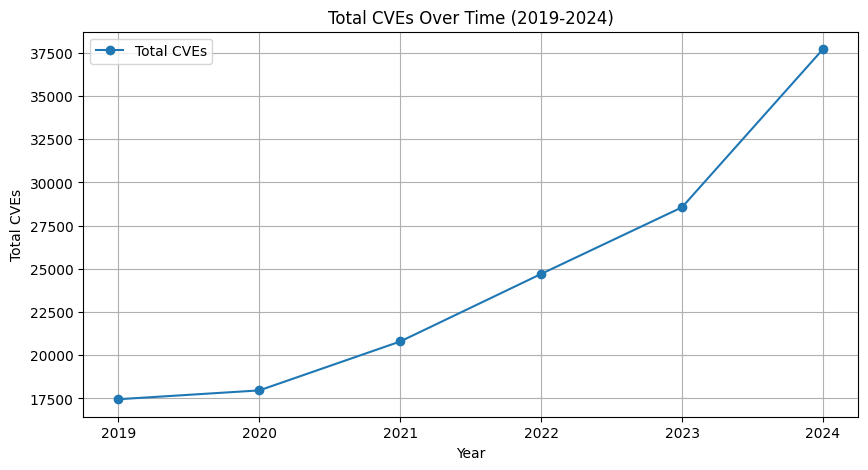

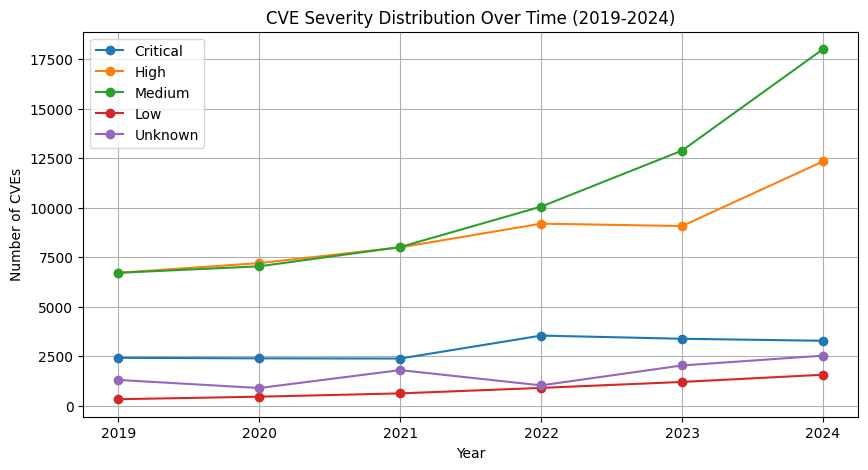

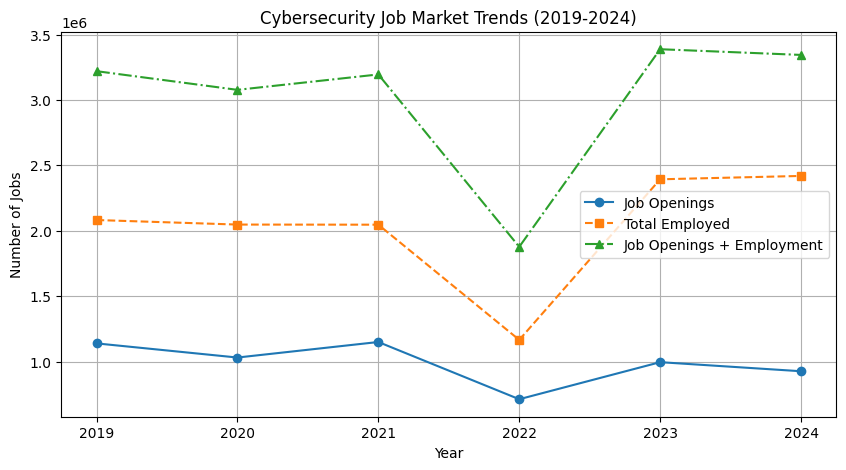

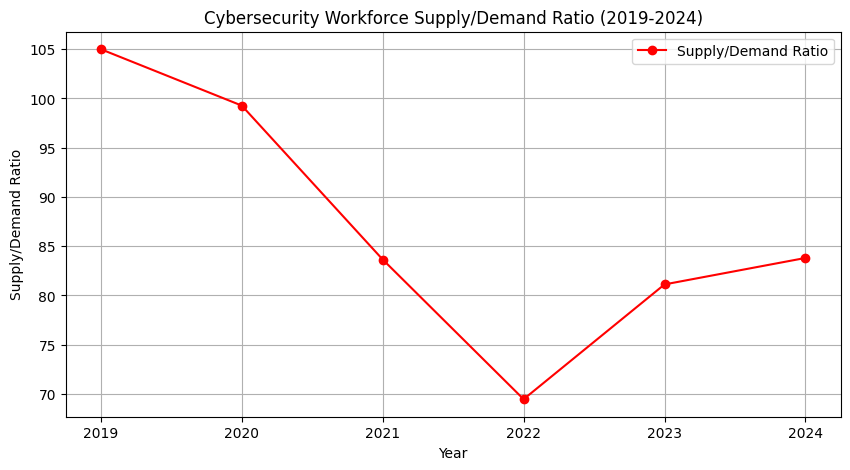

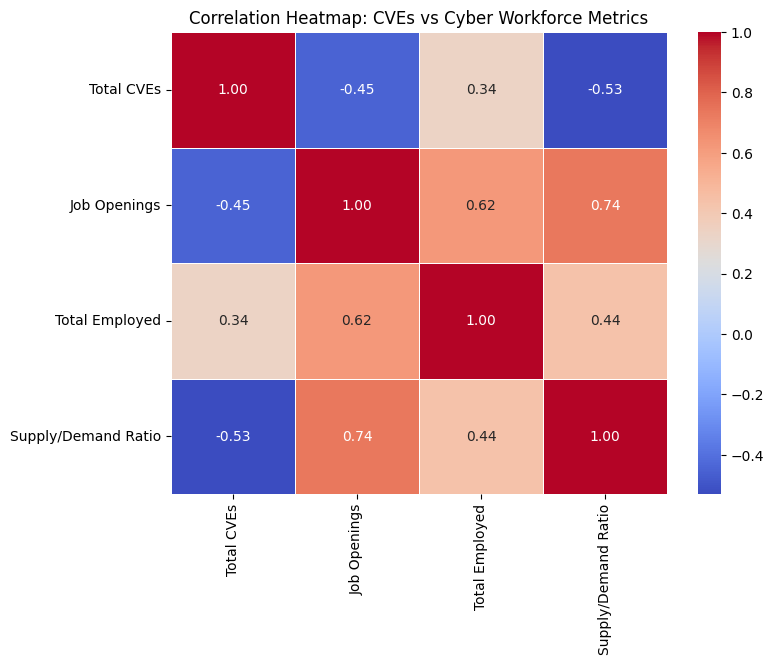

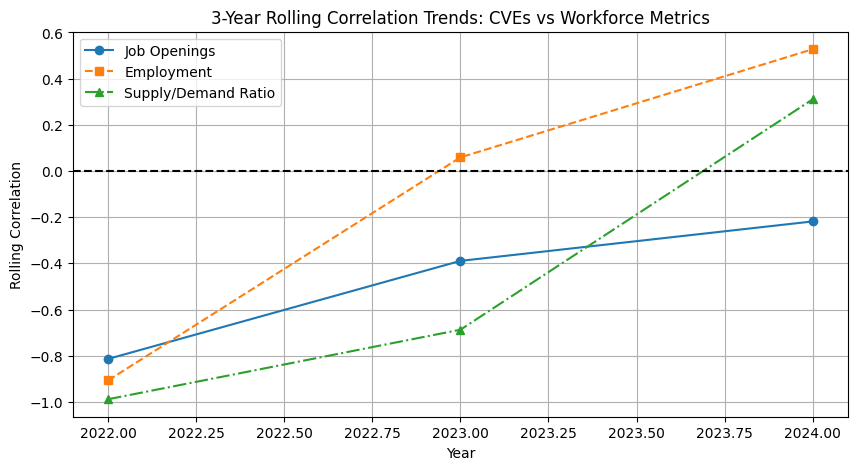

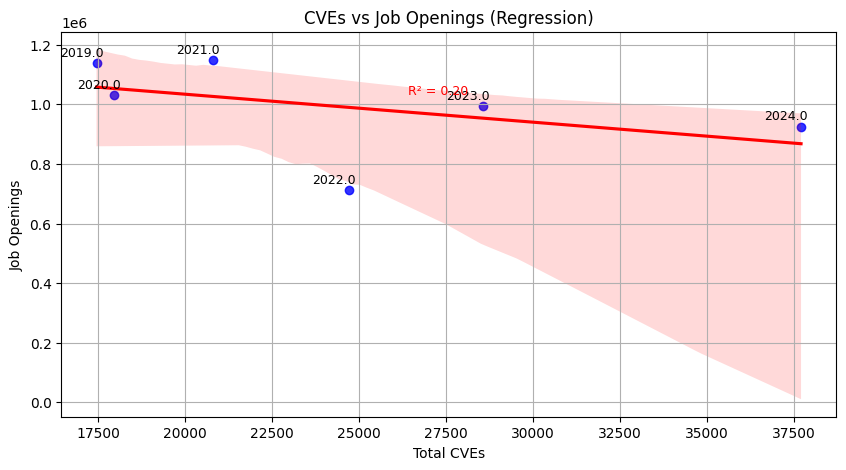

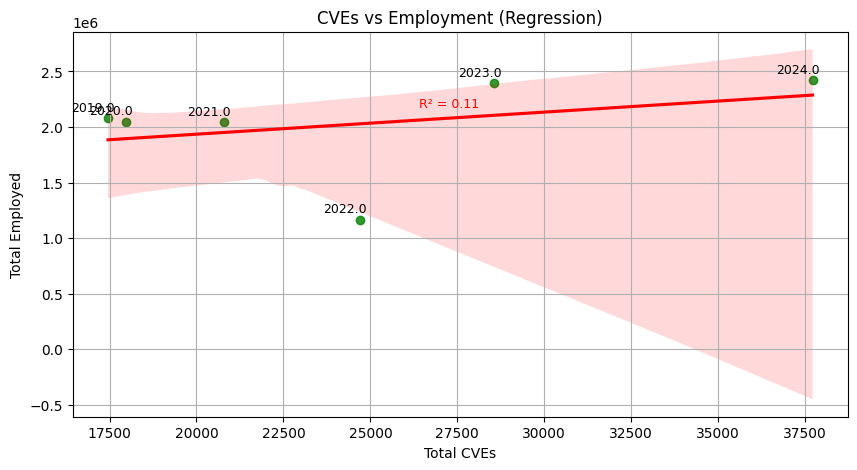

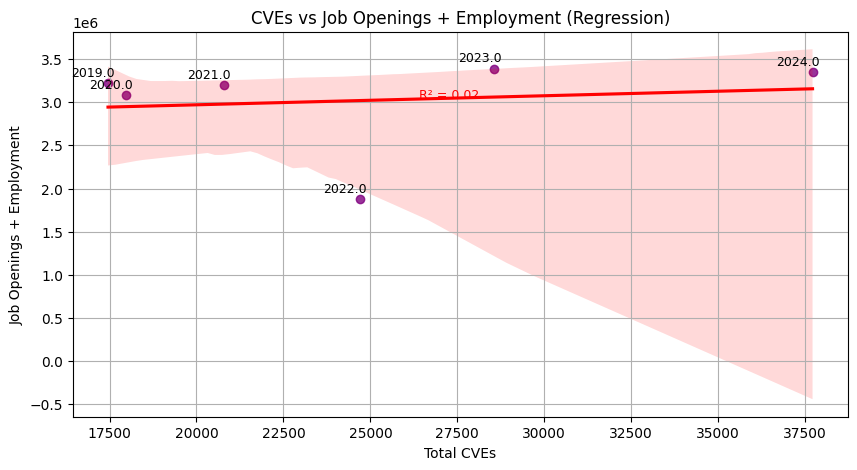

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from scipy.optimize import curve_fit

import matplotlib
#matplotlib.use('TkAgg')  # Use TkAgg backend instead of PyCharm's default

# Directory where JSON and CSV files are stored (Update this path as needed)
data_dir = r"/content/drive/MyDrive/DataAnalysis2 5 25-1625_BKUP"

# List of CVE JSON files (ensure they are named consistently)
json_files = [
    "cve_counts_2019.json",
    "cve_counts_2020.json",
    "cve_counts_2021.json",
    "cve_counts_2022.json",
    "cve_counts_2023.json",
    "cve_counts_2024.json"
]

# Dictionary to store CVE data
cve_data = {
    "Year": [],
    "Total CVEs": [],
    "Critical": [],
    "High": [],
    "Medium": [],
    "Low": [],
    "Unknown": []
}

# Load data from JSON files
for file in json_files:
    file_path = os.path.join(data_dir, file)

    with open(file_path, "r") as f:
        data = json.load(f)

    year = int(file.split("_")[2].split(".")[0])  # Extract year from filename
    cve_data["Year"].append(year)
    cve_data["Total CVEs"].append(data[f"Total CVEs in {year}"])
    cve_data["Critical"].append(data["Critical"])
    cve_data["High"].append(data["High"])
    cve_data["Medium"].append(data["Medium"])
    cve_data["Low"].append(data["Low"])
    cve_data["Unknown"].append(data["Unknown"])

# Convert to DataFrame
df_cve = pd.DataFrame(cve_data)

# Save CVE data as CSV
cve_csv_path = os.path.join(data_dir, "cve_data_2019_2024.csv")
df_cve.to_csv(cve_csv_path, index=False)

print("CVE Data (2019-2024):")
print(df_cve)

# List of Cyber Workforce Data CSV files
workforce_files = [
    "Cyber_Workforce_Data_2019.csv",
    "Cyber_Workforce_Data_2020.csv",
    "Cyber_Workforce_Data_2021.csv",
    "Cyber_Workforce_Data_2022.csv",
    "Cyber_Workforce_Data_2023.csv",
    "Cyber_Workforce_Data_2024.csv",
]

# Load each workforce data file into a DataFrame and concatenate
workforce_dfs = []
years = list(range(2019, 2025))  # 2019 to 2024

for i, file in enumerate(workforce_files):
    file_path = os.path.join(data_dir, file)

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["Year"] = years[i]  # Add year column
        workforce_dfs.append(df)
    else:
        print(f"Warning: {file} not found!")

# Concatenate all years of Cyber Workforce data into a single DataFrame
df_workforce = pd.concat(workforce_dfs, ignore_index=True)

# Aggregate workforce data properly
df_workforce_agg = df_workforce.groupby("Year").agg(
    {"Job Openings": "sum",
     "Total Employed": "sum",
     "Supply/Demand Ratio": "mean"}
).reset_index()

# Merge CVE data with Workforce data
df_combined = pd.merge(df_cve, df_workforce_agg, on="Year")

# Save merged data as CSV
merged_csv_path = os.path.join(data_dir, "cve_workforce_comparison.csv")
df_combined.to_csv(merged_csv_path, index=False)

print("\nMerged CVE & Cyber Workforce Data (2019-2024):")
print(df_combined)

# Load merged dataset
merged_csv_path = os.path.join(data_dir, "cve_workforce_comparison.csv")
df_combined = pd.read_csv(merged_csv_path)

# Compute Job Openings + Total Employed
df_combined["Job Openings + Employment"] = df_combined["Job Openings"] + df_combined["Total Employed"]

# CORRELATION ANALYSIS & TREND ANALYSIS
correlation_data = {
    "Metric": [
        "CVEs vs Job Openings Correlation",
        "CVEs vs Employment Correlation",
        "CVEs vs Supply/Demand Ratio Correlation",
        "Linear Regression Slope (CVEs vs Job Openings)",
        "Linear Regression Slope (CVEs vs Employment)",
        "Linear Regression Slope (CVEs vs Job Openings + Employment)"  # New metric added
    ],
    "Value": [
        np.corrcoef(df_combined["Total CVEs"], df_combined["Job Openings"])[0, 1],
        np.corrcoef(df_combined["Total CVEs"], df_combined["Total Employed"])[0, 1],
        np.corrcoef(df_combined["Total CVEs"], df_combined["Supply/Demand Ratio"])[0, 1],
        stats.linregress(df_combined["Total CVEs"], df_combined["Job Openings"])[0],
        stats.linregress(df_combined["Total CVEs"], df_combined["Total Employed"])[0],
        stats.linregress(df_combined["Total CVEs"], df_combined["Job Openings + Employment"])[0]  # New computation
    ]
}

# Convert to DataFrame and save
df_correlation = pd.DataFrame(correlation_data)
correlation_csv_path = os.path.join(data_dir, "cve_correlation_trends.csv")
df_correlation.to_csv(correlation_csv_path, index=False)


# PRINT ANALYSIS TO CONSOLE
print("\n### Correlation Analysis ###")
print(df_correlation)

print(f"\nCorrelation & Trend Analysis saved to: {correlation_csv_path}")

# Define an exponential function for curve fitting
def exponential_model(x, a, b, c):
    return a * np.exp(b * x) + c

# Fit the exponential model to the CVE data
years = df_combined["Year"].values
total_cves = df_combined["Total CVEs"].values
#params, covariance = curve_fit(exponential_model, years, total_cves, p0=[1, 0.1, 1], maxfev=10000)

# PLOT DATA AS BEFORE
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Total CVEs"], marker="o", linestyle="-", label="Total CVEs")
plt.xlabel("Year")
plt.ylabel("Total CVEs")
plt.title("Total CVEs Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for severity in ["Critical", "High", "Medium", "Low", "Unknown"]:
    plt.plot(df_combined["Year"], df_combined[severity], marker="o", linestyle="-", label=severity)
plt.xlabel("Year")
plt.ylabel("Number of CVEs")
plt.title("CVE Severity Distribution Over Time (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Total Employed"], marker="s", linestyle="--", label="Total Employed")
plt.plot(df_combined["Year"], df_combined["Job Openings + Employment"], marker="^", linestyle="-.", label="Job Openings + Employment")
plt.xlabel("Year")
plt.ylabel("Number of Jobs")
plt.title("Cybersecurity Job Market Trends (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Supply/Demand Ratio"], marker="o", linestyle="-", color="red", label="Supply/Demand Ratio")
plt.xlabel("Year")
plt.ylabel("Supply/Demand Ratio")
plt.title("Cybersecurity Workforce Supply/Demand Ratio (2019-2024)")
plt.legend()
plt.grid(True)
plt.show()

# 1. Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_combined[["Total CVEs", "Job Openings", "Total Employed", "Supply/Demand Ratio"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: CVEs vs Cyber Workforce Metrics")
plt.show()

# 2. Yearly Correlation Trends
# Compute rolling correlation (window size of 3 years)
window_size = 4

df_combined["Rolling CVEs vs Job Openings"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Job Openings"])
df_combined["Rolling CVEs vs Employment"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Total Employed"])
df_combined["Rolling CVEs vs Supply/Demand Ratio"] = df_combined["Total CVEs"].rolling(window=window_size).corr(df_combined["Supply/Demand Ratio"])

# Plot Rolling Correlation Trends
plt.figure(figsize=(10, 5))
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Job Openings"], marker="o", linestyle="-", label="Job Openings")
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Employment"], marker="s", linestyle="--", label="Employment")
plt.plot(df_combined["Year"], df_combined["Rolling CVEs vs Supply/Demand Ratio"], marker="^", linestyle="-.", label="Supply/Demand Ratio")

plt.xlabel("Year")
plt.ylabel("Rolling Correlation")
plt.title("3-Year Rolling Correlation Trends: CVEs vs Workforce Metrics")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.grid(True)
plt.show()

# 3. Scatter Plots with Regression Lines
# Perform Linear Regression for CVEs vs Job Openings
slope_jobs, intercept_jobs, r_value_jobs, p_value_jobs, std_err_jobs = stats.linregress(
    df_combined["Total CVEs"], df_combined["Job Openings"]
)

# Perform Linear Regression for CVEs vs Employment
slope_employment, intercept_employment, r_value_employment, p_value_employment, std_err_employment = stats.linregress(
    df_combined["Total CVEs"], df_combined["Total Employed"]
)

# Scatter Plot with Regression for CVEs vs Job Openings
plt.figure(figsize=(10, 5))
sns.regplot(
    x=df_combined["Total CVEs"], y=df_combined["Job Openings"],
    scatter_kws={"color": "blue"}, line_kws={"color": "red"}
)

# Annotate each scatter point with the corresponding year
for i, row in df_combined.iterrows():
    plt.annotate(row["Year"], (row["Total CVEs"], row["Job Openings"]), textcoords="offset points", xytext=(5,5), ha='right', fontsize=9)

# Add R² value label
plt.text(
    df_combined["Total CVEs"].max() * 0.7, df_combined["Job Openings"].max() * 0.9,
    f"R² = {r_value_jobs**2:.2f}", fontsize=9, color="red"
)

plt.xlabel("Total CVEs")
plt.ylabel("Job Openings")
plt.title("CVEs vs Job Openings (Regression)")
plt.grid(True)
plt.show()

# Scatter Plot with Regression for CVEs vs Employment
plt.figure(figsize=(10, 5))
sns.regplot(
    x=df_combined["Total CVEs"], y=df_combined["Total Employed"],
    scatter_kws={"color": "green"}, line_kws={"color": "red"}
)

# Annotate each scatter point with the corresponding year
for i, row in df_combined.iterrows():
    plt.annotate(row["Year"], (row["Total CVEs"], row["Total Employed"]), textcoords="offset points", xytext=(5,5), ha='right', fontsize=9)

# Add R² value label
plt.text(
    df_combined["Total CVEs"].max() * 0.7, df_combined["Total Employed"].max() * 0.9,
    f"R² = {r_value_employment**2:.2f}", fontsize=9, color="red"
)

plt.xlabel("Total CVEs")
plt.ylabel("Total Employed")
plt.title("CVEs vs Employment (Regression)")
plt.grid(True)
plt.show()

# Perform linear regression for CVEs vs Job Openings + Total Employed
slope_combined, intercept_combined, r_value_combined, p_value_combined, std_err_combined = stats.linregress(
    df_combined["Total CVEs"], df_combined["Job Openings + Employment"]
)

# Scatter Plot with Regression for CVEs vs Job Openings + Total Employed
plt.figure(figsize=(10, 5))
sns.regplot(
    x=df_combined["Total CVEs"], y=df_combined["Job Openings + Employment"],
    scatter_kws={"color": "purple"}, line_kws={"color": "red"}
)

# Annotate each scatter point with the corresponding year
for i, row in df_combined.iterrows():
    plt.annotate(row["Year"], (row["Total CVEs"], row["Job Openings + Employment"]), textcoords="offset points", xytext=(5,5), ha='right', fontsize=9)

# Add R² value label
plt.text(
    df_combined["Total CVEs"].max() * 0.7, df_combined["Job Openings + Employment"].max() * 0.9,
    f"R² = {r_value_combined**2:.2f}", fontsize=9, color="red"
)

plt.xlabel("Total CVEs")
plt.ylabel("Job Openings + Employment")
plt.title("CVEs vs Job Openings + Employment (Regression)")
plt.grid(True)
plt.show()

CVE data stored because of execusion of AnalysisNVD1-8.py

|Year|Total CVEs|Critical|High|Medium|Low|Unknown|Job Openings|Total Employed|Supply/Demand Ratio|
|---|---|---|---|---|---|---|---|---|---|
|2019|17456|2415|6711|6709|323|1298|1138516|2082020|105\.0|
|2020|17967|2388|7200|7039|451|889|1030312|2047264|99\.27450980392157|
|2021|20797|2379|7994|8012|618|1794|1149137|2046356|83\.6470588235294|
|2022|24707|3538|9194|10055|895|1023|711502|1165332|69\.46|
|2023|28565|3378|9074|12885|1196|2029|994872|2393472|81\.11764705882354|
|2024|37713|3276|12338|18008|1560|2524|925493|2419245|83\.80392156862744|

|Year|Total CVEs|Critical|High|Medium|Low|Unknown|Job Openings|Total Employed|Supply/Demand Ratio|CVE Growth Rate|Job Openings Growth Rate|Employment Growth Rate|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|2019|17456|2415|6711|6709|323|1298|1138516|2082020|105\.0||||
|2020|17967|2388|7200|7039|451|889|1030312|2047264|99\.27450980392157|2\.9273602199816784|-9\.503950756950275|-1\.6693403521579997|
|2021|20797|2379|7994|8012|618|1794|1149137|2046356|83\.6470588235294|15\.751099237490962|11\.532914301687258|-0\.04435187645560612|
|2022|24707|3538|9194|10055|895|1023|711502|1165332|69\.46|18\.800788575275273|-38\.083796797074676|-43\.0533103721933|
|2023|28565|3378|9074|12885|1196|2029|994872|2393472|81\.11764705882354|15\.615007892500099|39\.827013838330735|105\.38970868387723|
|2024|37713|3276|12338|18008|1560|2524|925493|2419245|83\.80392156862744|32\.02520567127605|-6\.973660933265791|1\.0768039066260338|

|Metric|Value|
|---|---|
|CVEs vs Job Openings Correlation|-0\.4475136125168652|
|CVEs vs Employment Correlation|0\.3366761902690481|
|CVEs vs Supply/Demand Ratio Correlation|-0\.5296276301815717|
|Linear Regression Slope \(CVEs vs Job Openings\)|-9\.386727776476524|
|Linear Regression Slope \(CVEs vs Employment\)|19\.864266296575035|
|Linear Regression Slope \(CVEs vs Job Openings + Employment\)|10\.477538520098511|